## Develop machine learning models to determine the likelihood of a customer defaulting on a loan. 

We are going to take following approach-
1. Problem Statement
2. Exploratory Data Analysis
3. Data Preprocessing
5. Model and Evaluation

### Descriptions
In this project, my primary objective is to build a robust model for loan default prediction based on the provided dataset. Here's a detailed overview of how I plan to tackle this challenge:
>* Reduce the size of dataframes if required.
>* Check Data Imbalance
>* Data Preprocessing
>* Then, Our usual tendency is to seperate the dataset into train set and dev set (in case test set is already seperated), and train the whole dataset and evaluate on dev set, but in this project I used **K-Fold cross-validation** extensively.
>* Cross-validation help us to get *clean* predictions, clean means the predictions that model has never seen before.



## 1. Problem Definition
> In today's financial landscape, an accurate prediction of customer loan default can reduce the risk and maintain a healthy lending portfolio. The challenge requires the participants to develop machine learning models to determine the likelihood of a customer defaulting on a loan. 

## 2. Data
> *  The Data is probided on below link
> * https://machinehack.com/hackathons/analytics_olympiad_2023/data

## 3. Model Evaluation
> * All submissions will be evaluated using the roc_auc_score
> * Our goal is to get **high roc_auc_score**.
> * ROC AUC (Receiver Operating Characteristic Area Under the Curve) is a metric commonly used to evaluate the performance of classification models, particularly in binary classification tasks. It measures the ability of a model to distinguish between positive and negative classes by plotting the ROC curve and calculating the area under that curve.


In [10]:
#Preparing the tools
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
import warnings; warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor,CatBoostClassifier, metrics, Pool, cv
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',50)
from sklearn.metrics import *
import pickle as pkl

### Load Data

In [27]:
#Importing data
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [15]:
#Check size of dataframe and information
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1106674 entries, 0 to 1106673
Data columns (total 62 columns):
 #   Column                              Non-Null Count    Dtype  
---  ------                              --------------    -----  
 0   customer_id                         1106674 non-null  object 
 1   firstname                           1106674 non-null  object 
 2   lastname                            1106674 non-null  object 
 3   record_number                       1106674 non-null  int64  
 4   days_since_opened                   1106674 non-null  int64  
 5   days_since_confirmed                1106674 non-null  int64  
 6   primary_term                        1106674 non-null  int64  
 7   final_term                          1106674 non-null  int64  
 8   days_till_primary_close             1106674 non-null  int64  
 9   days_till_final_close               1106674 non-null  int64  
 10  loans_credit_limit                  1106674 non-null  int64  
 11  loans_next_

### As the dataframes are large, lets try to reduce size of dataframe.

In [28]:
import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
#         if ('SK_ID' in c):
#             df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        if (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

train=convert_types(train)
test=convert_types(test)

In [17]:
# Size reduced
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1106674 entries, 0 to 1106673
Data columns (total 62 columns):
 #   Column                              Non-Null Count    Dtype   
---  ------                              --------------    -----   
 0   customer_id                         1106674 non-null  category
 1   firstname                           1106674 non-null  category
 2   lastname                            1106674 non-null  category
 3   record_number                       1106674 non-null  int64   
 4   days_since_opened                   1106674 non-null  int64   
 5   days_since_confirmed                1106674 non-null  int64   
 6   primary_term                        1106674 non-null  int64   
 7   final_term                          1106674 non-null  int64   
 8   days_till_primary_close             1106674 non-null  int64   
 9   days_till_final_close               1106674 non-null  int64   
 10  loans_credit_limit                  1106674 non-null  int64   
 11

In [29]:
# separate the target variables 
y_1=train['primary_close_flag']
y_2=train['final_close_flag']
data=pd.concat((train,test)).reset_index(drop=True).copy()
data=data.drop(columns=['primary_close_flag','final_close_flag'],axis=1)

train=data[:len(train)]
test=data[len(train):]

num_ft_train=  train.select_dtypes(include=[np.number])
num_ft_test=  test.select_dtypes(include=[np.number])


# Exploratory Data Analysis

In [19]:
#Checking missing values
print(f"Number of Missing values in train set is: {train.isna().sum().sum()}")
print(f"Number of Missing values in test set is: {test.isna().sum().sum()}")

Number of Missing values in train set is: 907408
Number of Missing values in test set is: 389112


In [20]:
na_cols= [col for col in data if data[col].isna().sum()>0]
na_cols

['encoded_payment_0',
 'encoded_payment_1',
 'encoded_payment_2',
 'encoded_payment_3',
 'encoded_payment_4',
 'encoded_payment_5',
 'encoded_payment_6',
 'encoded_payment_7',
 'encoded_payment_8',
 'encoded_payment_9',
 'encoded_payment_10',
 'encoded_payment_11',
 'encoded_payment_12',
 'encoded_payment_13',
 'encoded_payment_14',
 'encoded_payment_15',
 'encoded_payment_16',
 'encoded_payment_17',
 'encoded_payment_18',
 'encoded_payment_19',
 'encoded_payment_20',
 'encoded_payment_21',
 'encoded_payment_22',
 'encoded_payment_23',
 'encoded_payment_24']

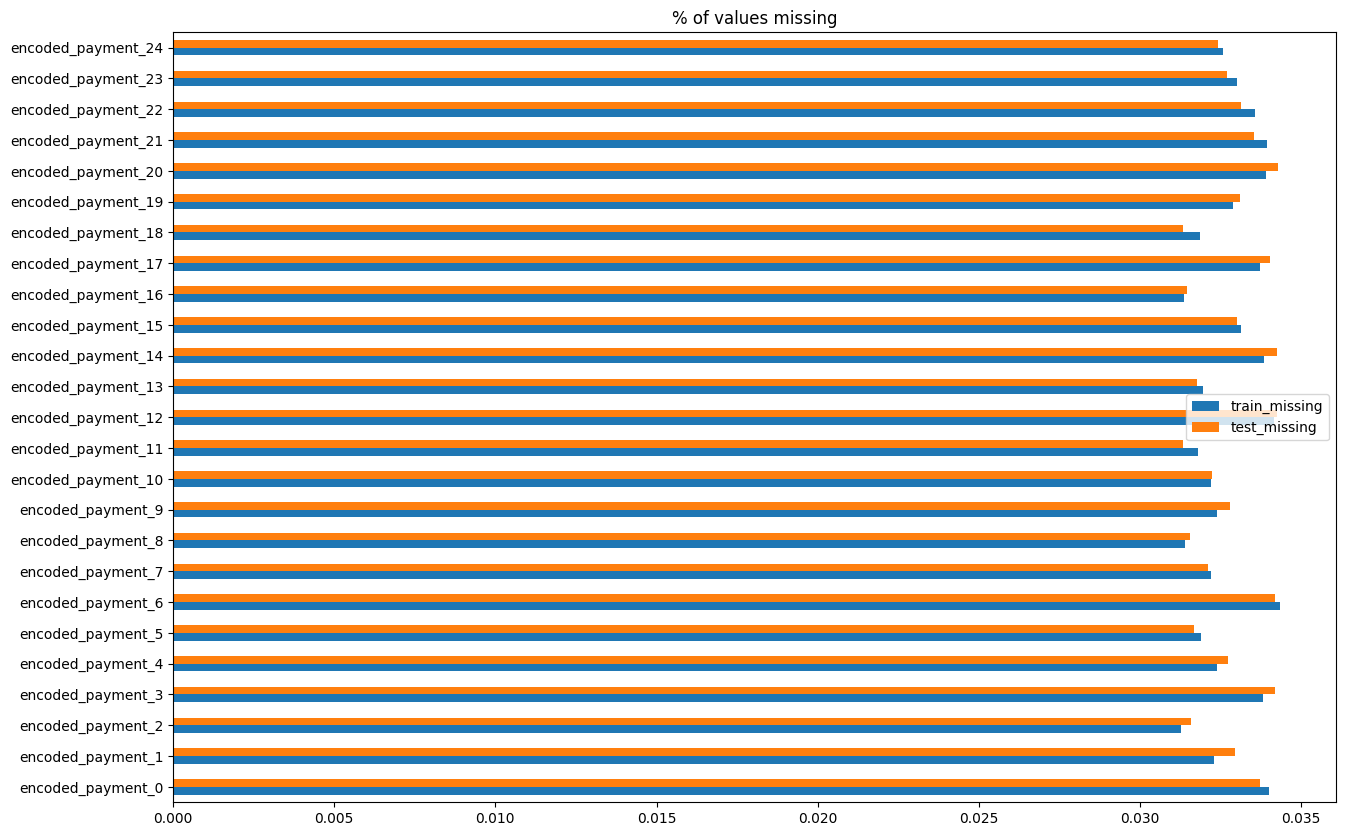

In [21]:
ncounts= pd.DataFrame([train.isna().mean(),test.isna().mean()]).T
ncounts= ncounts.rename(columns={0:'train_missing',1:'test_missing'})
ncounts.query('train_missing>0').plot(kind='barh',figsize=(15,10),title='% of values missing')
plt.show()

 ###  NOTE: Since the percentage of missing values is less than 5%, no imputation or handling of missing values is performed.

###  Checking distribution, outliers of train and test set

In [131]:
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

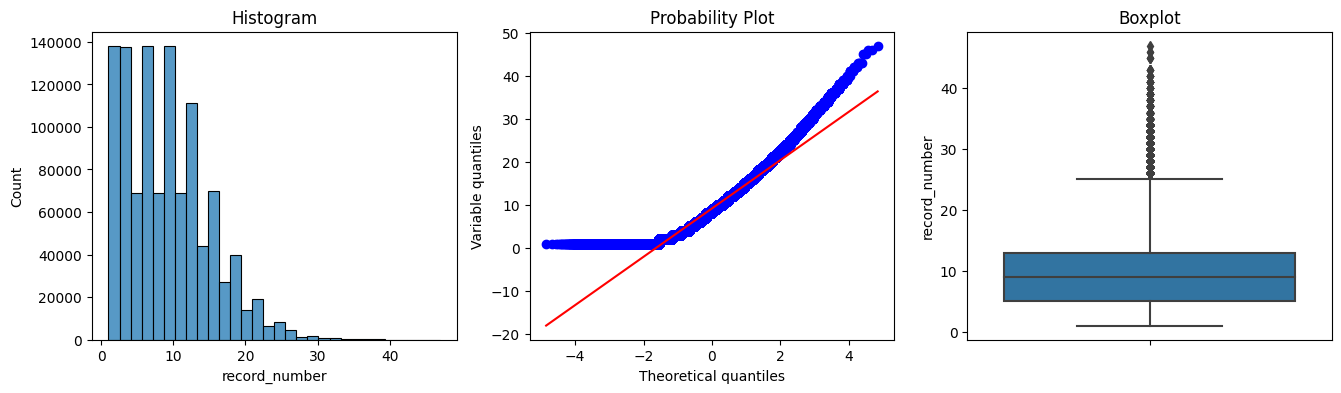

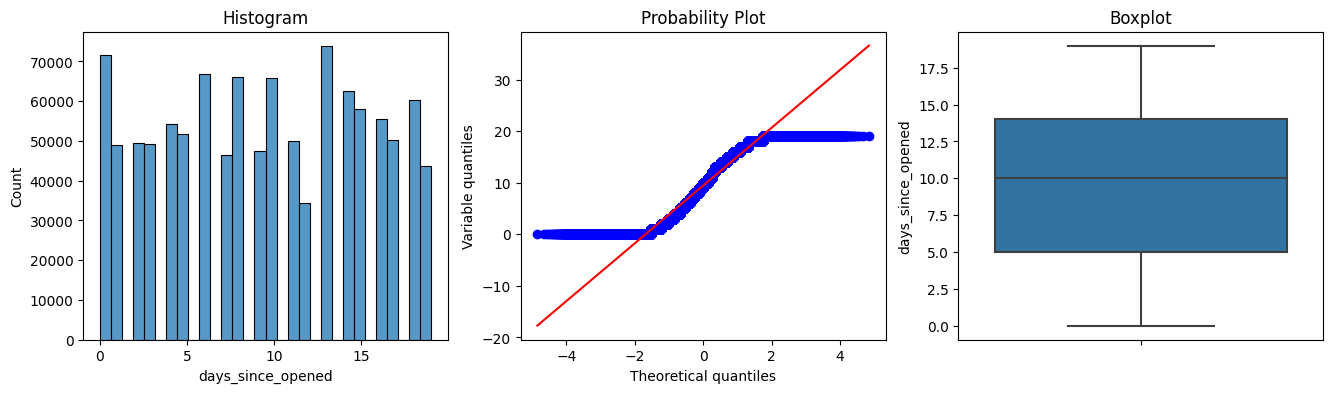

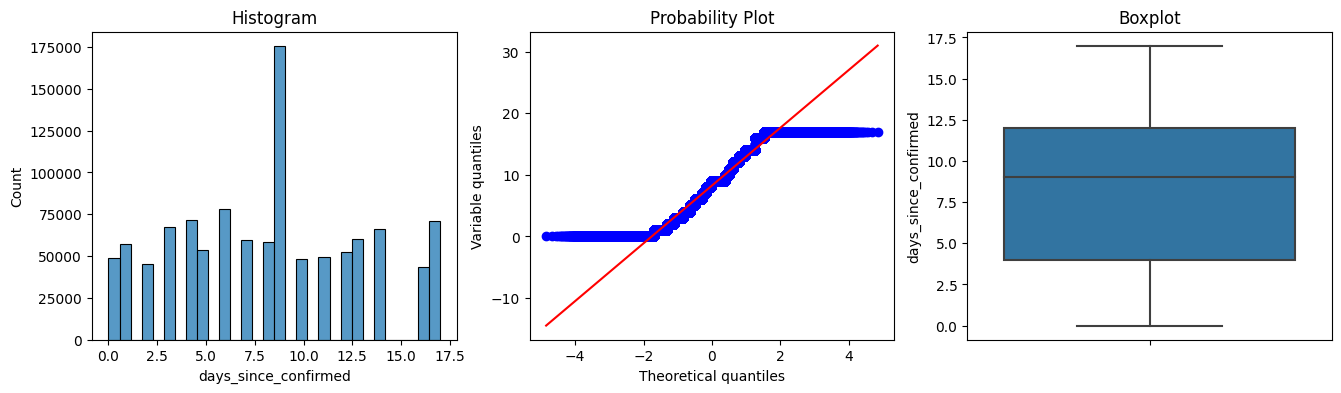

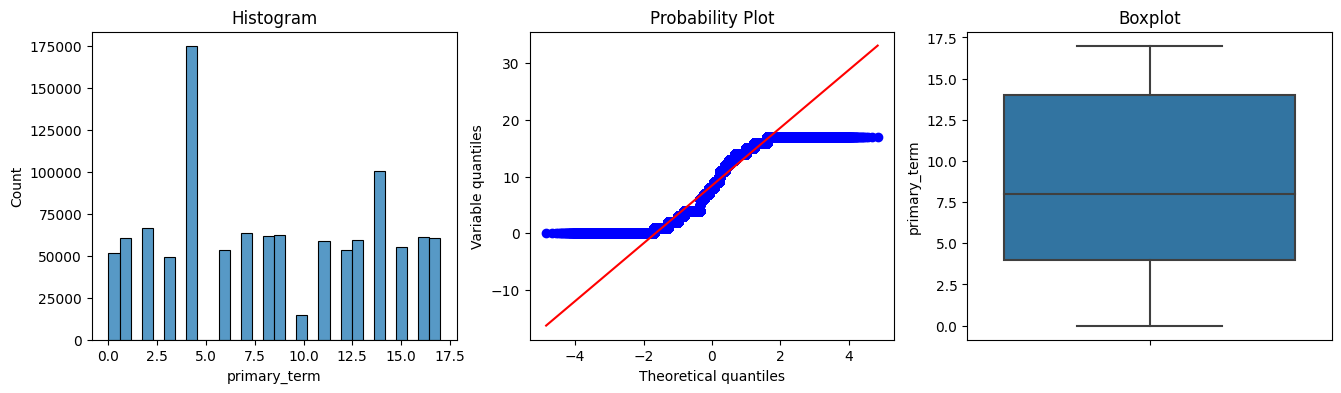

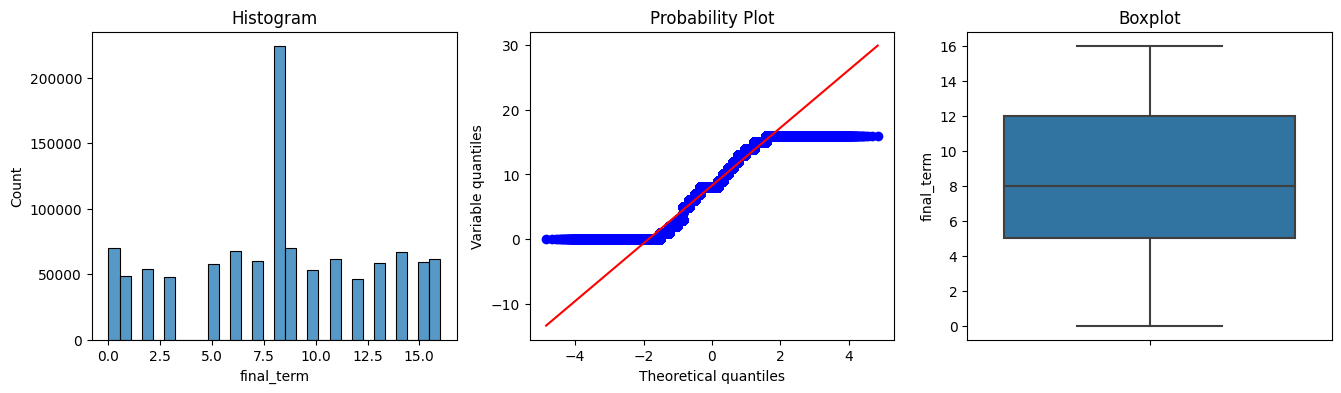

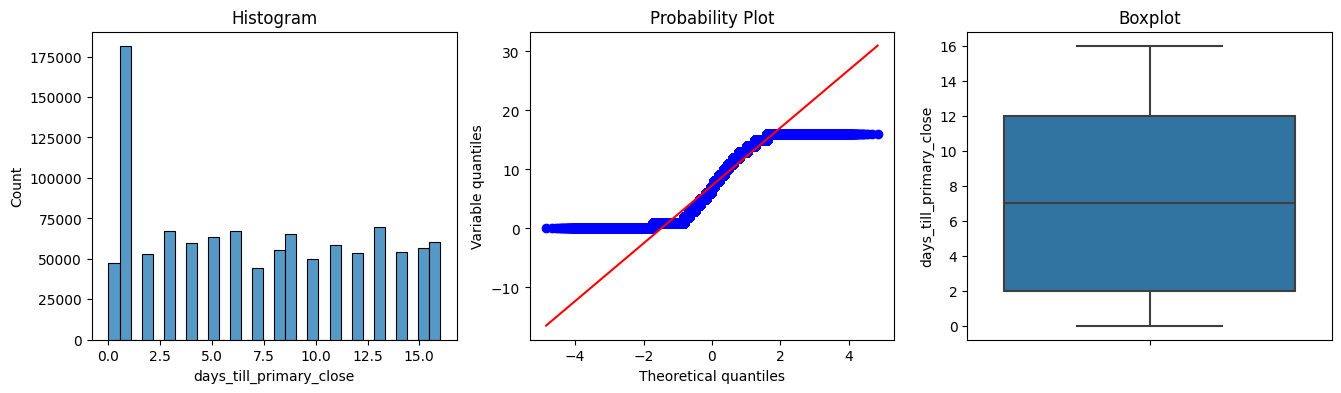

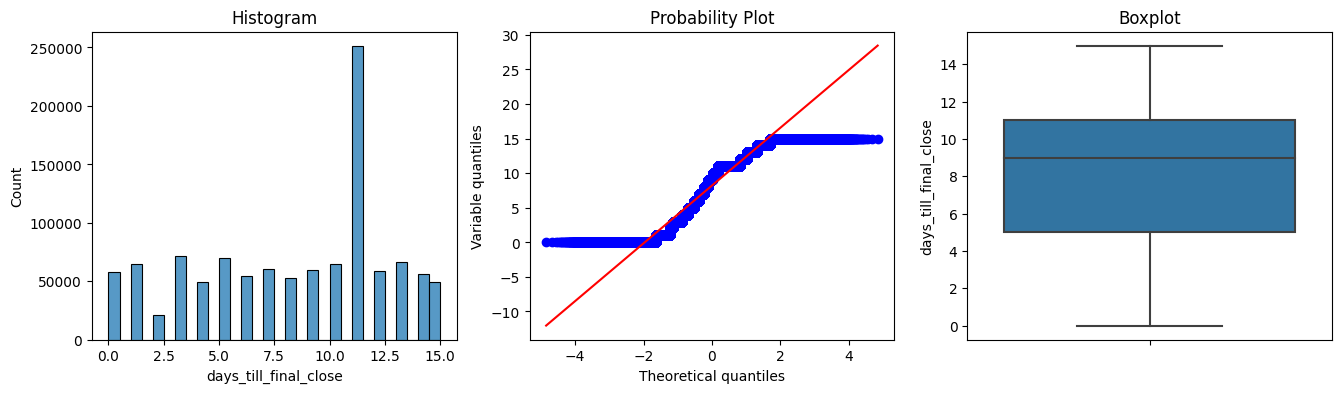

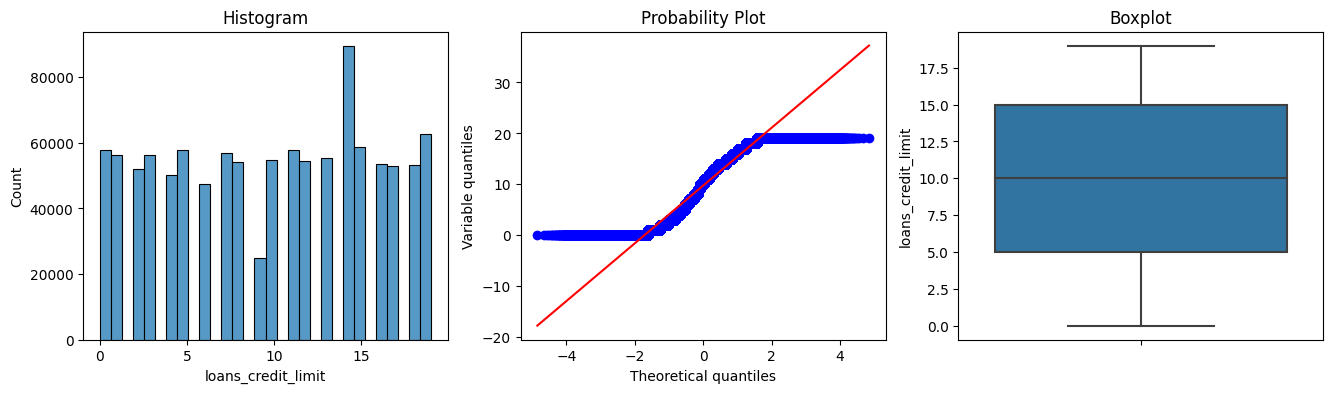

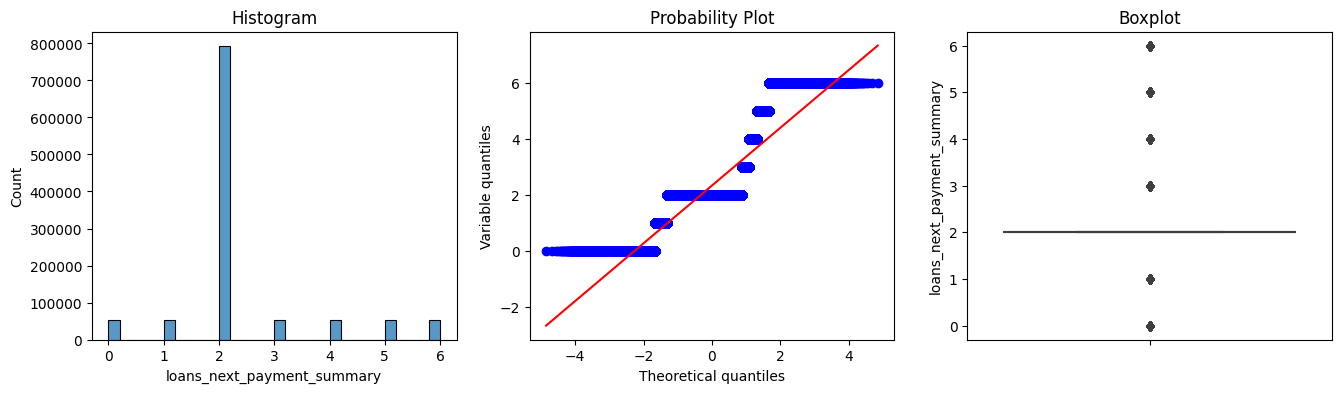

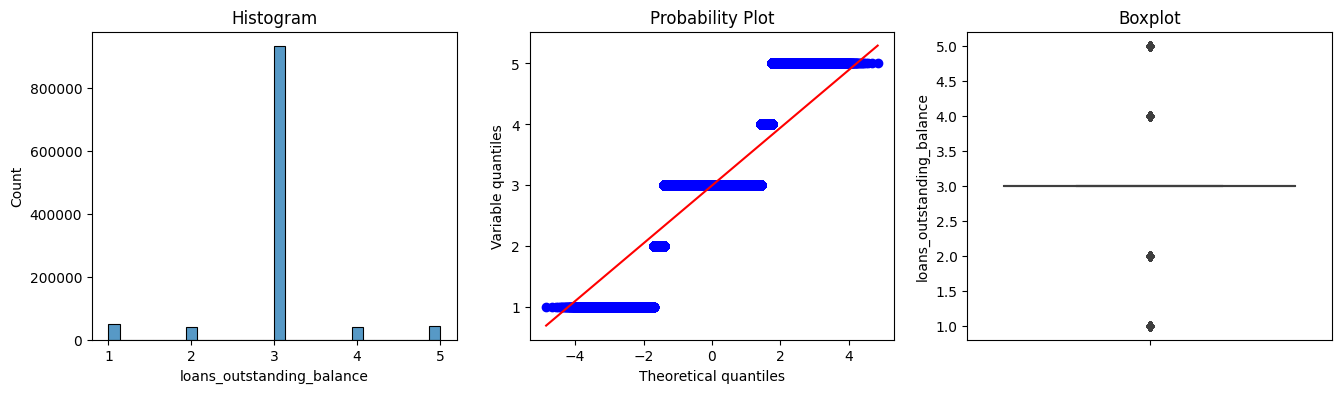

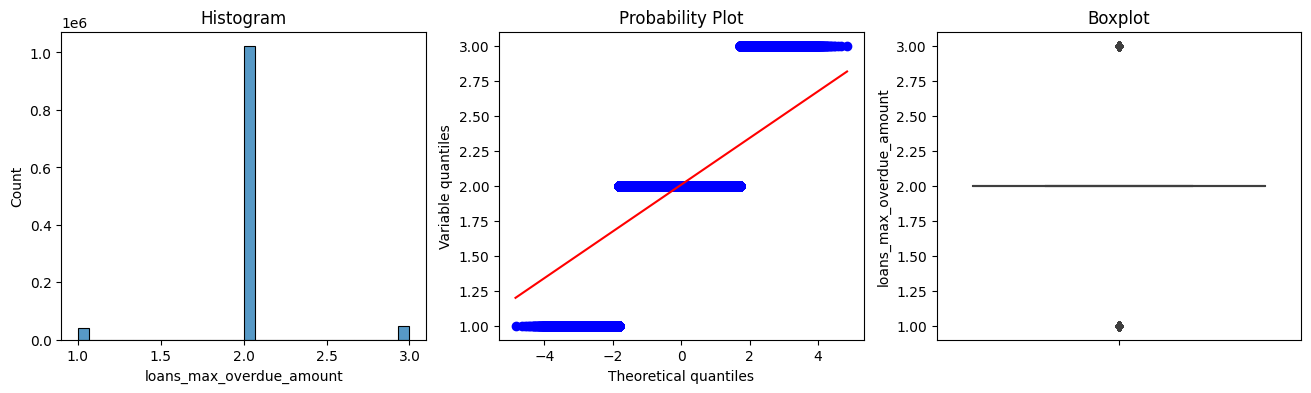

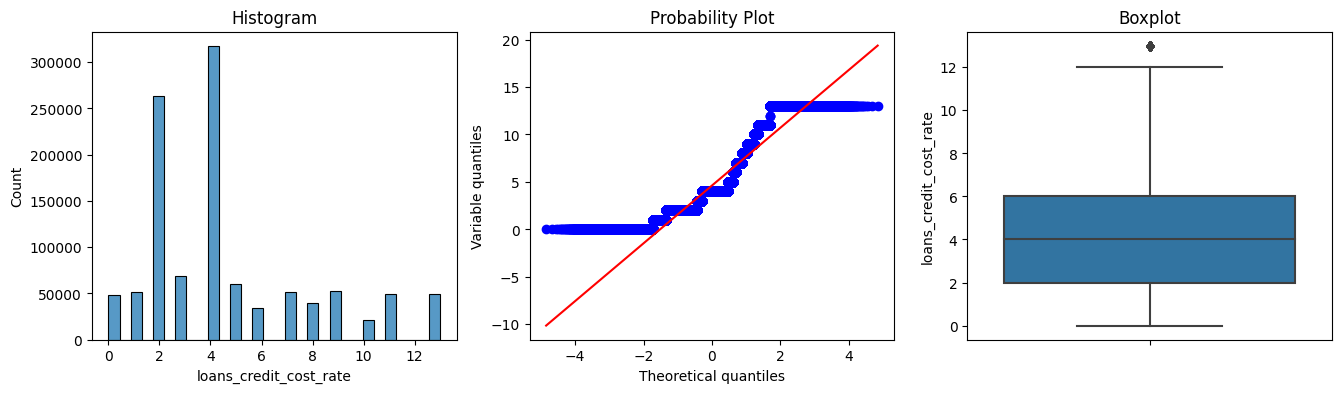

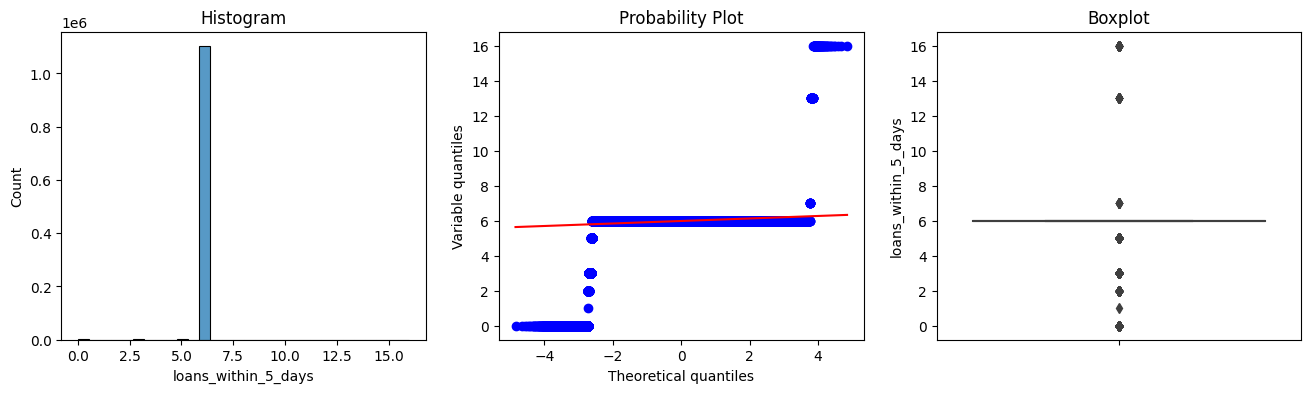

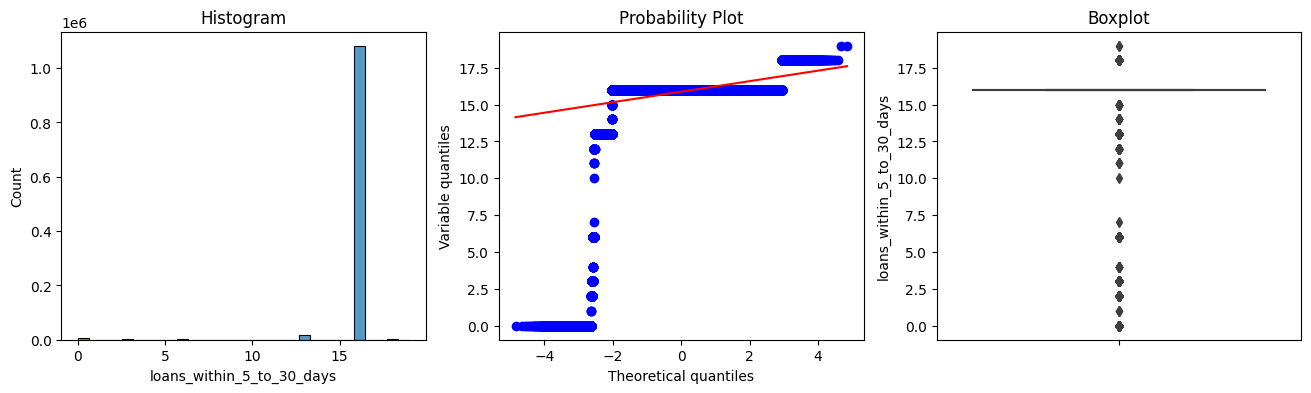

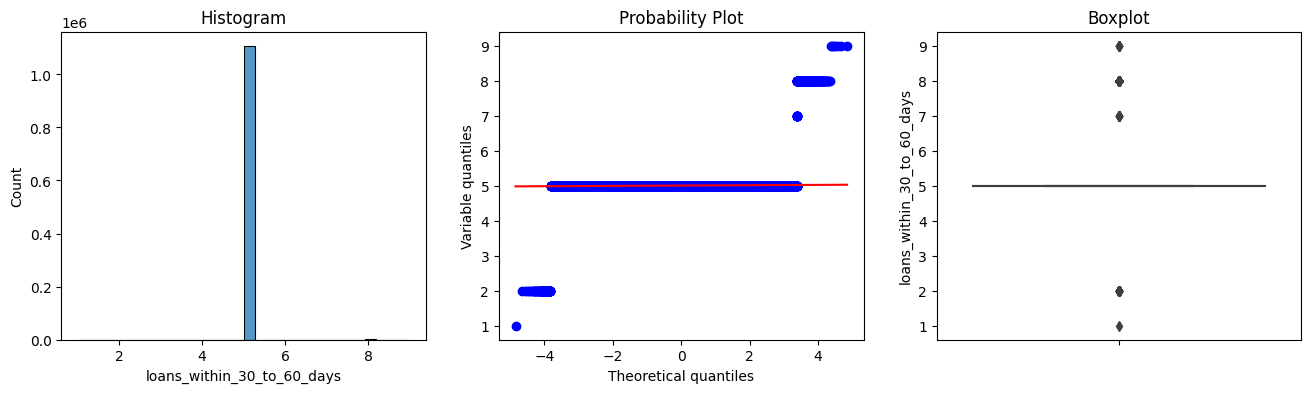

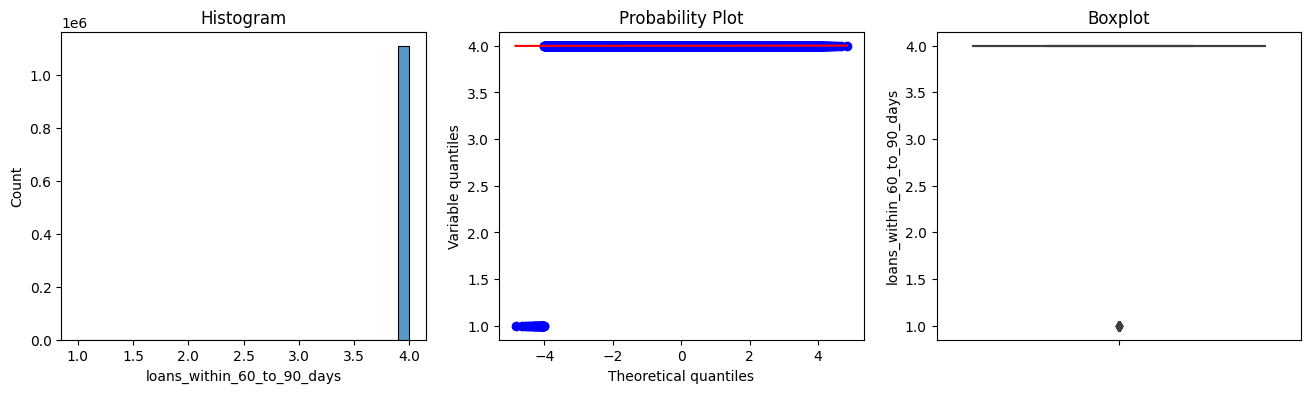

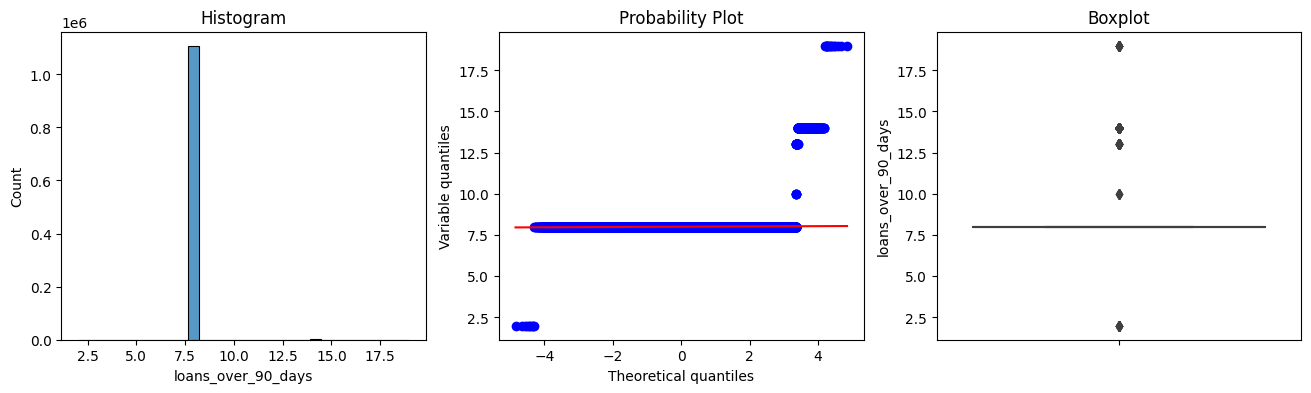

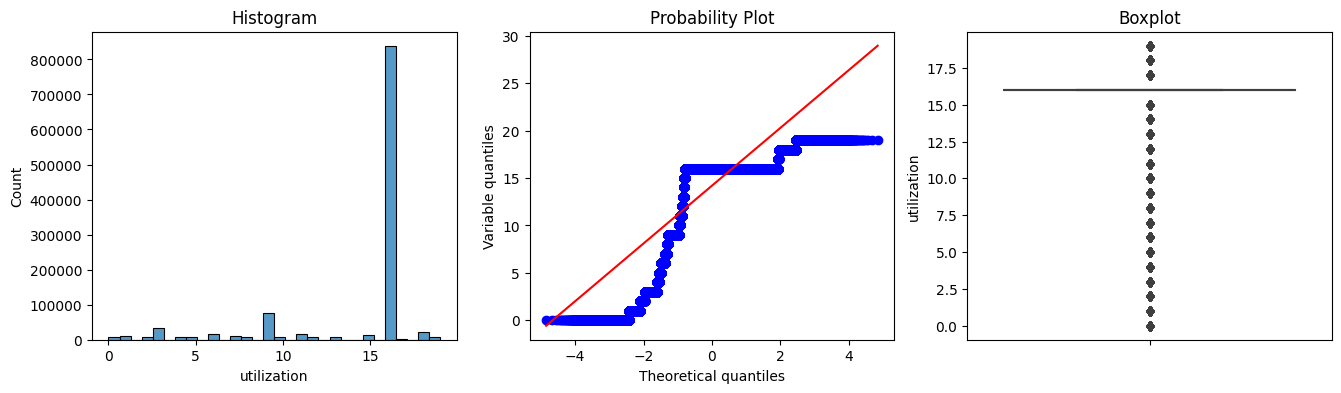

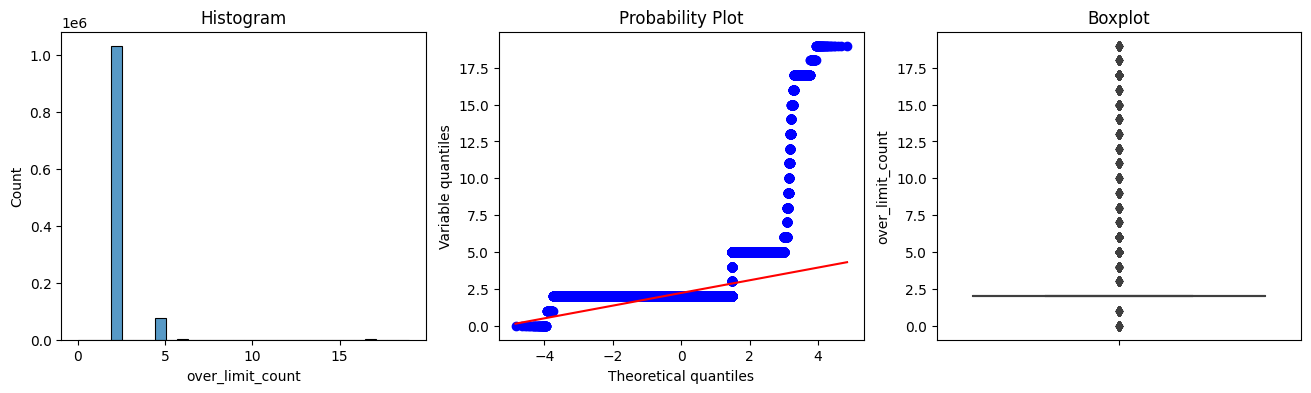

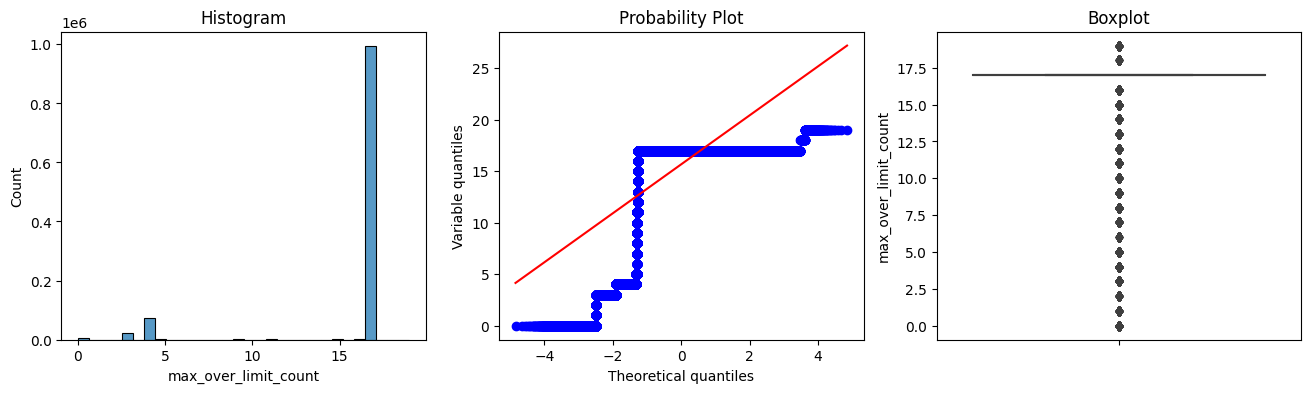

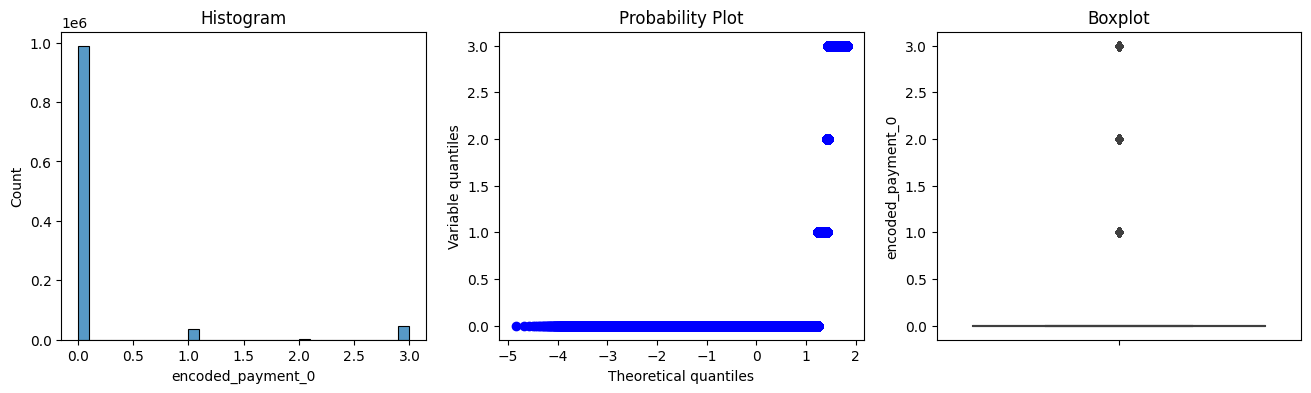

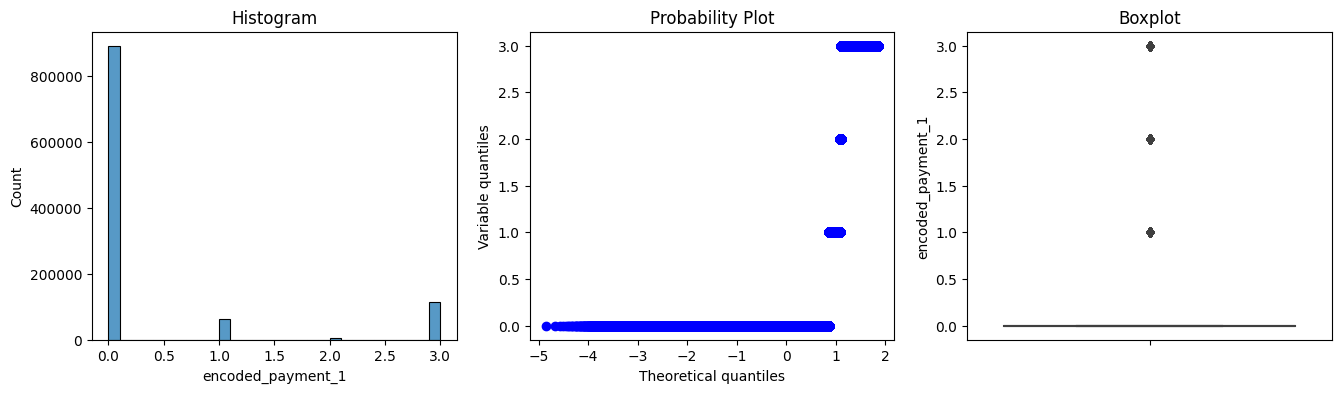

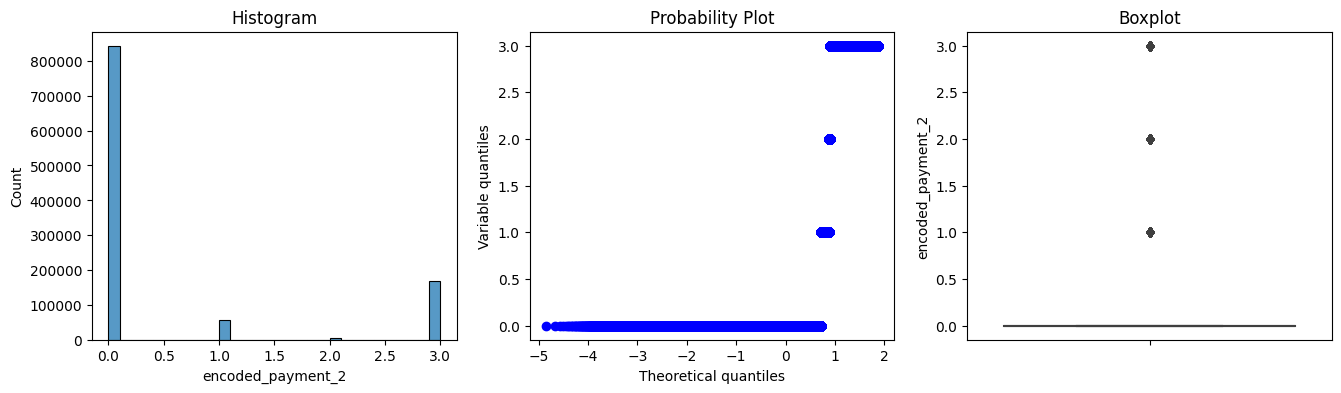

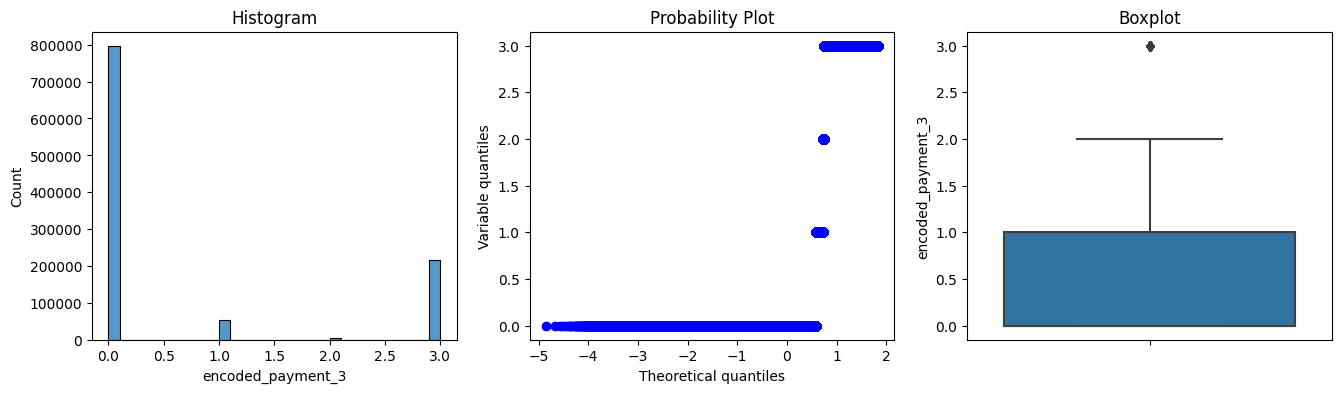

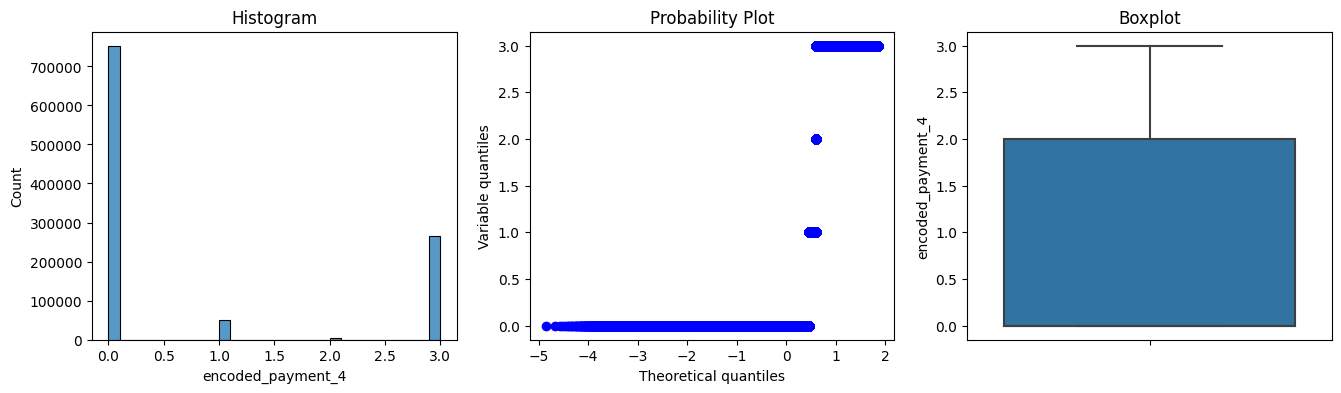

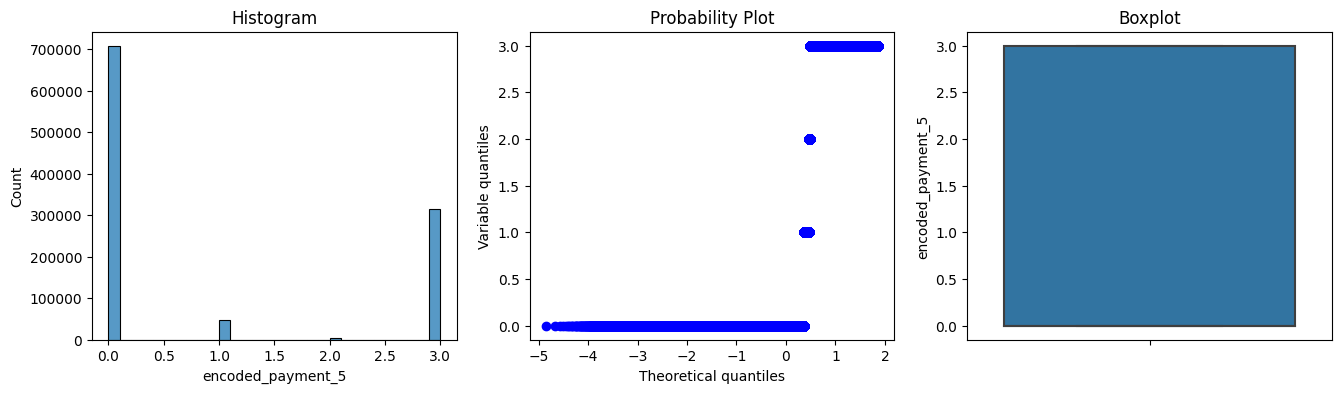

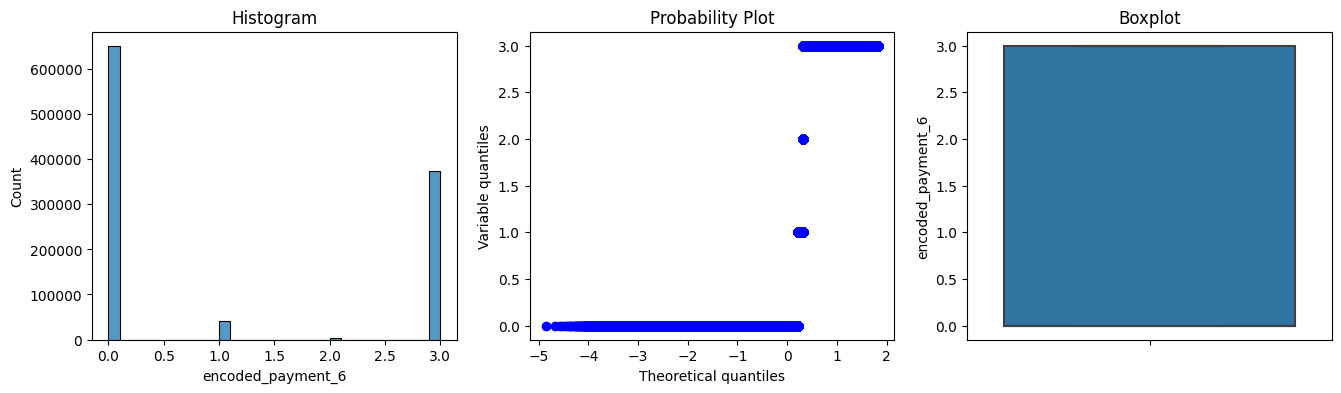

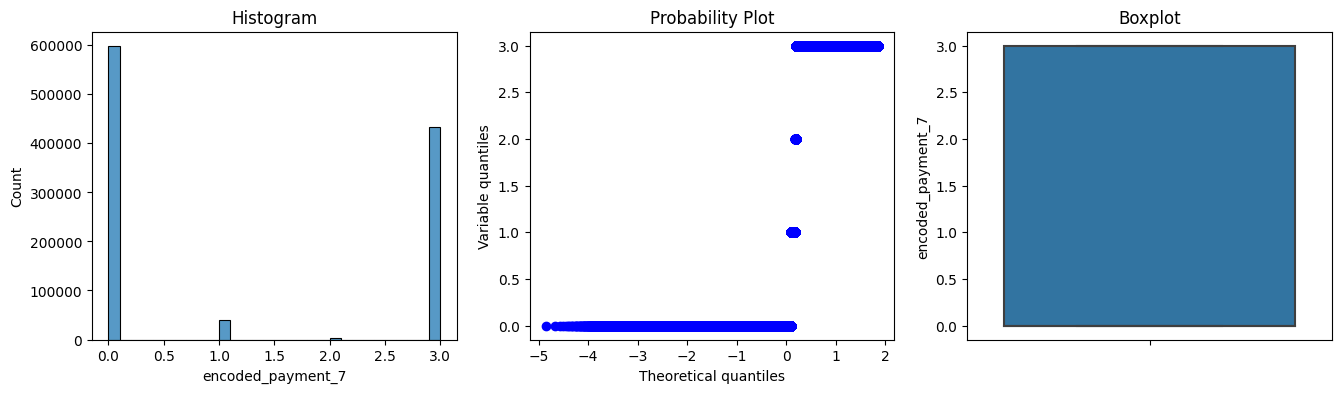

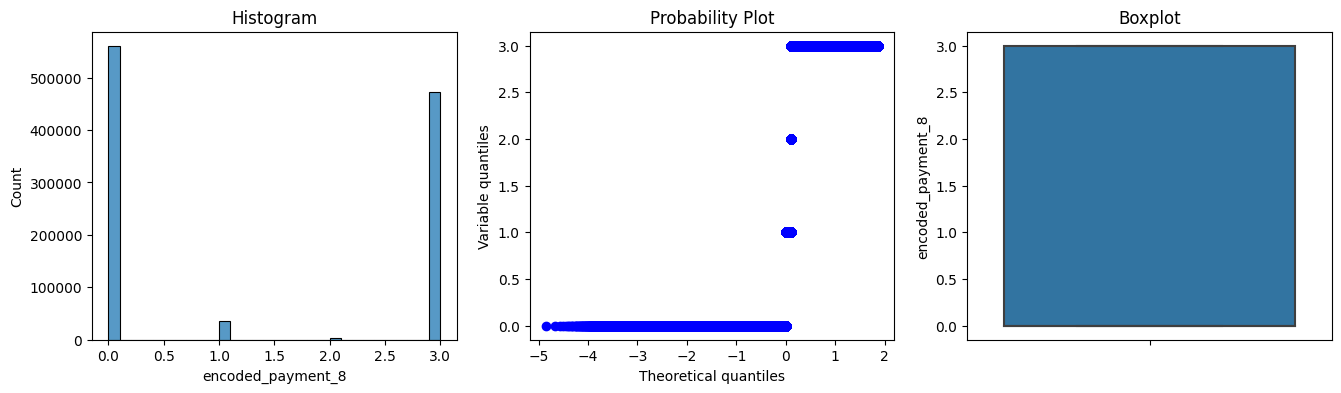

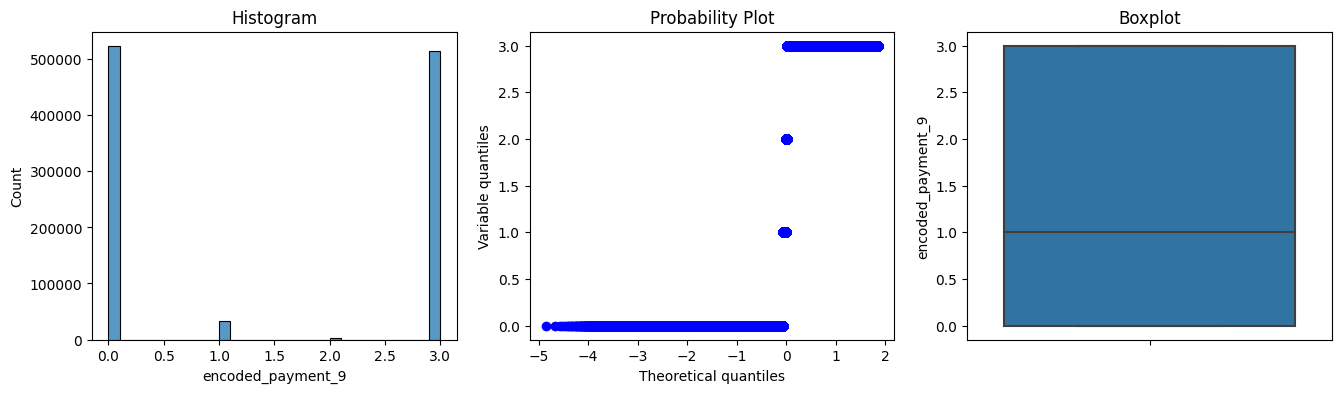

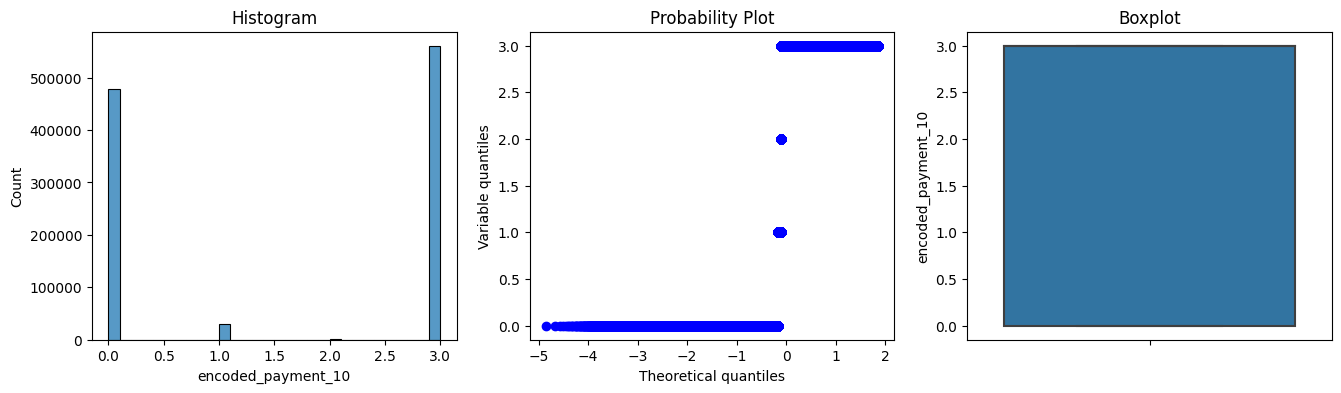

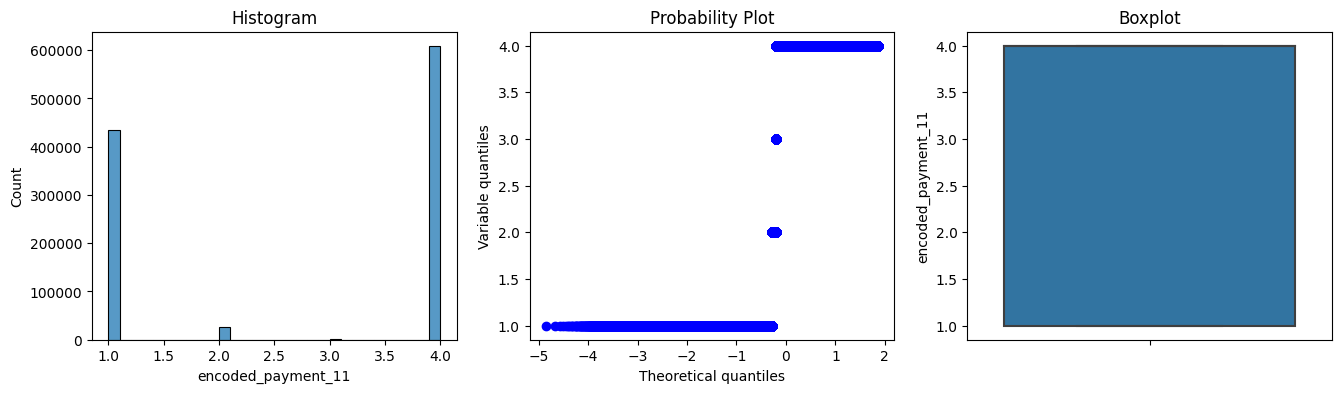

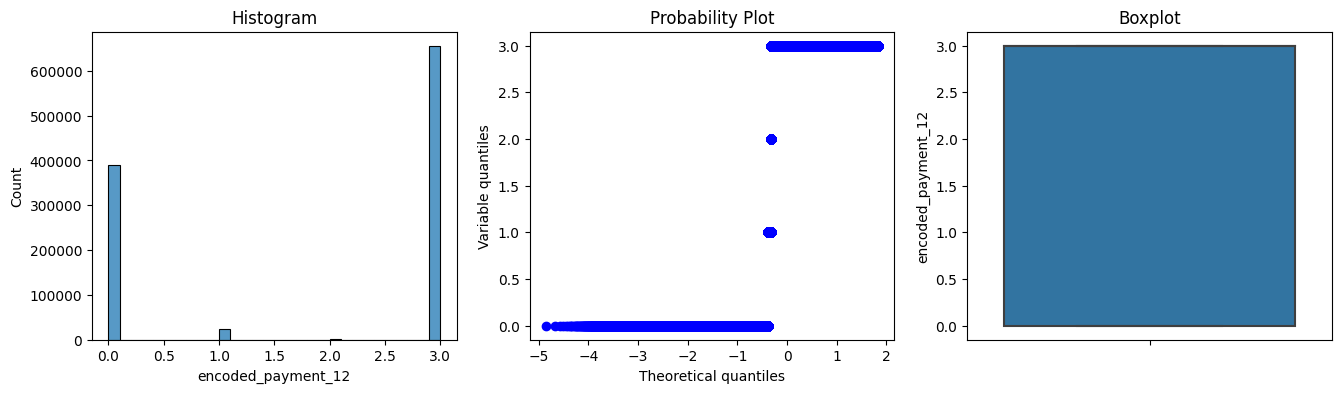

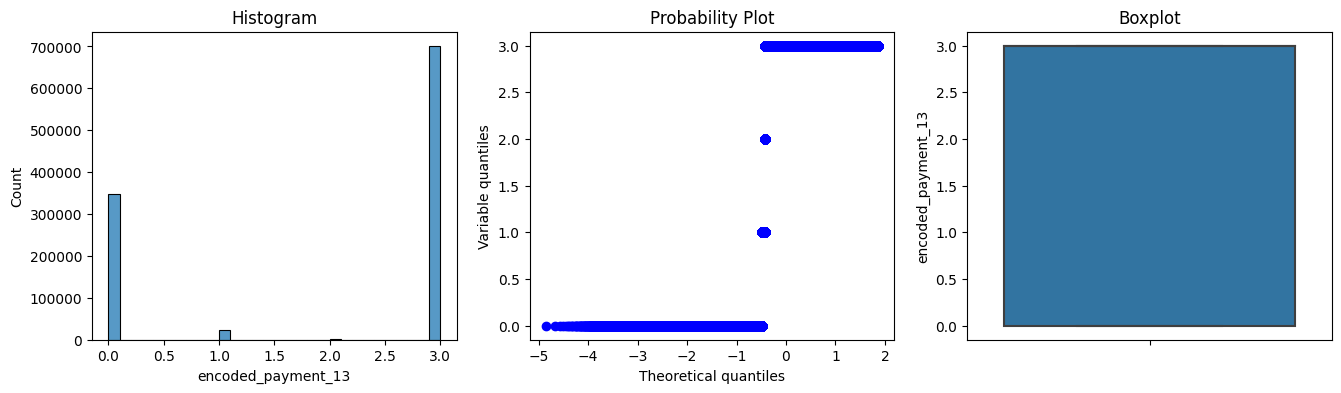

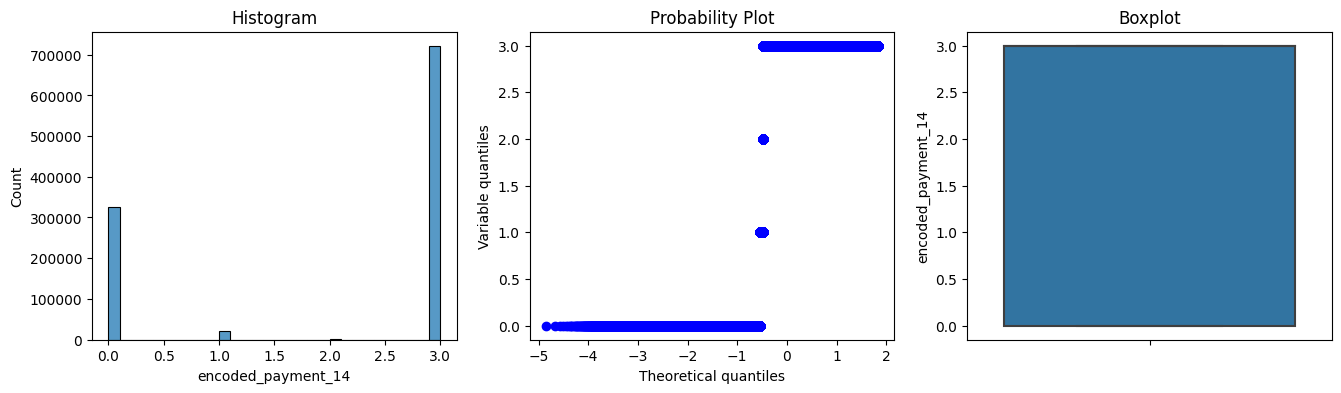

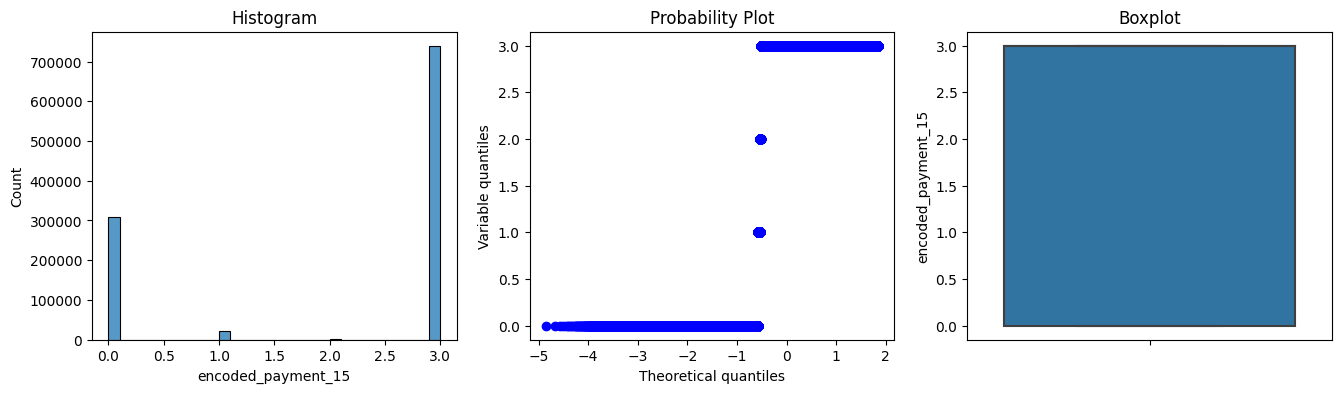

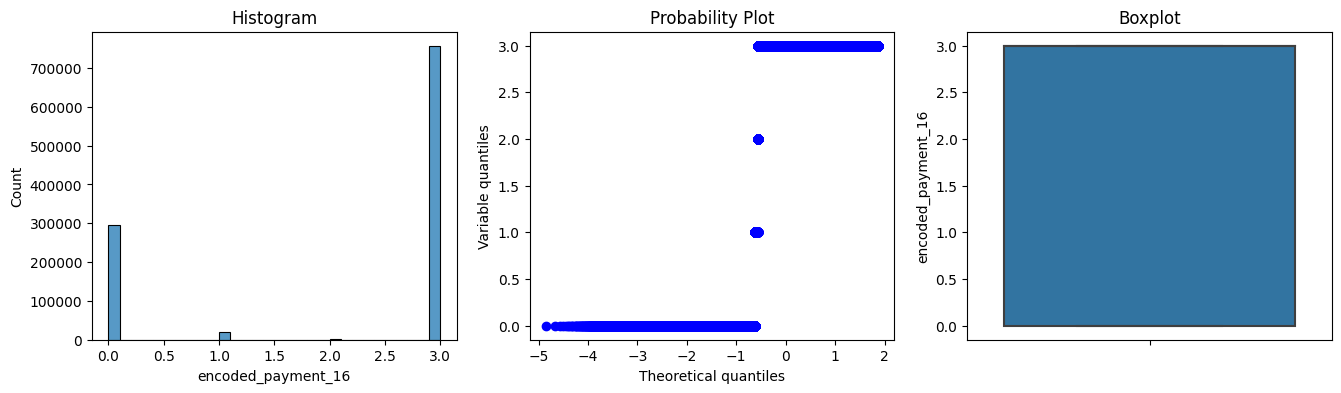

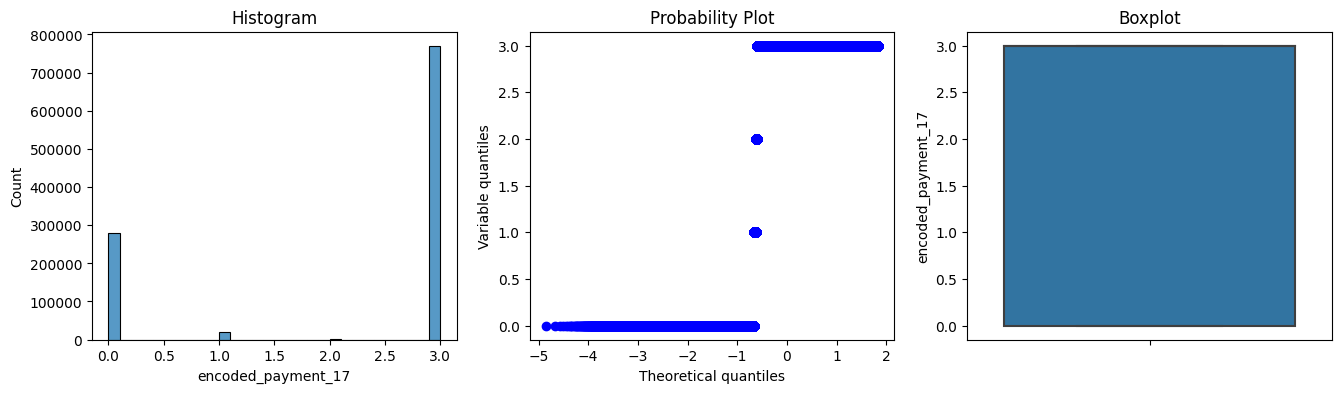

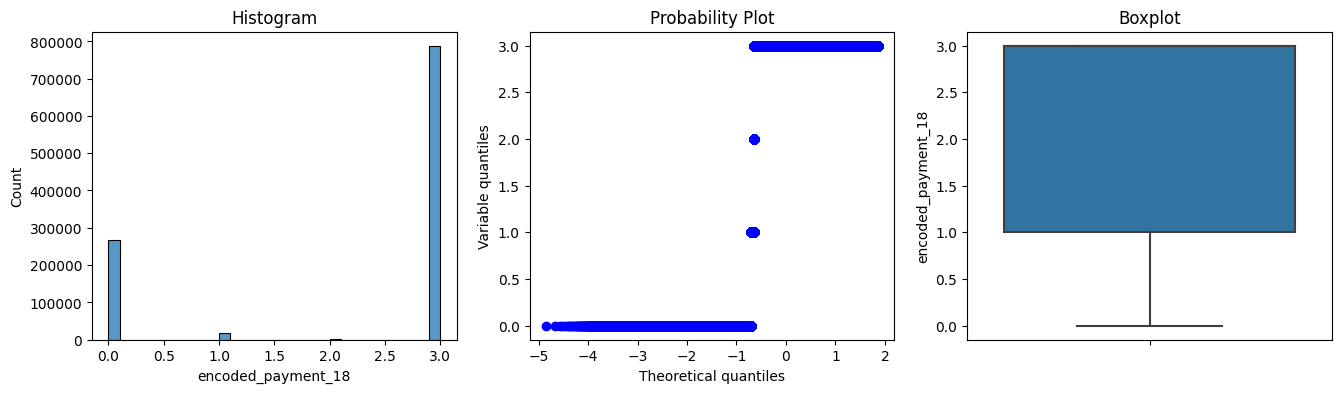

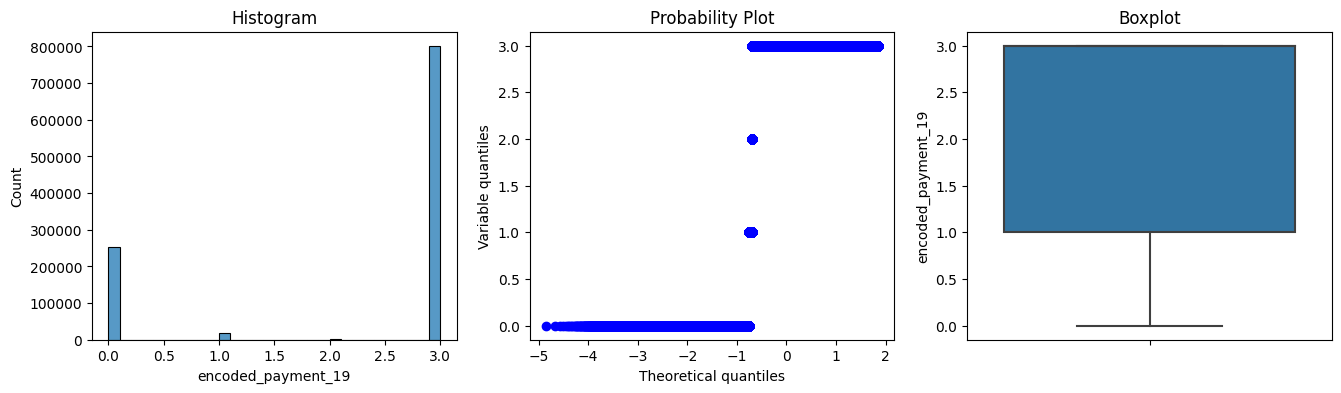

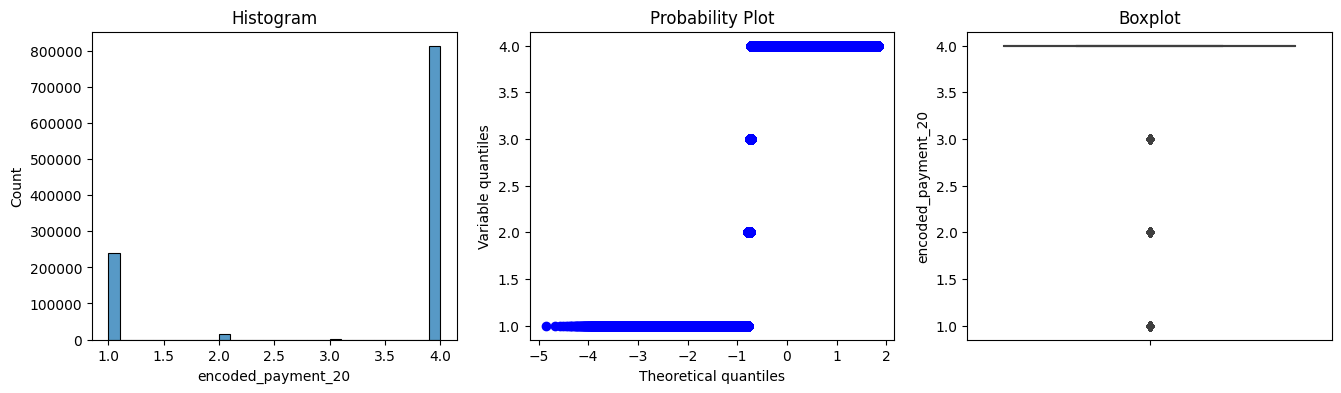

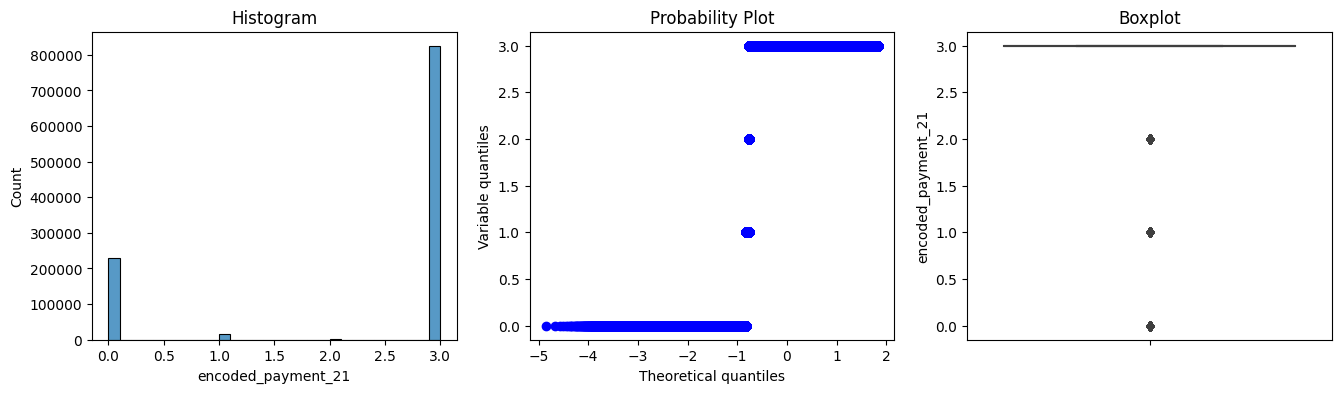

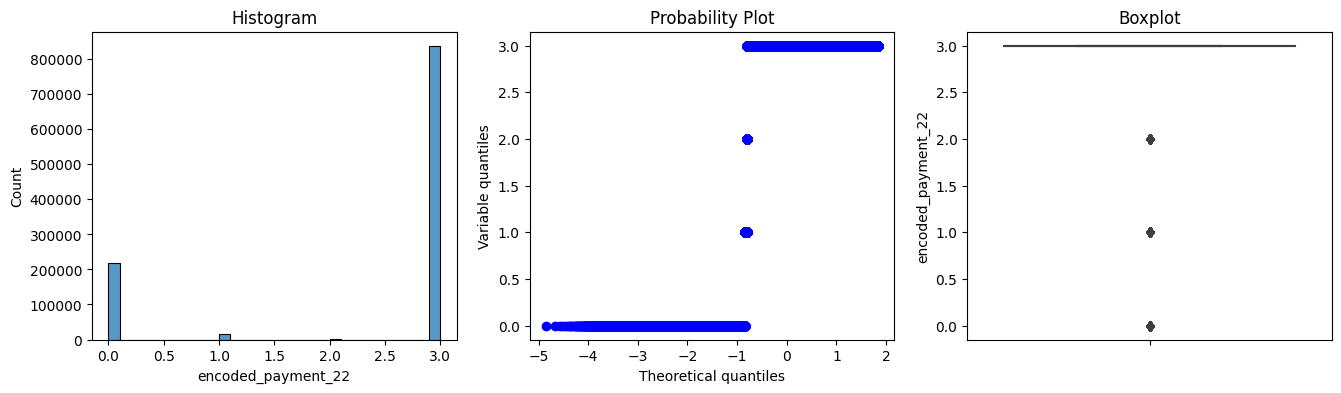

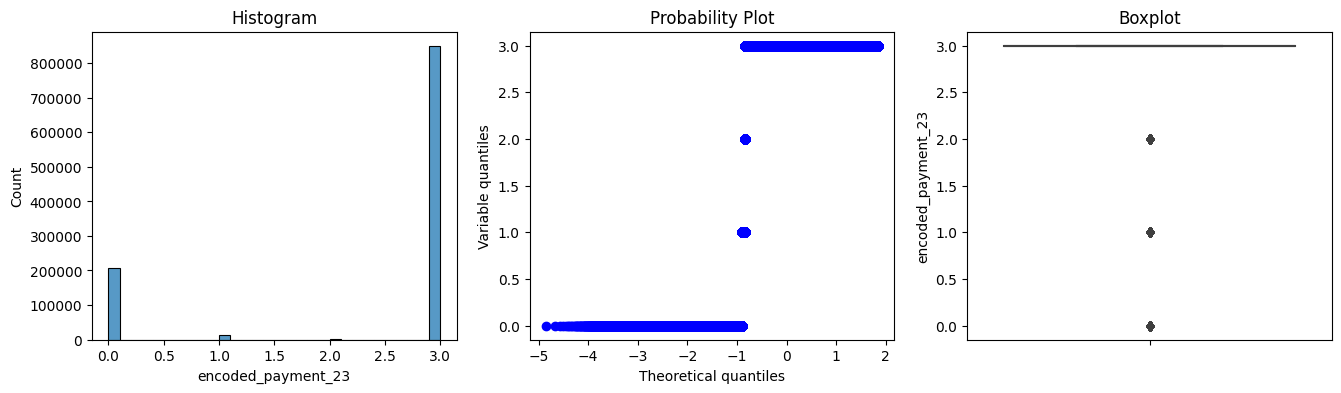

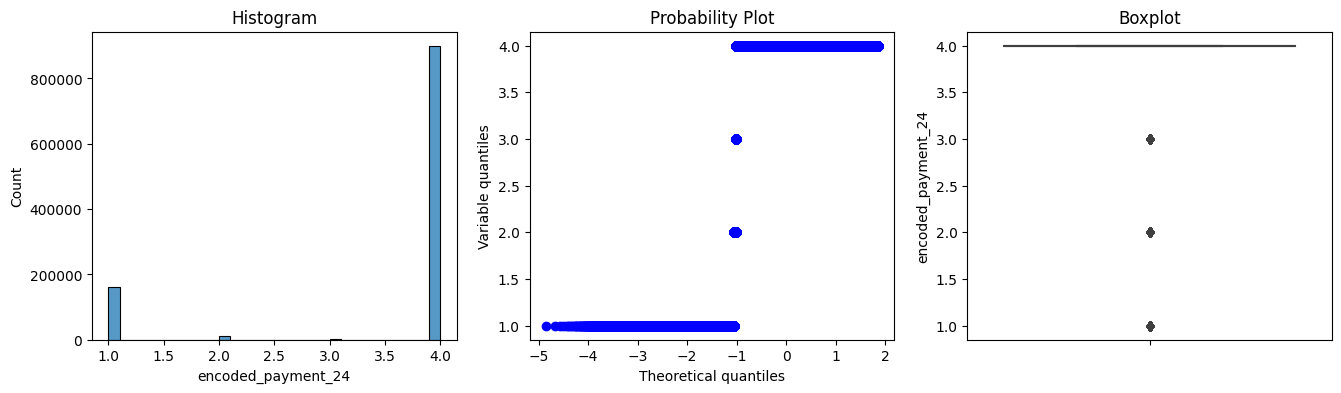

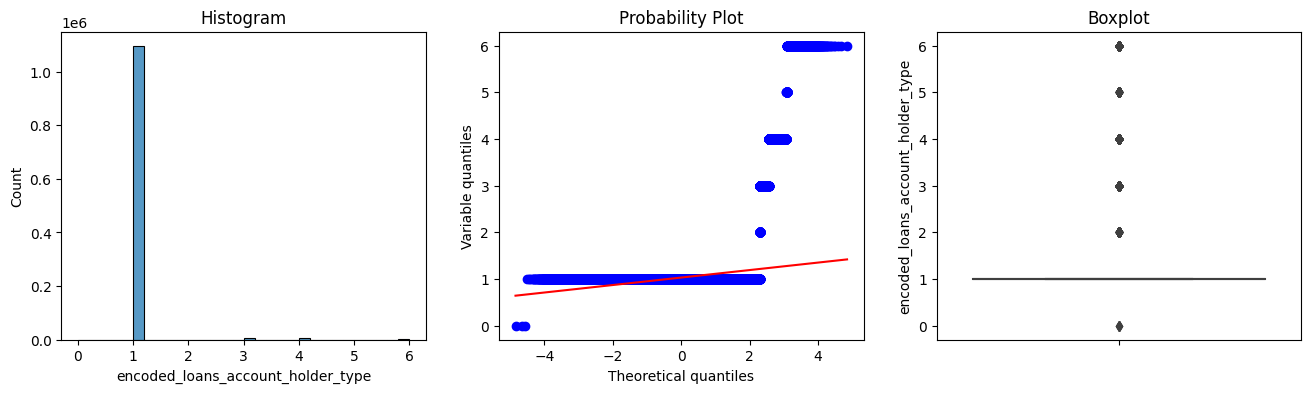

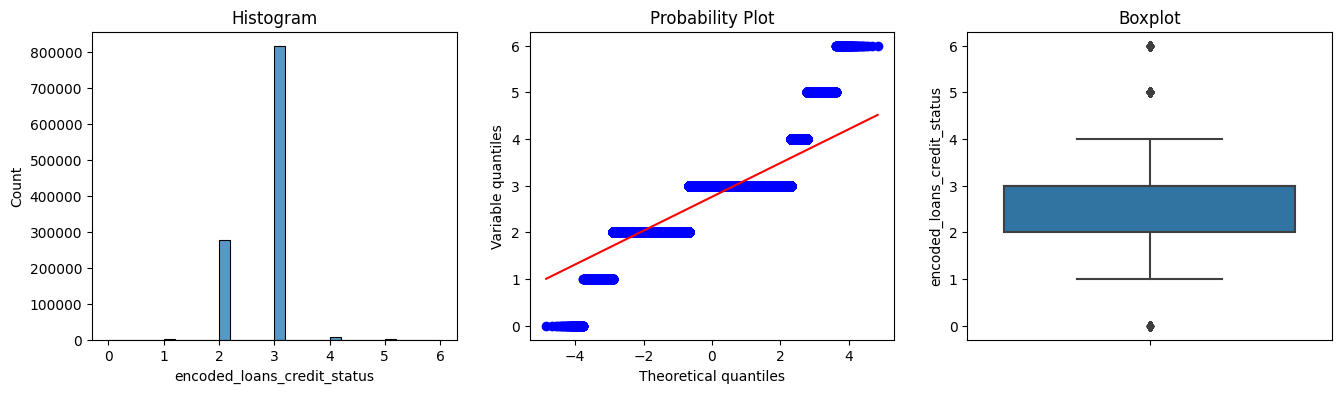

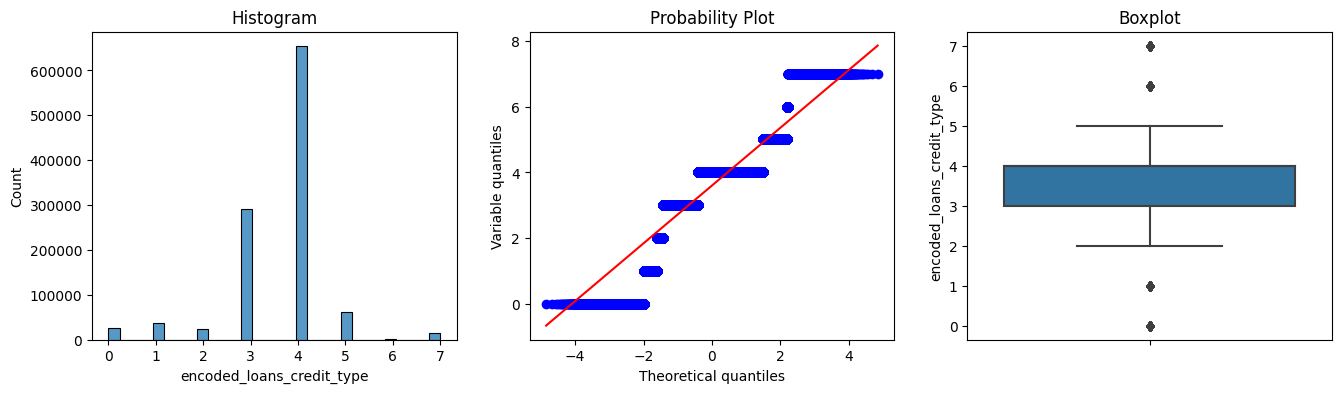

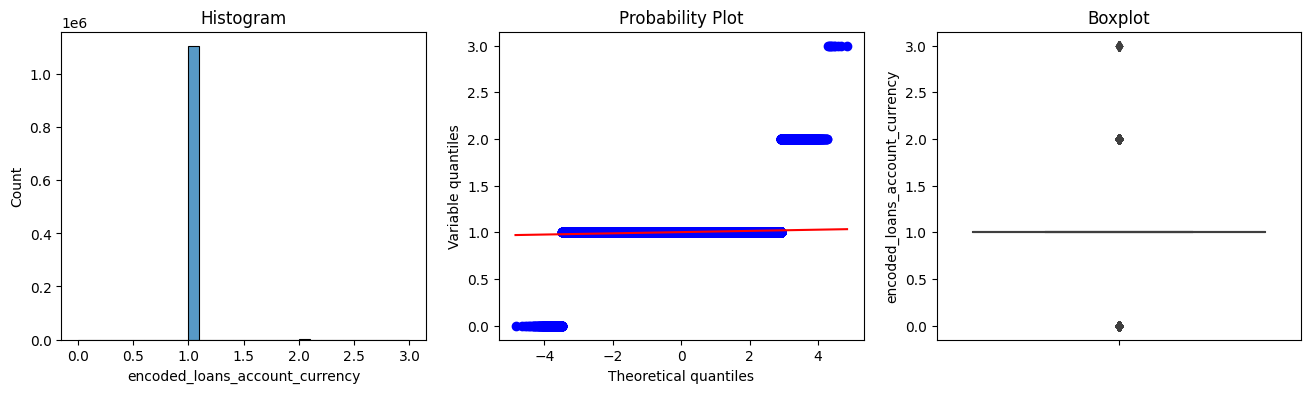

In [132]:
for col in num_ft_train:
    diagnostic_plots(train,col)

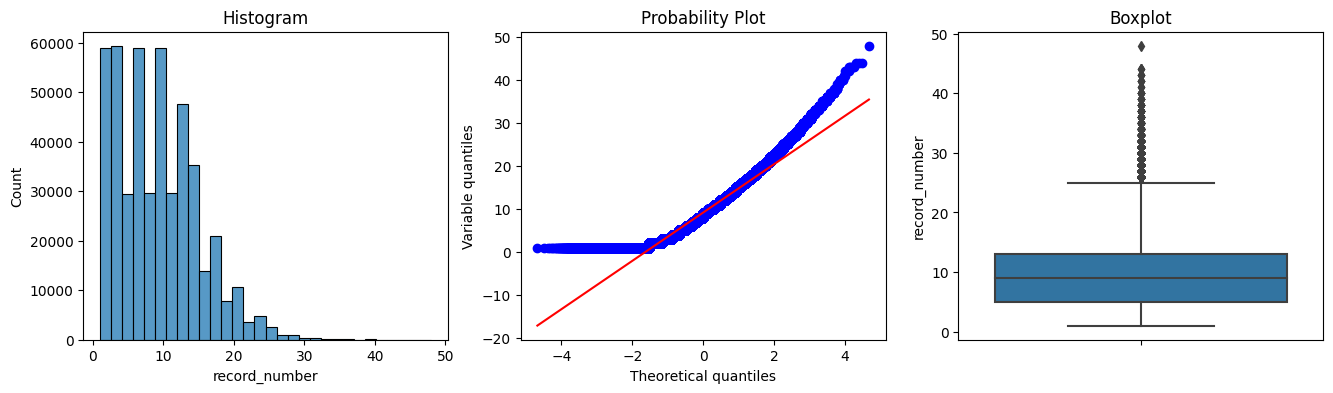

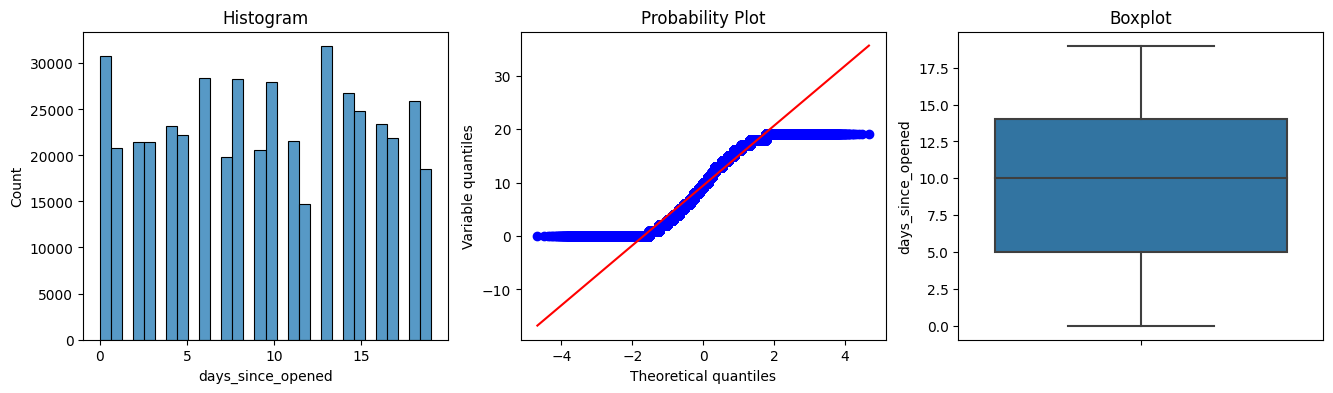

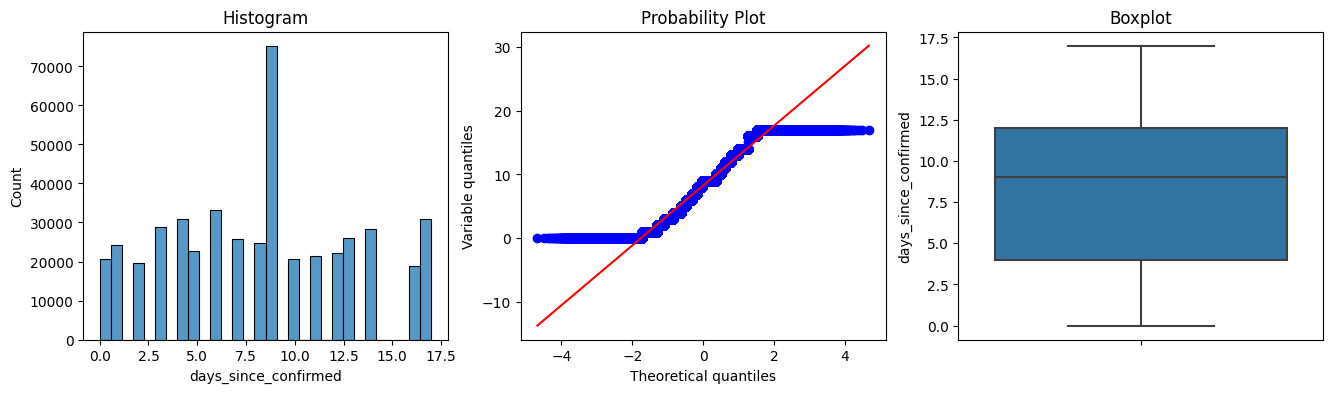

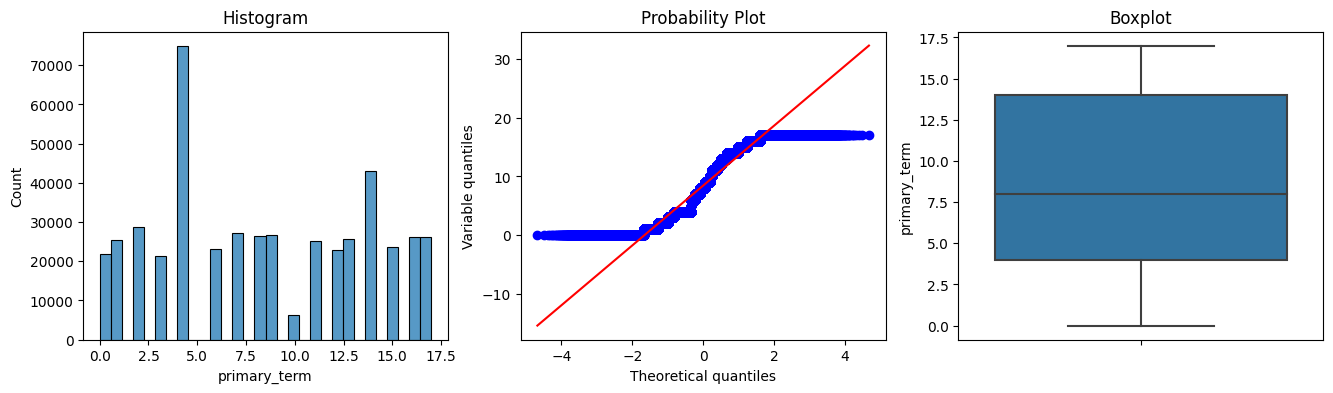

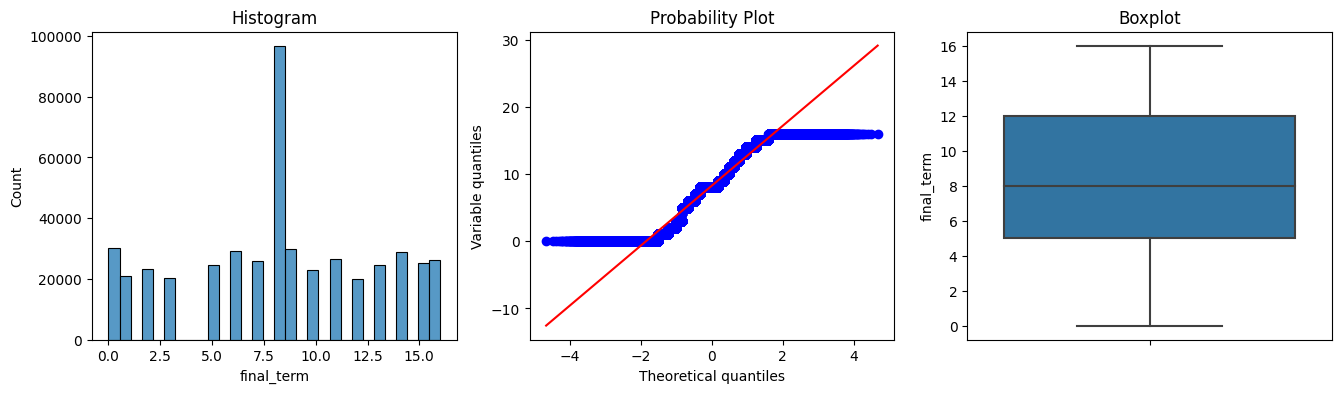

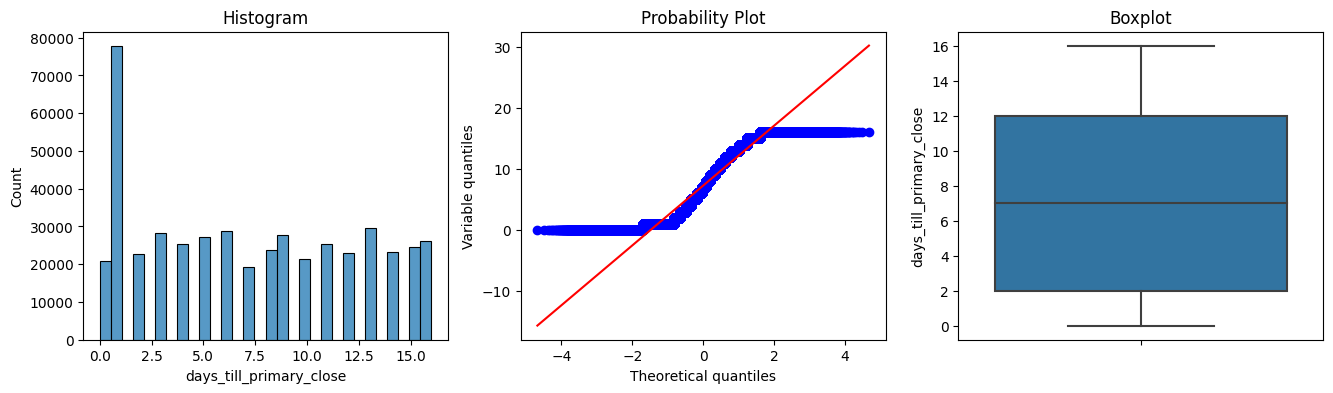

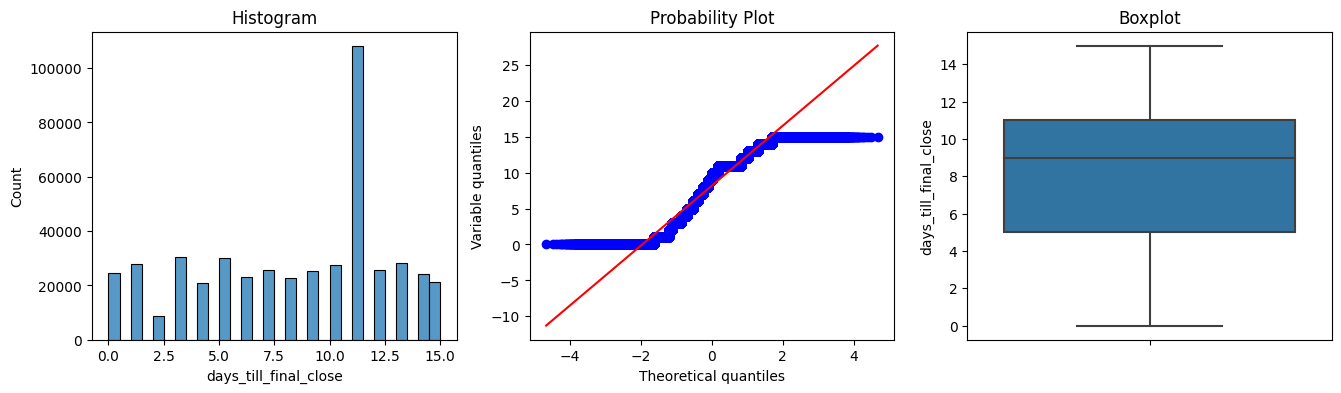

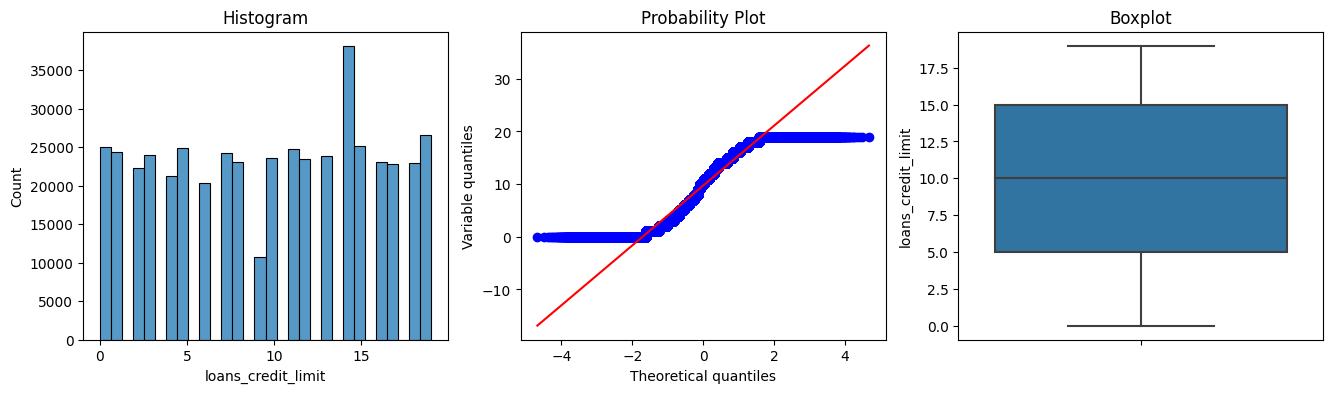

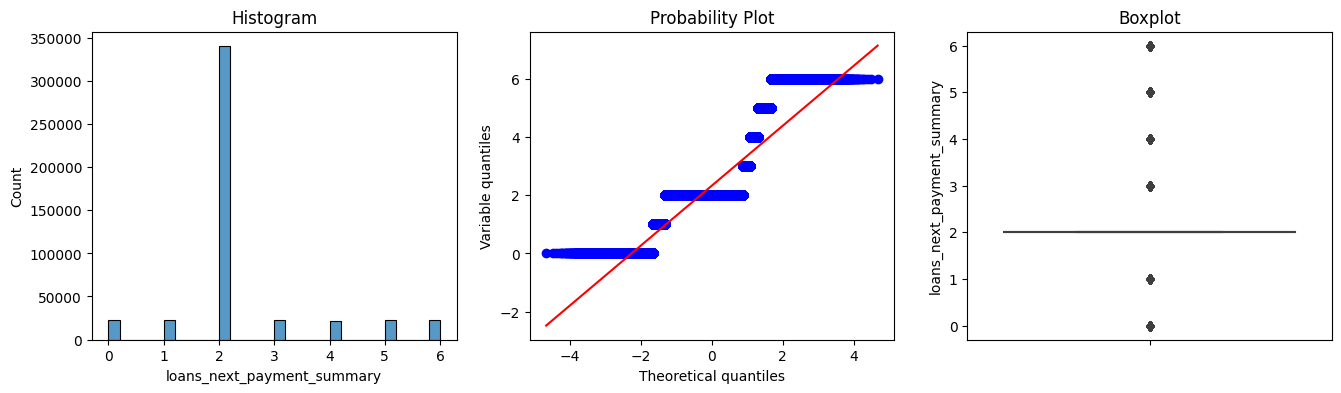

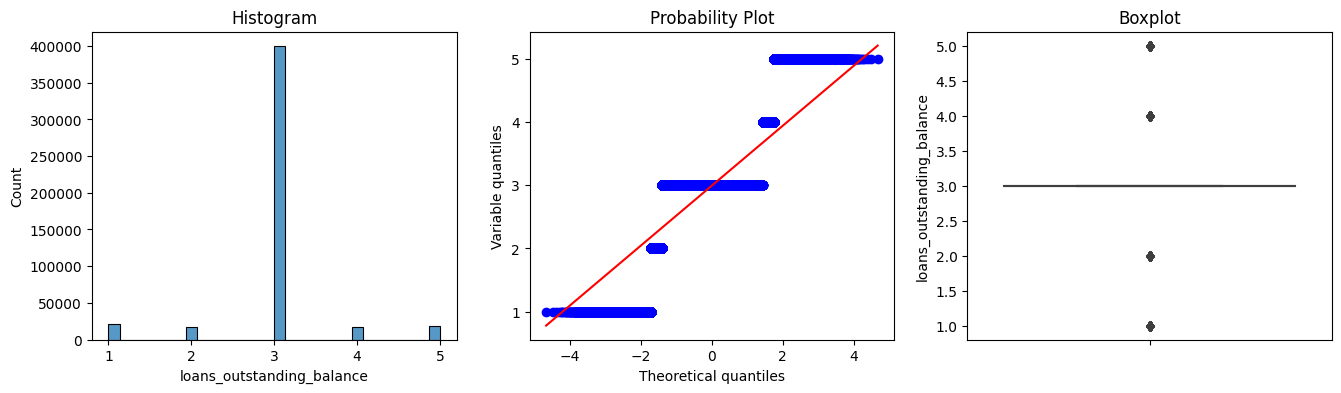

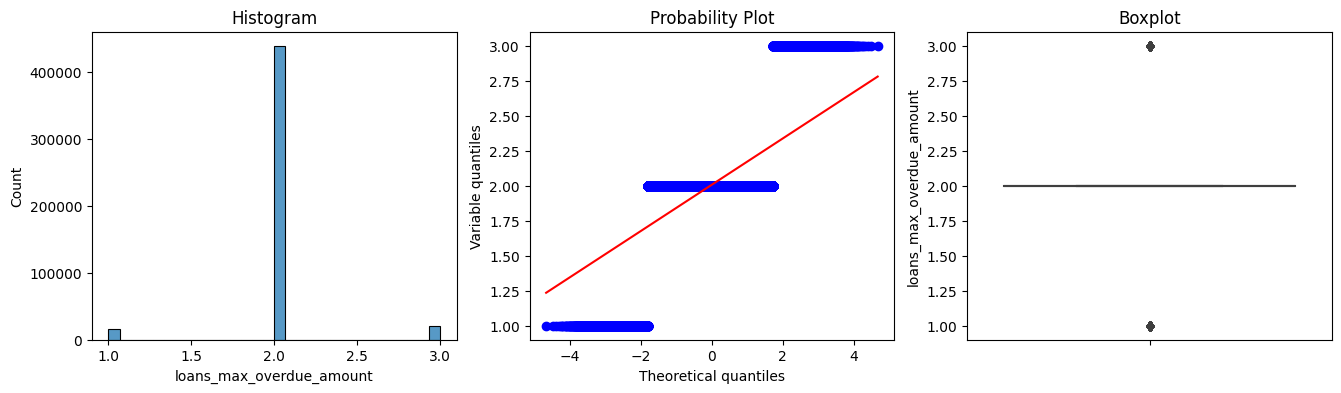

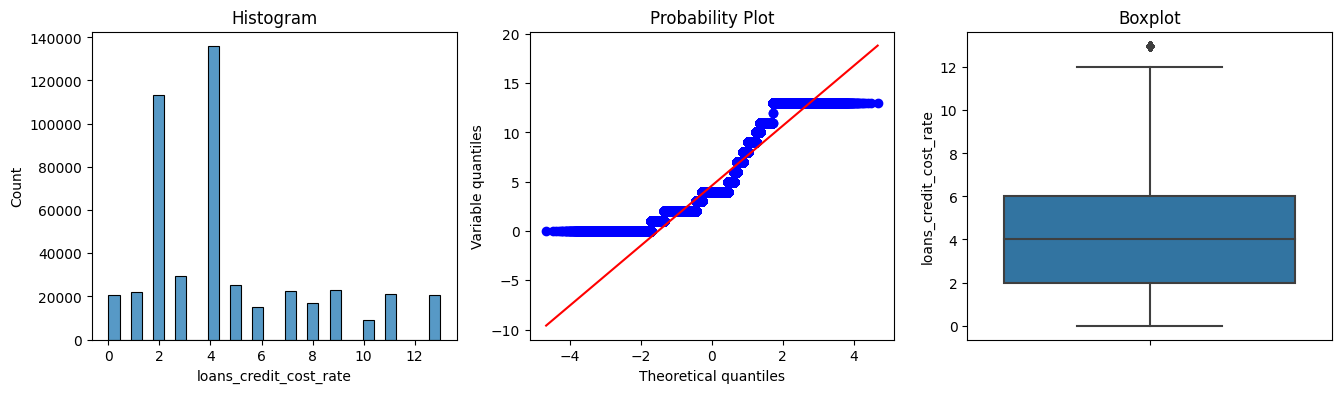

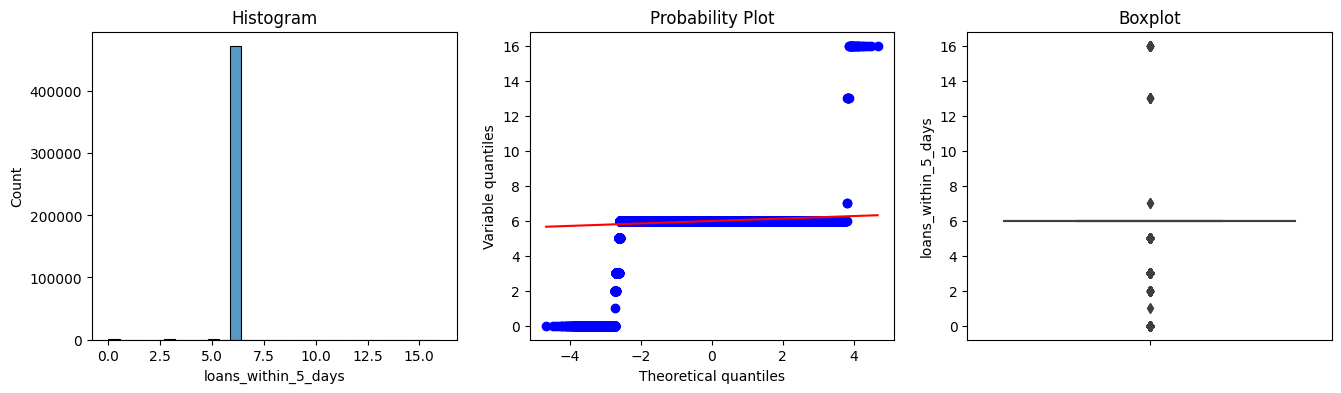

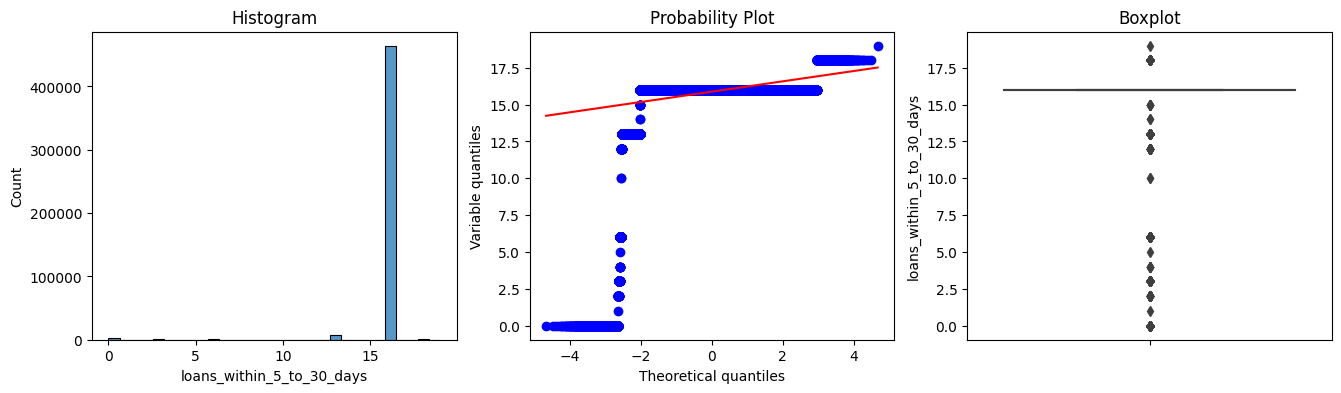

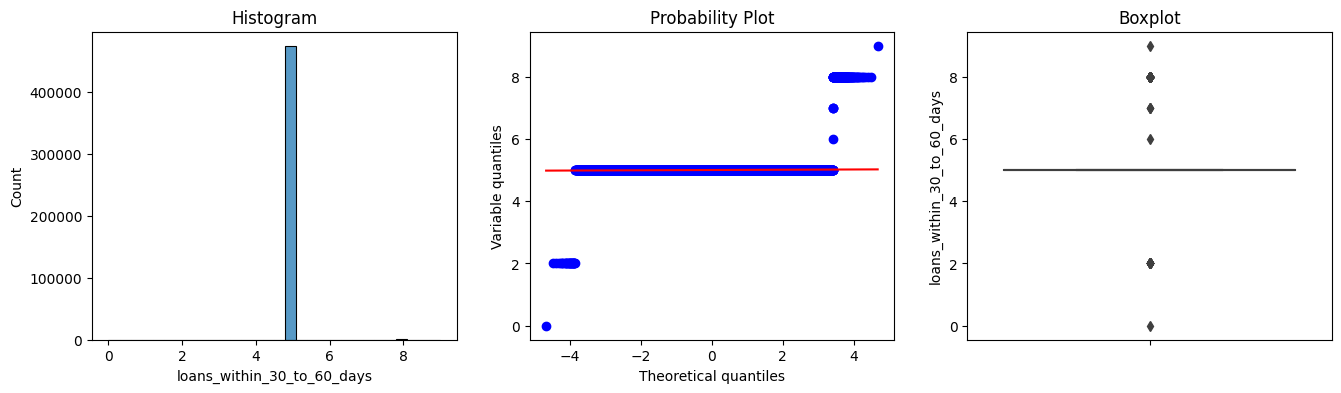

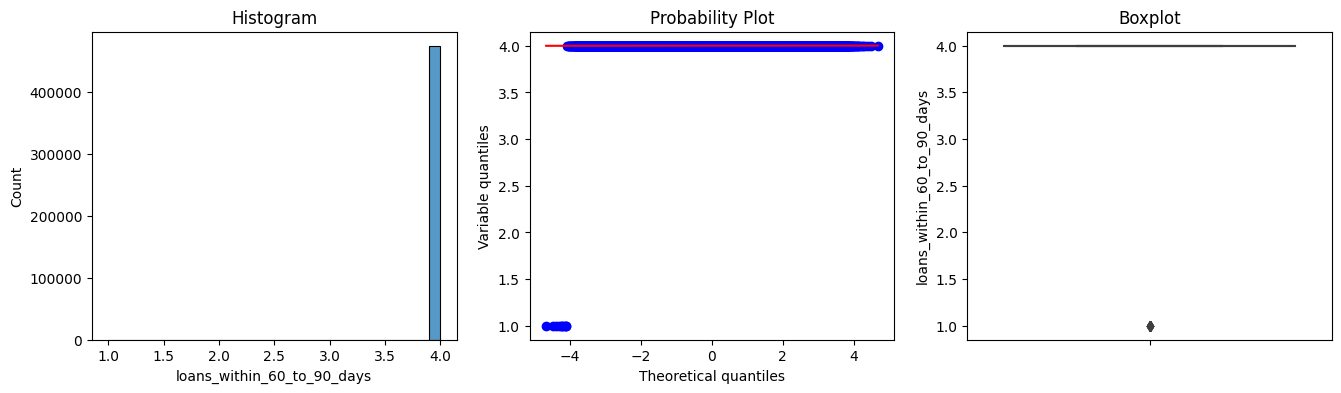

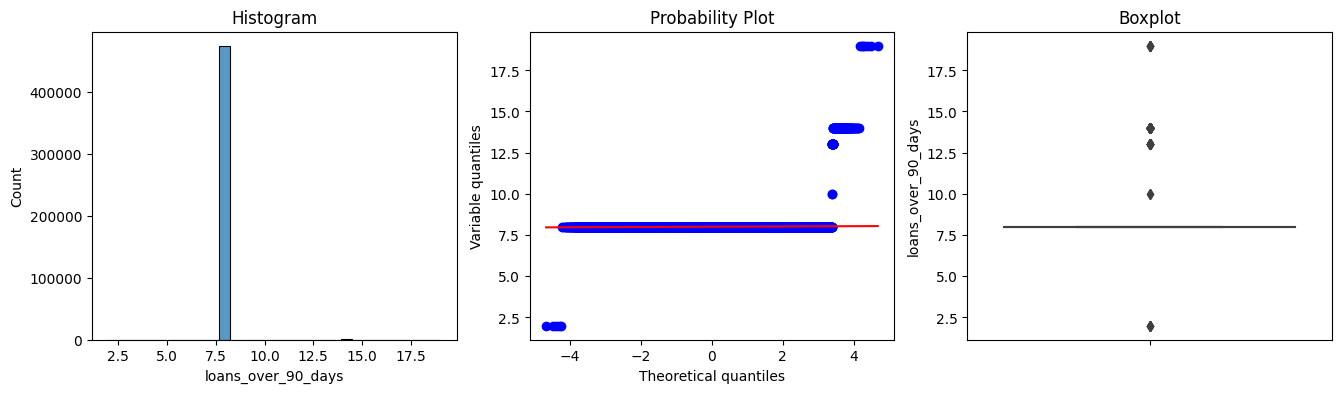

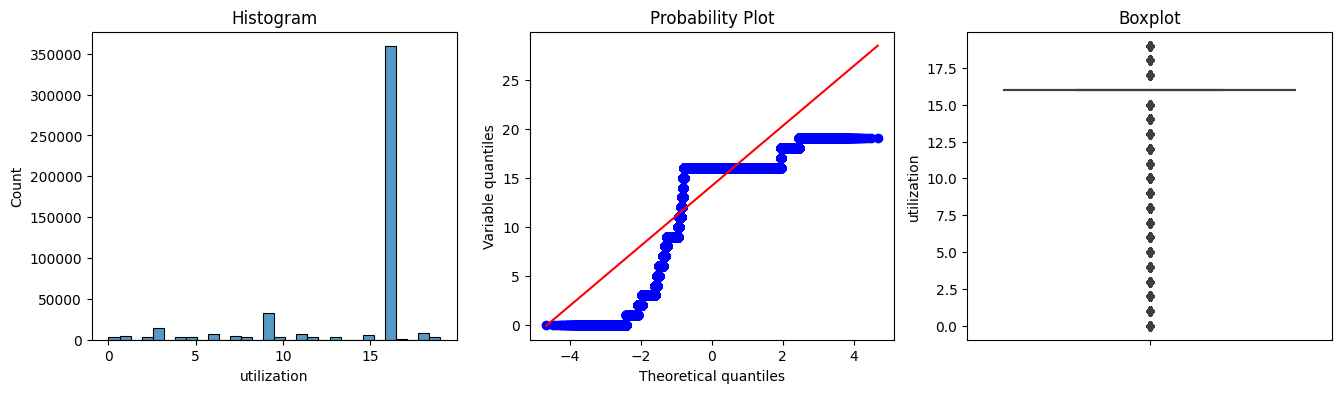

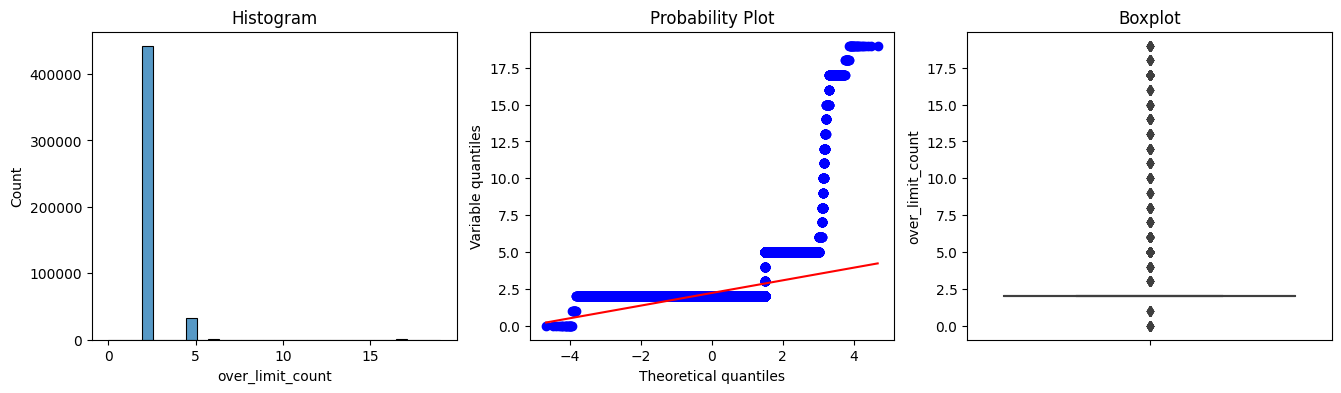

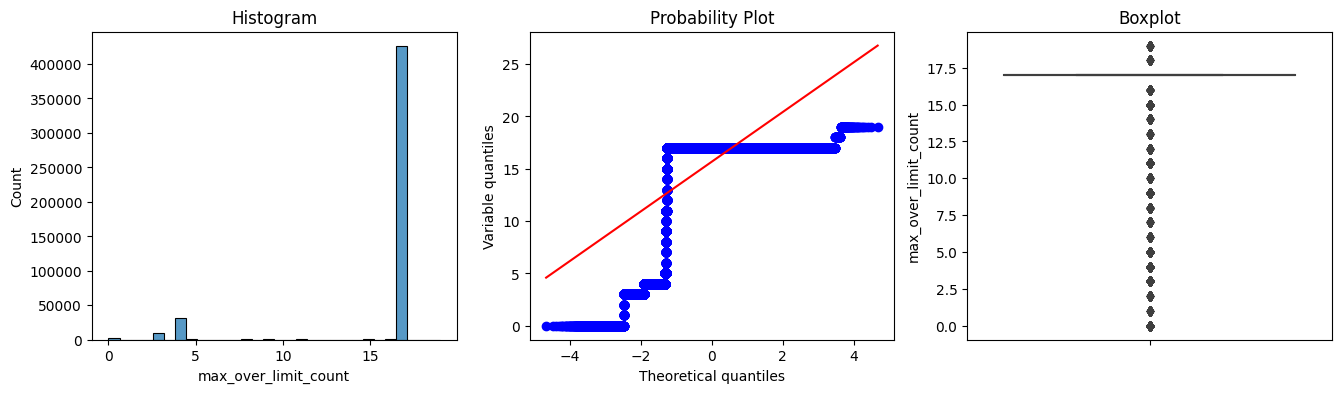

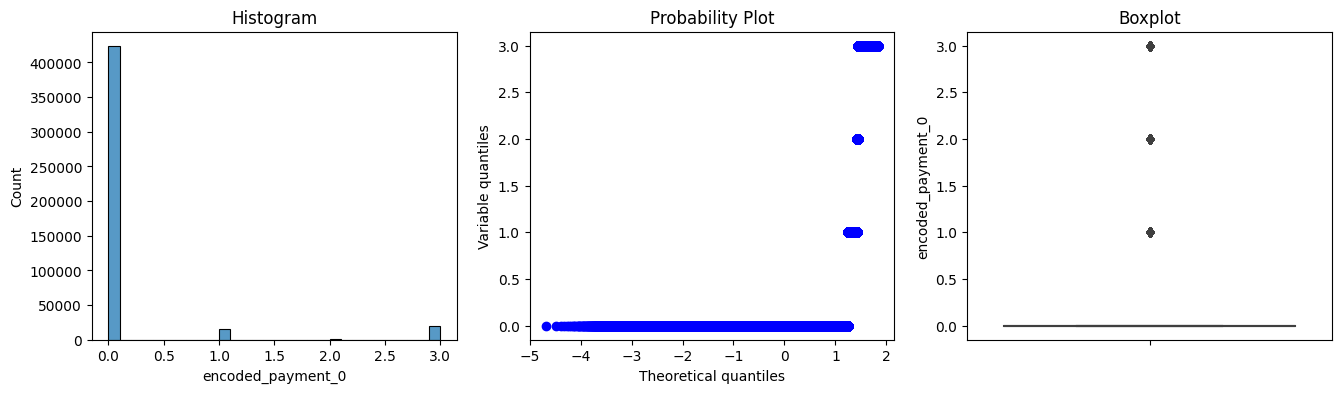

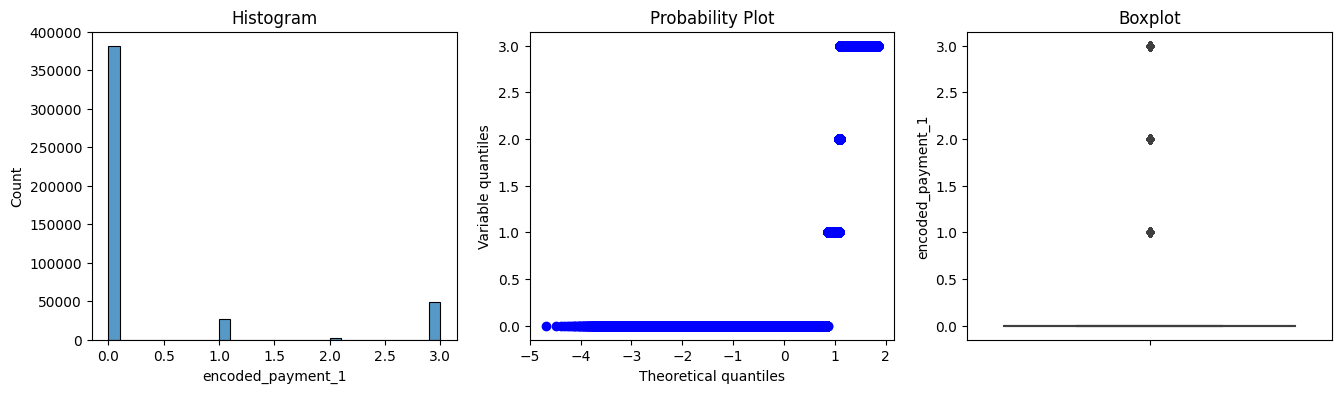

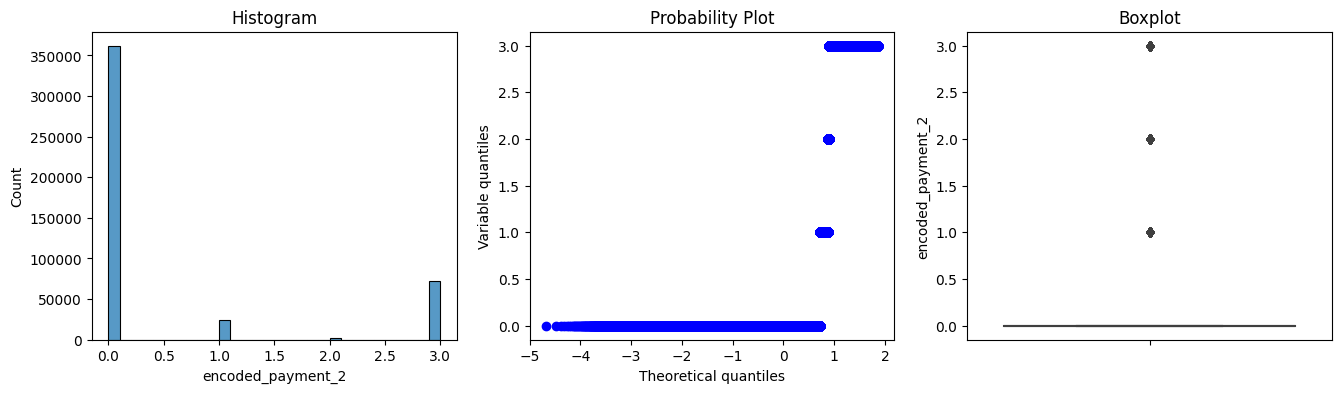

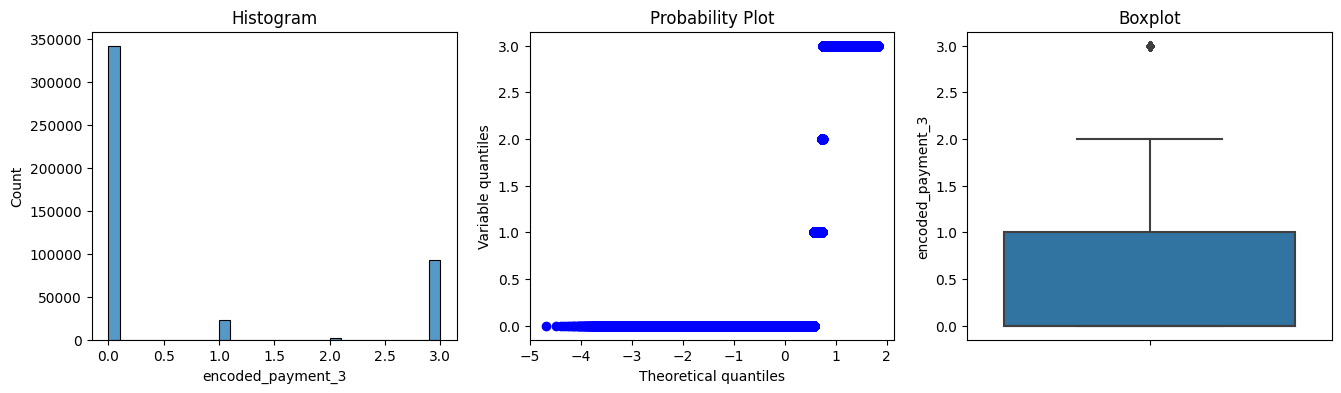

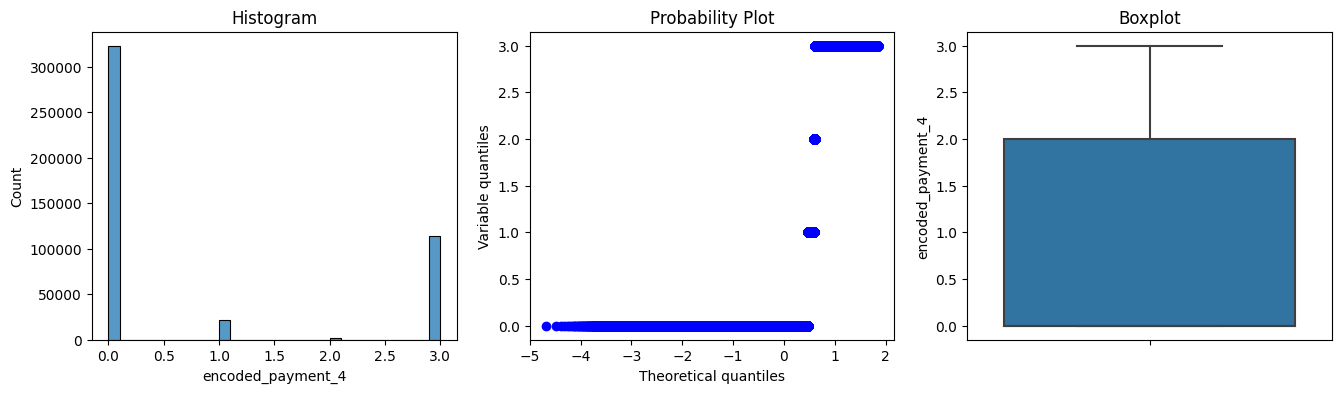

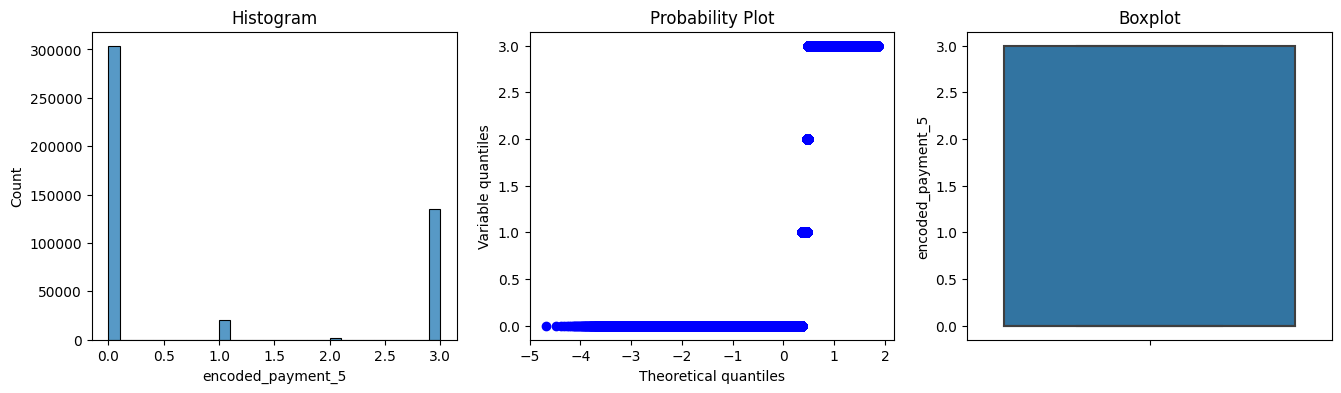

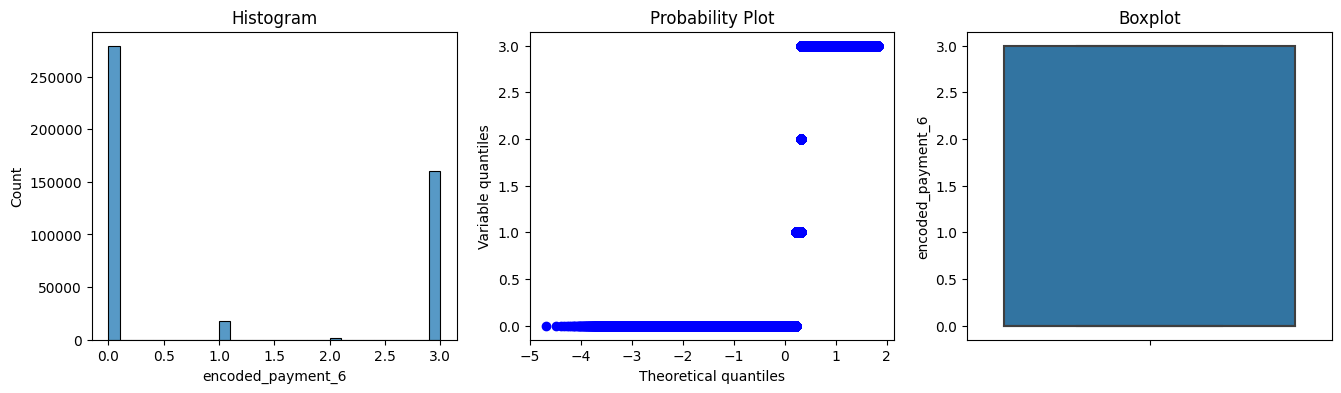

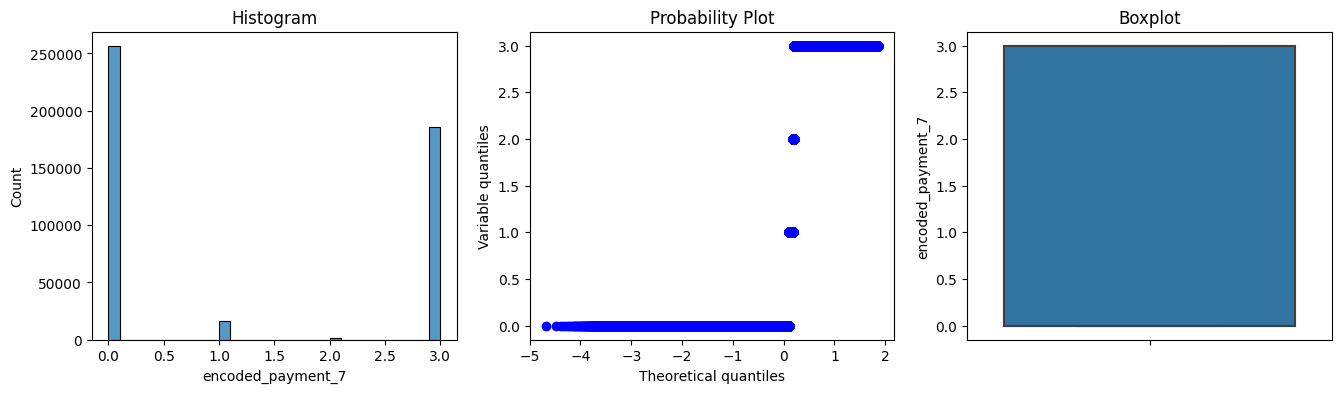

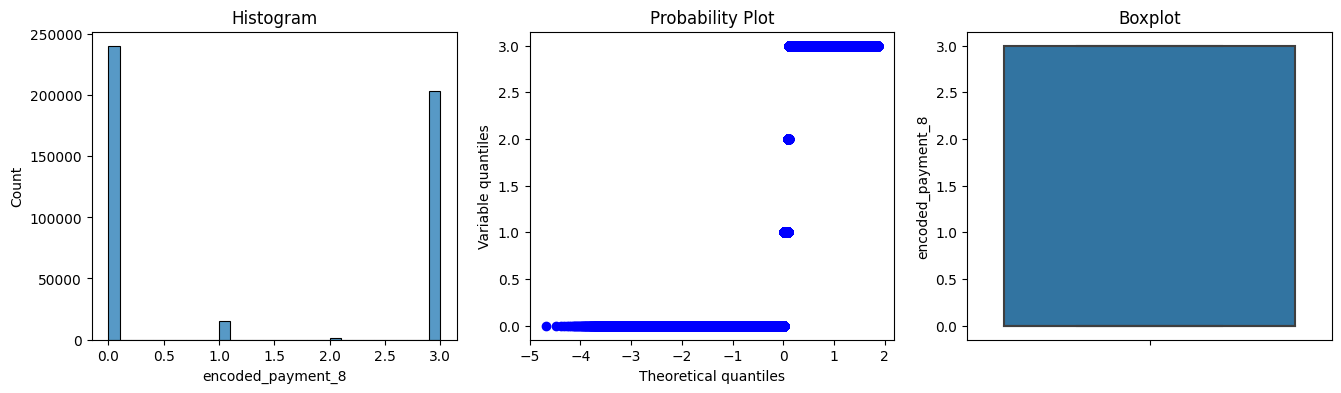

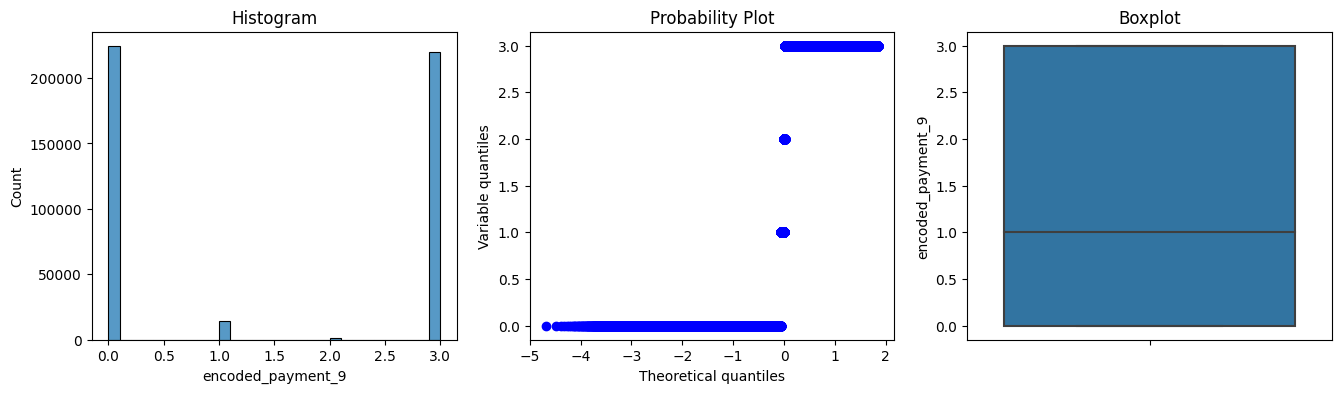

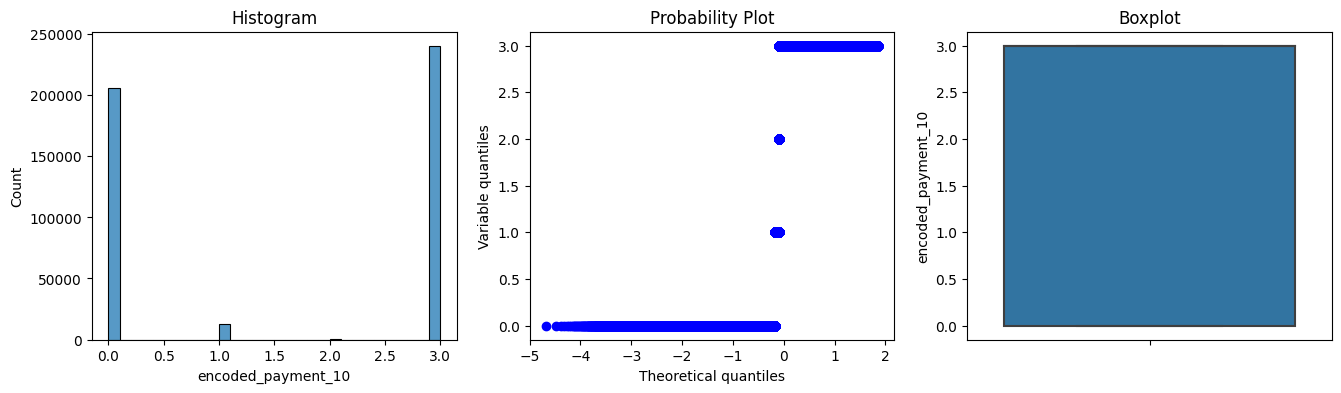

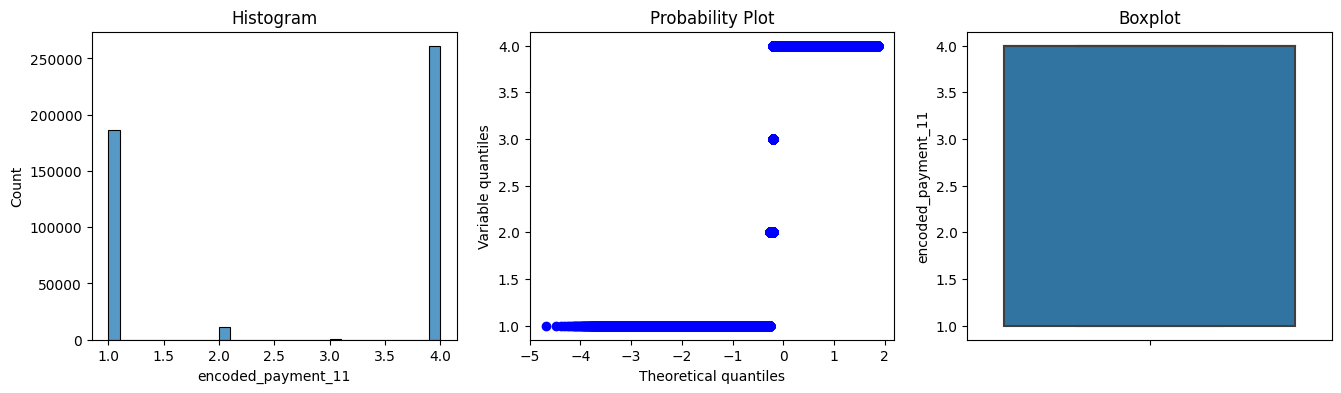

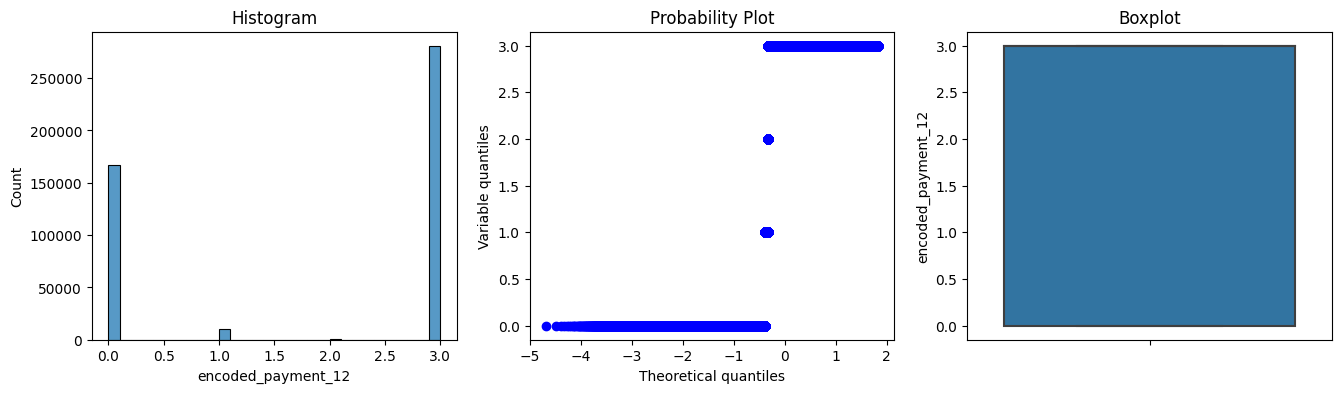

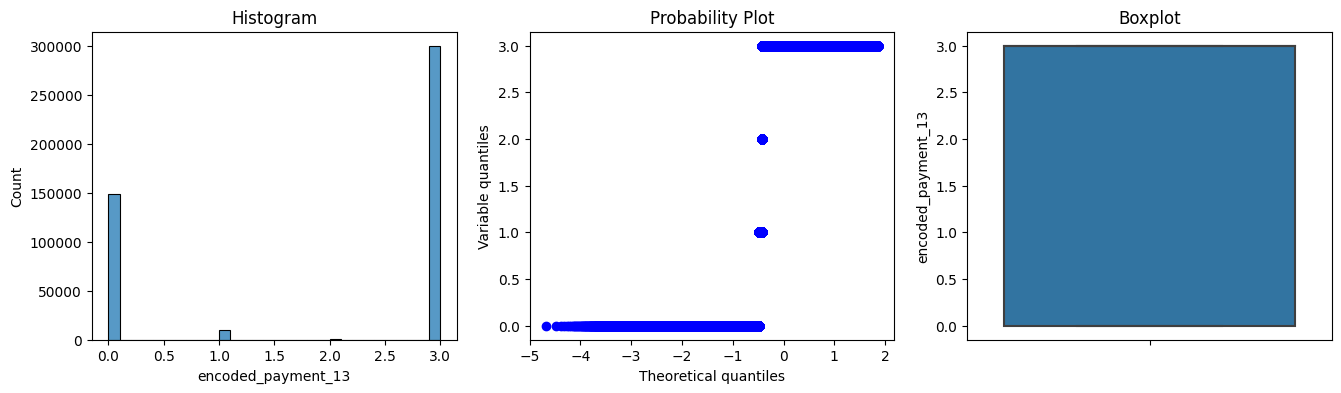

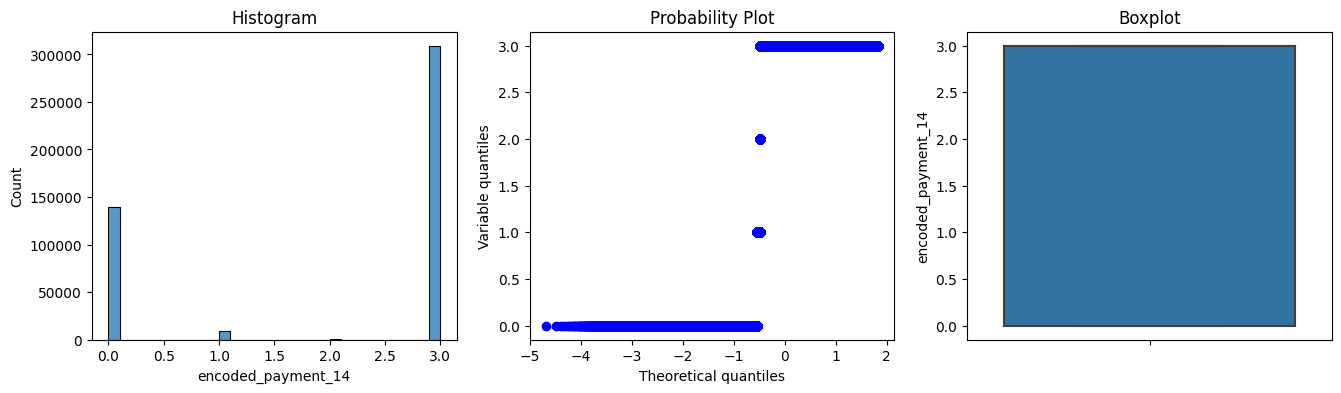

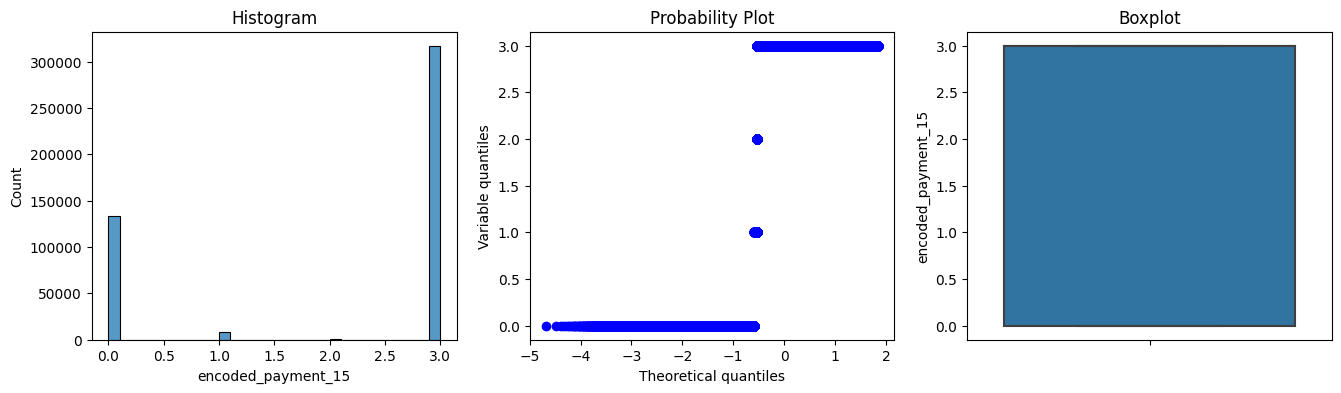

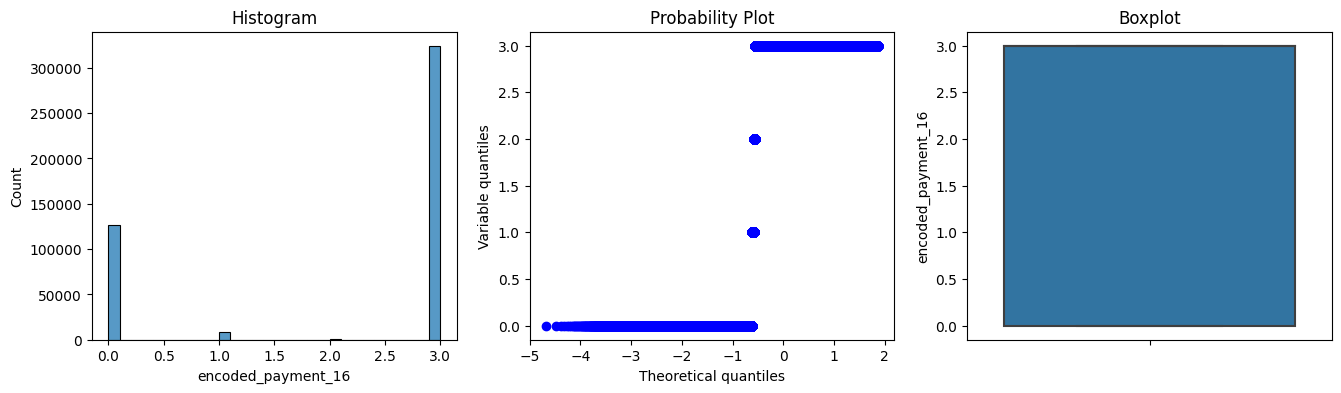

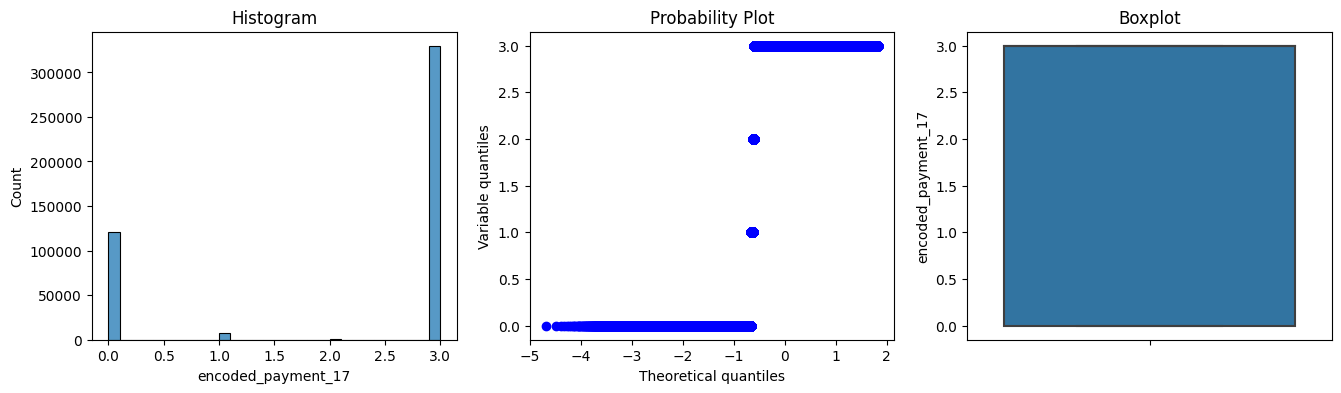

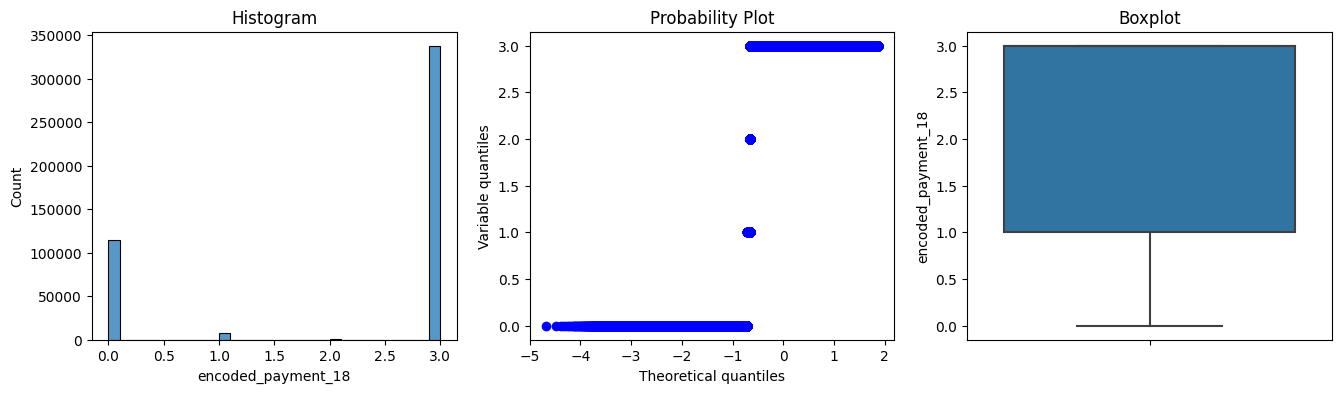

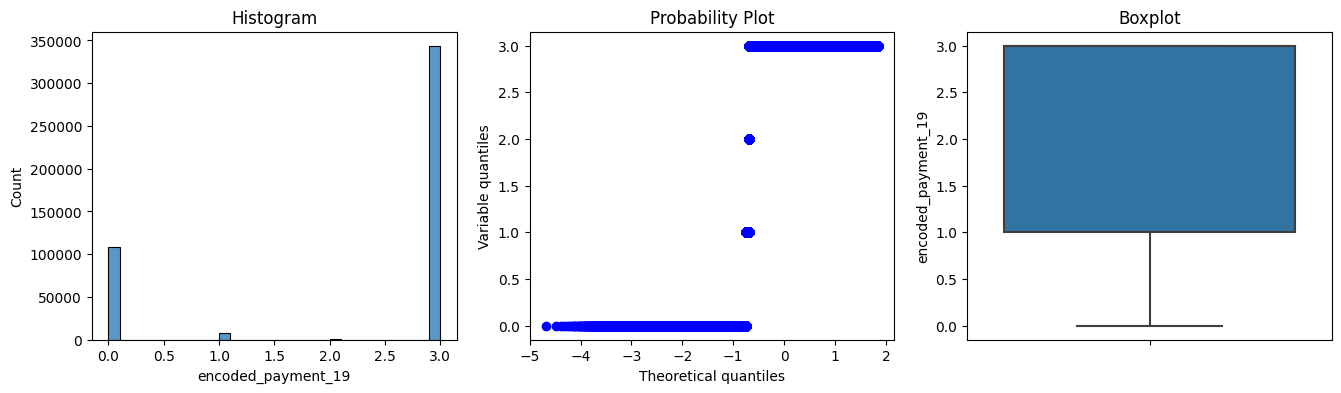

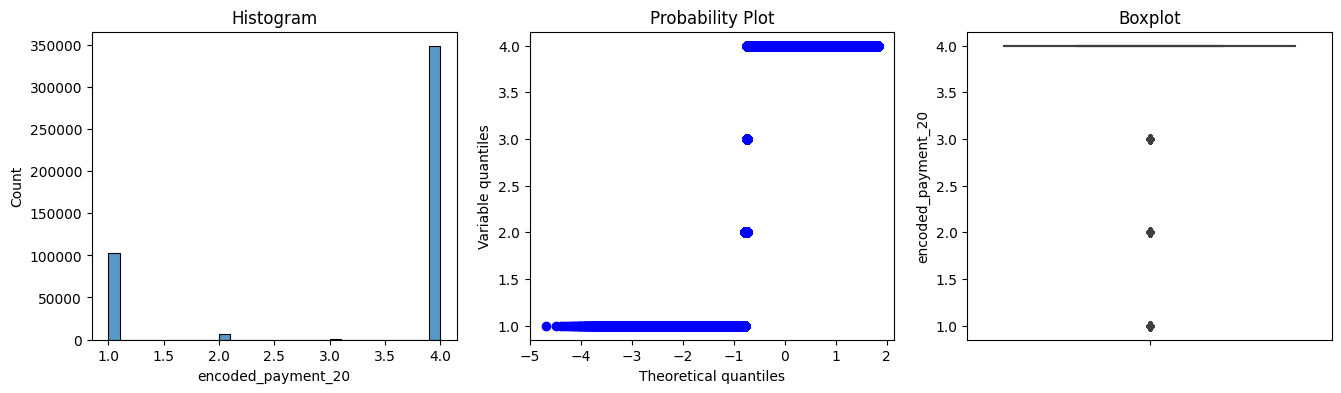

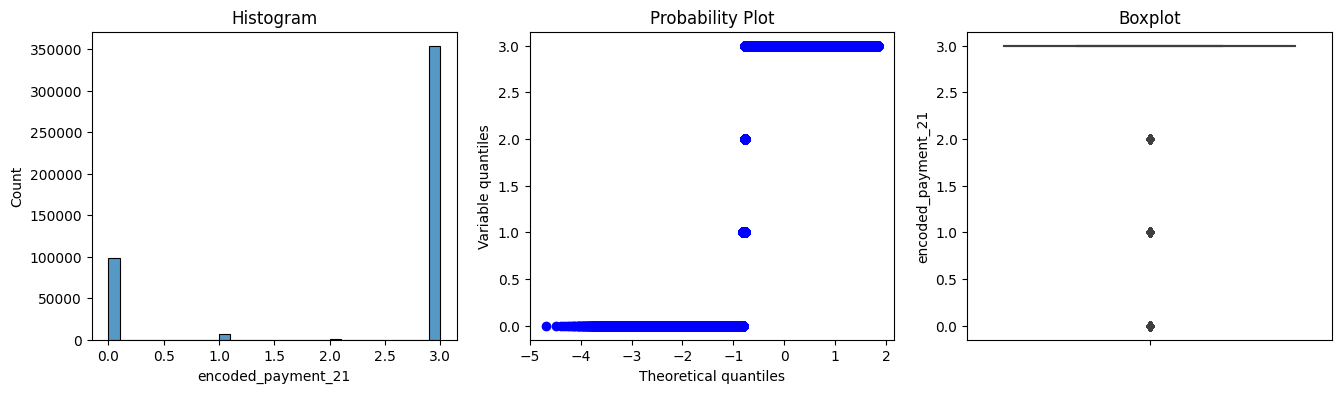

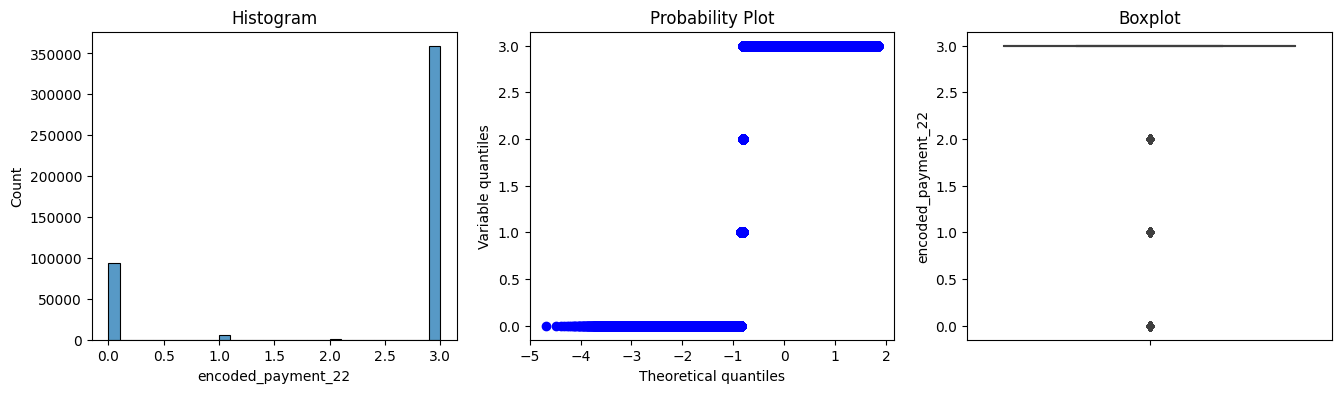

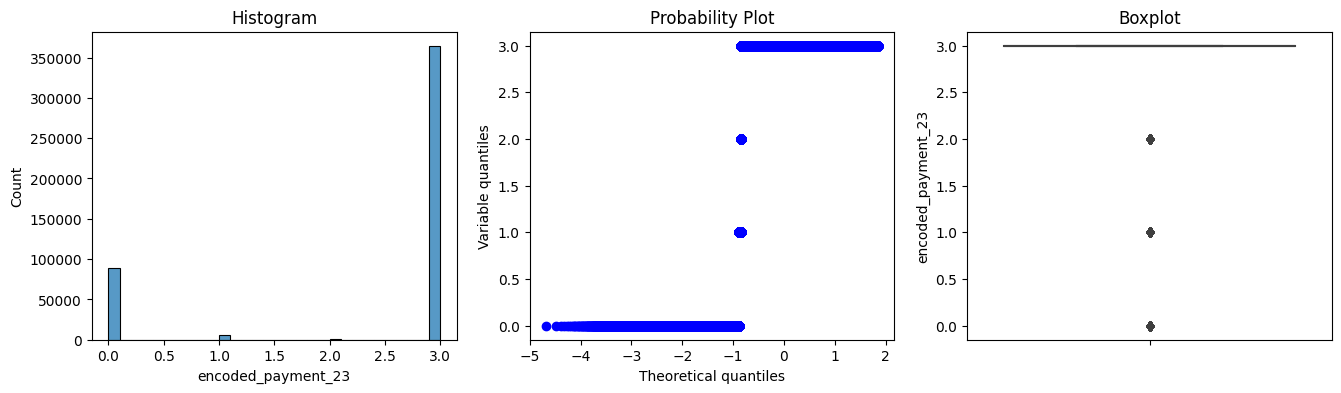

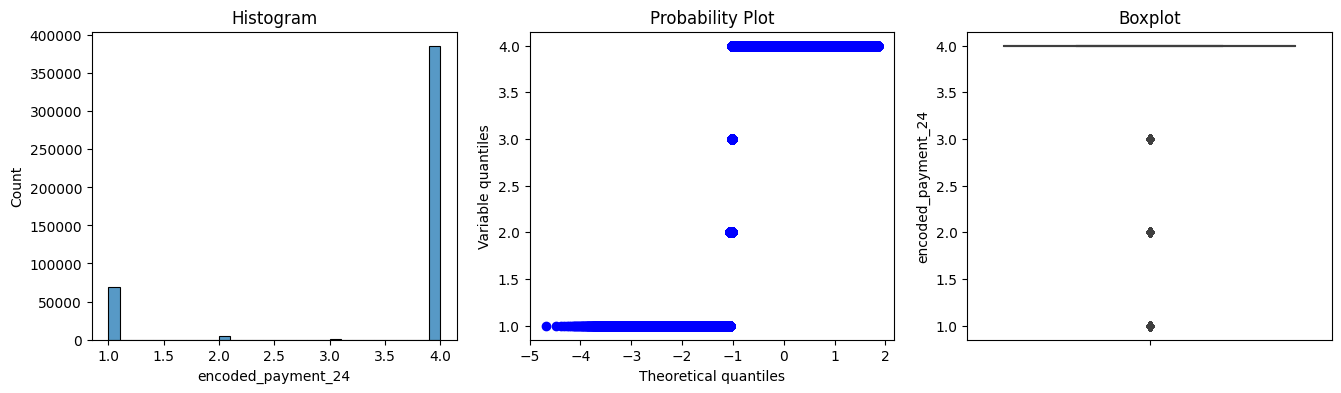

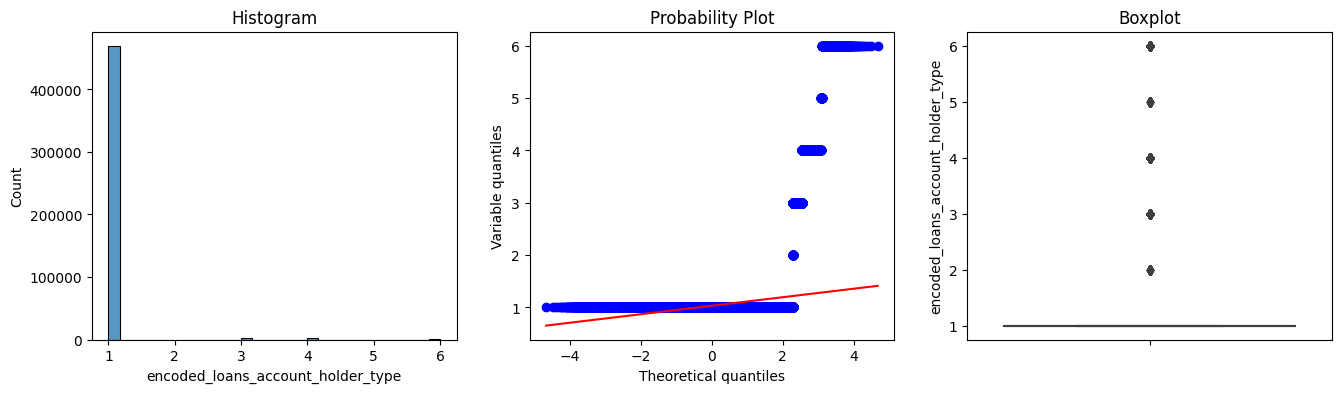

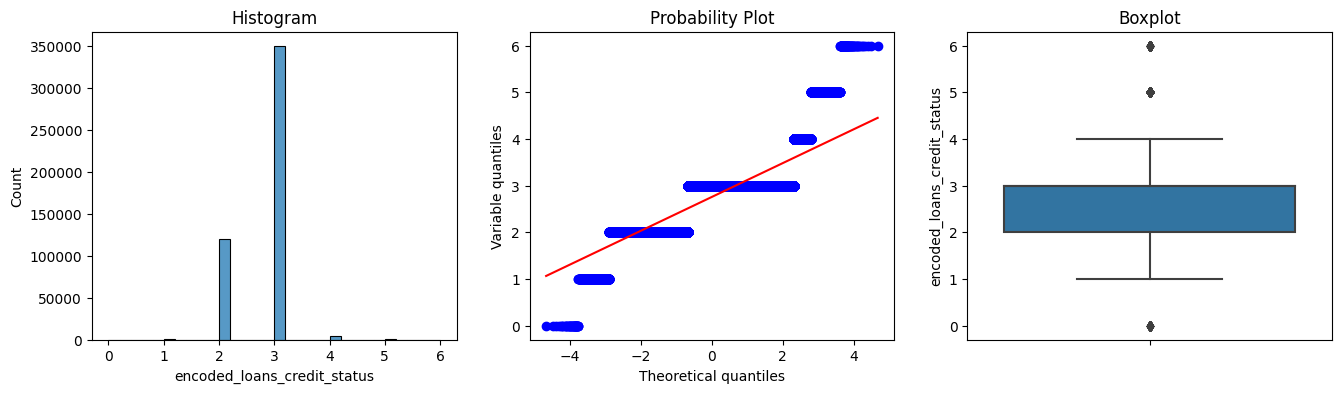

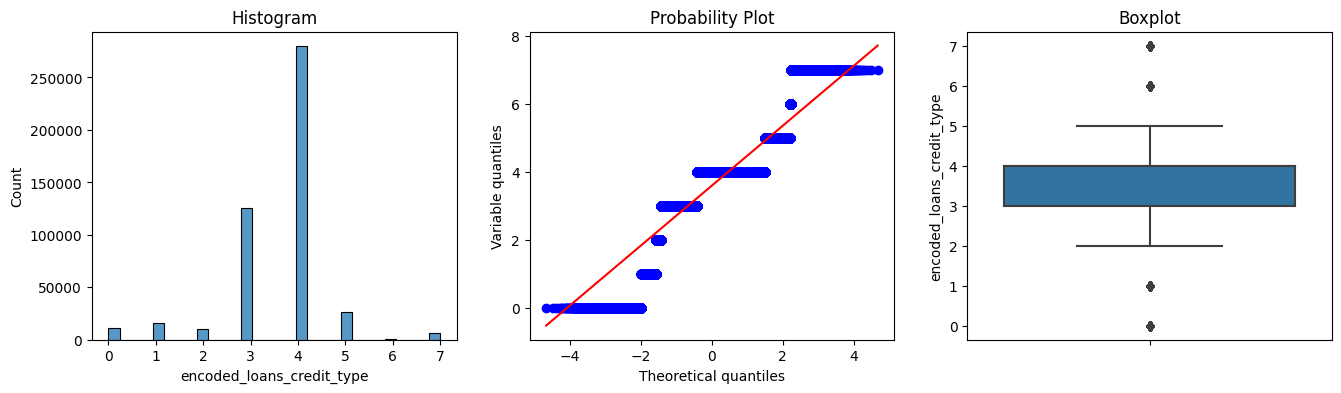

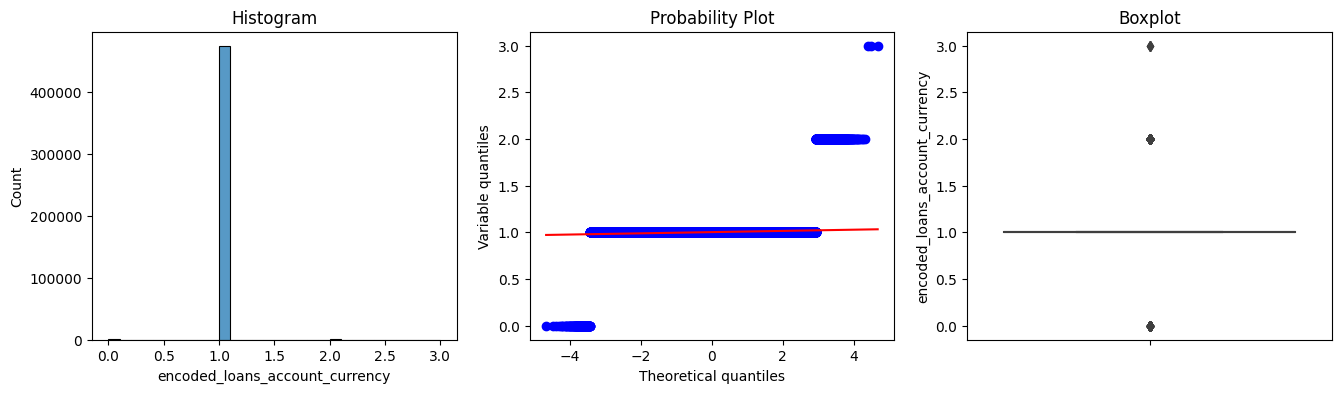

In [133]:
num_ft_test=  test.select_dtypes(include=[np.number])
for col in num_ft_test:
    diagnostic_plots(test,col)

### Plotting Correlation values for numerical columns in Train and Test set

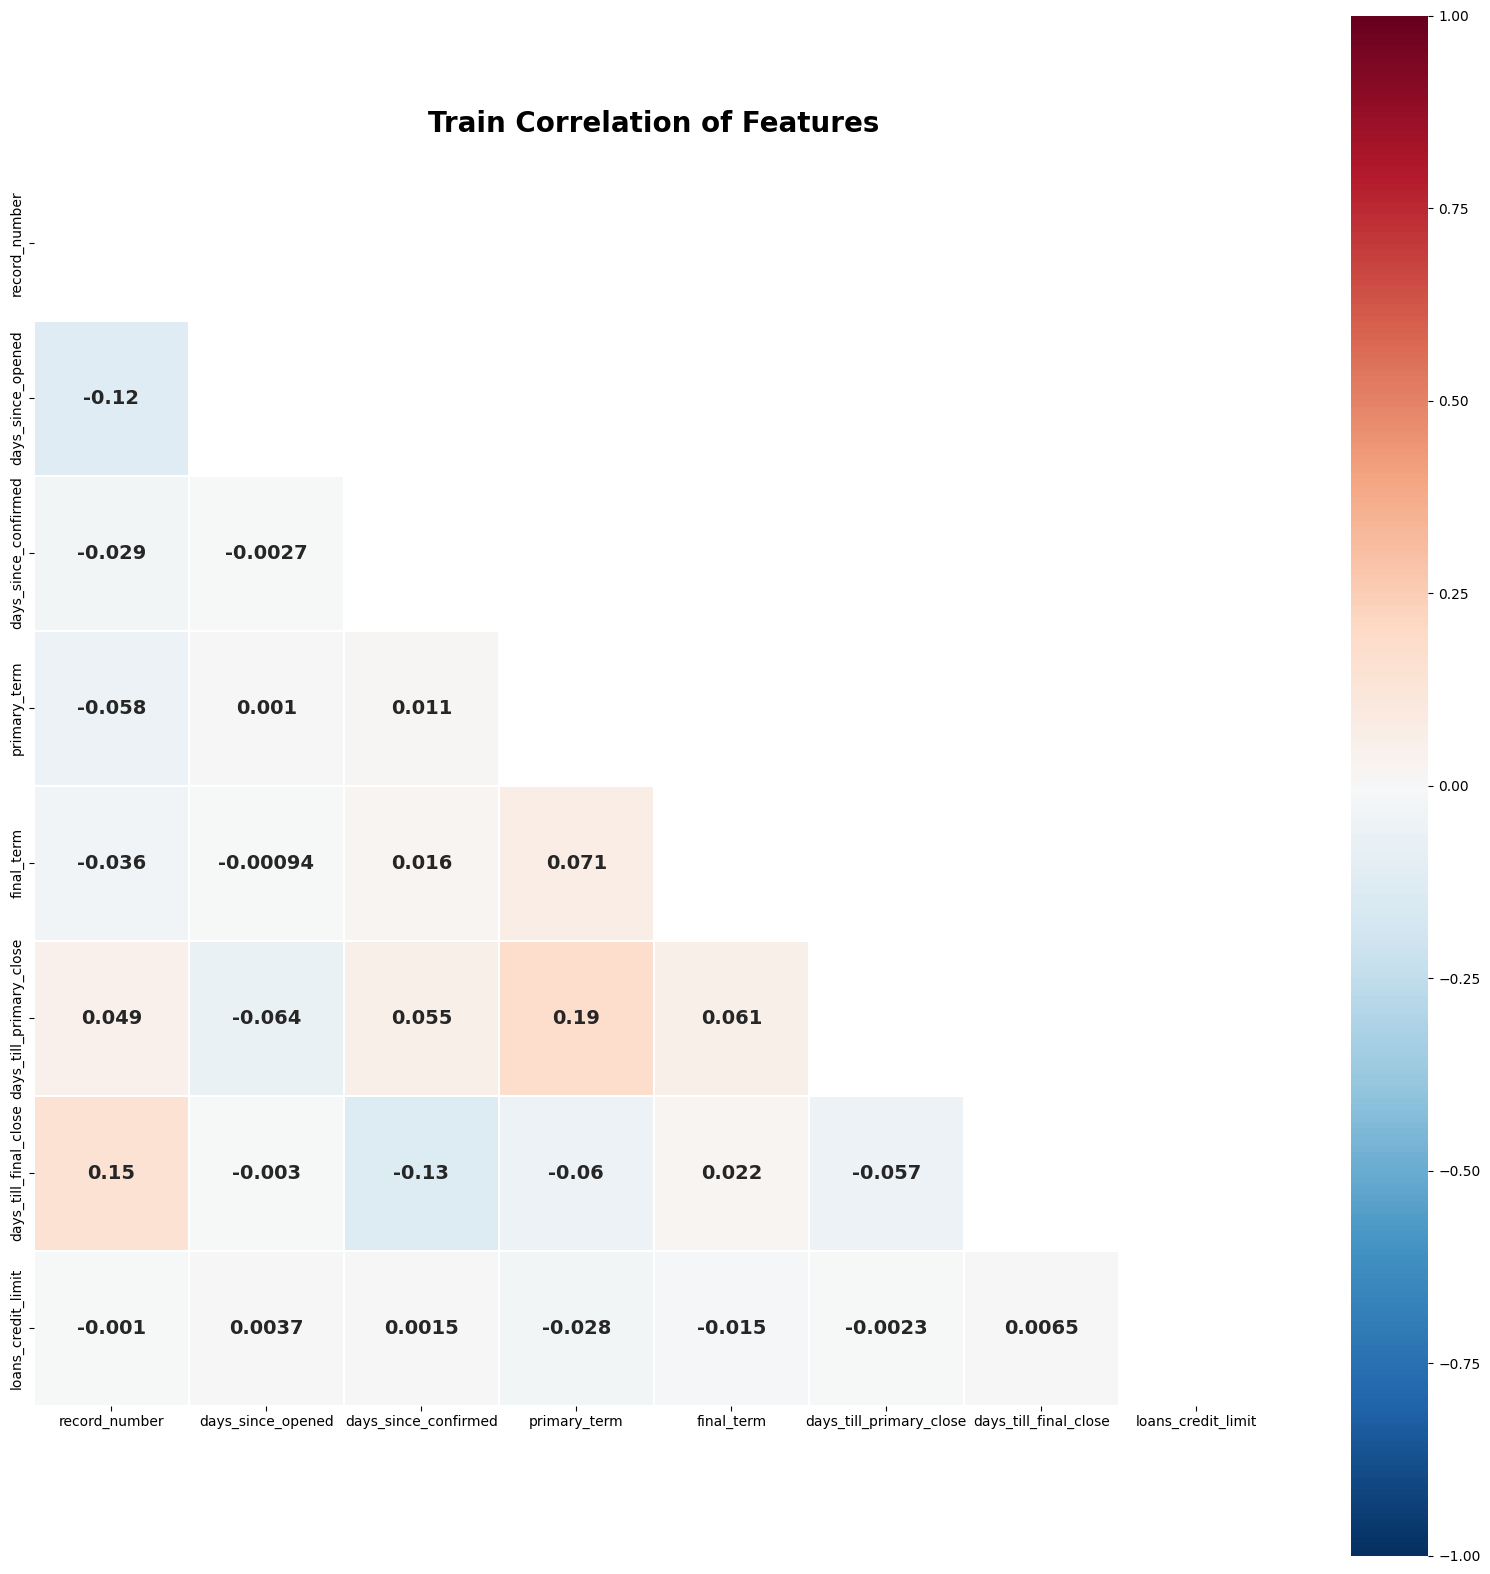

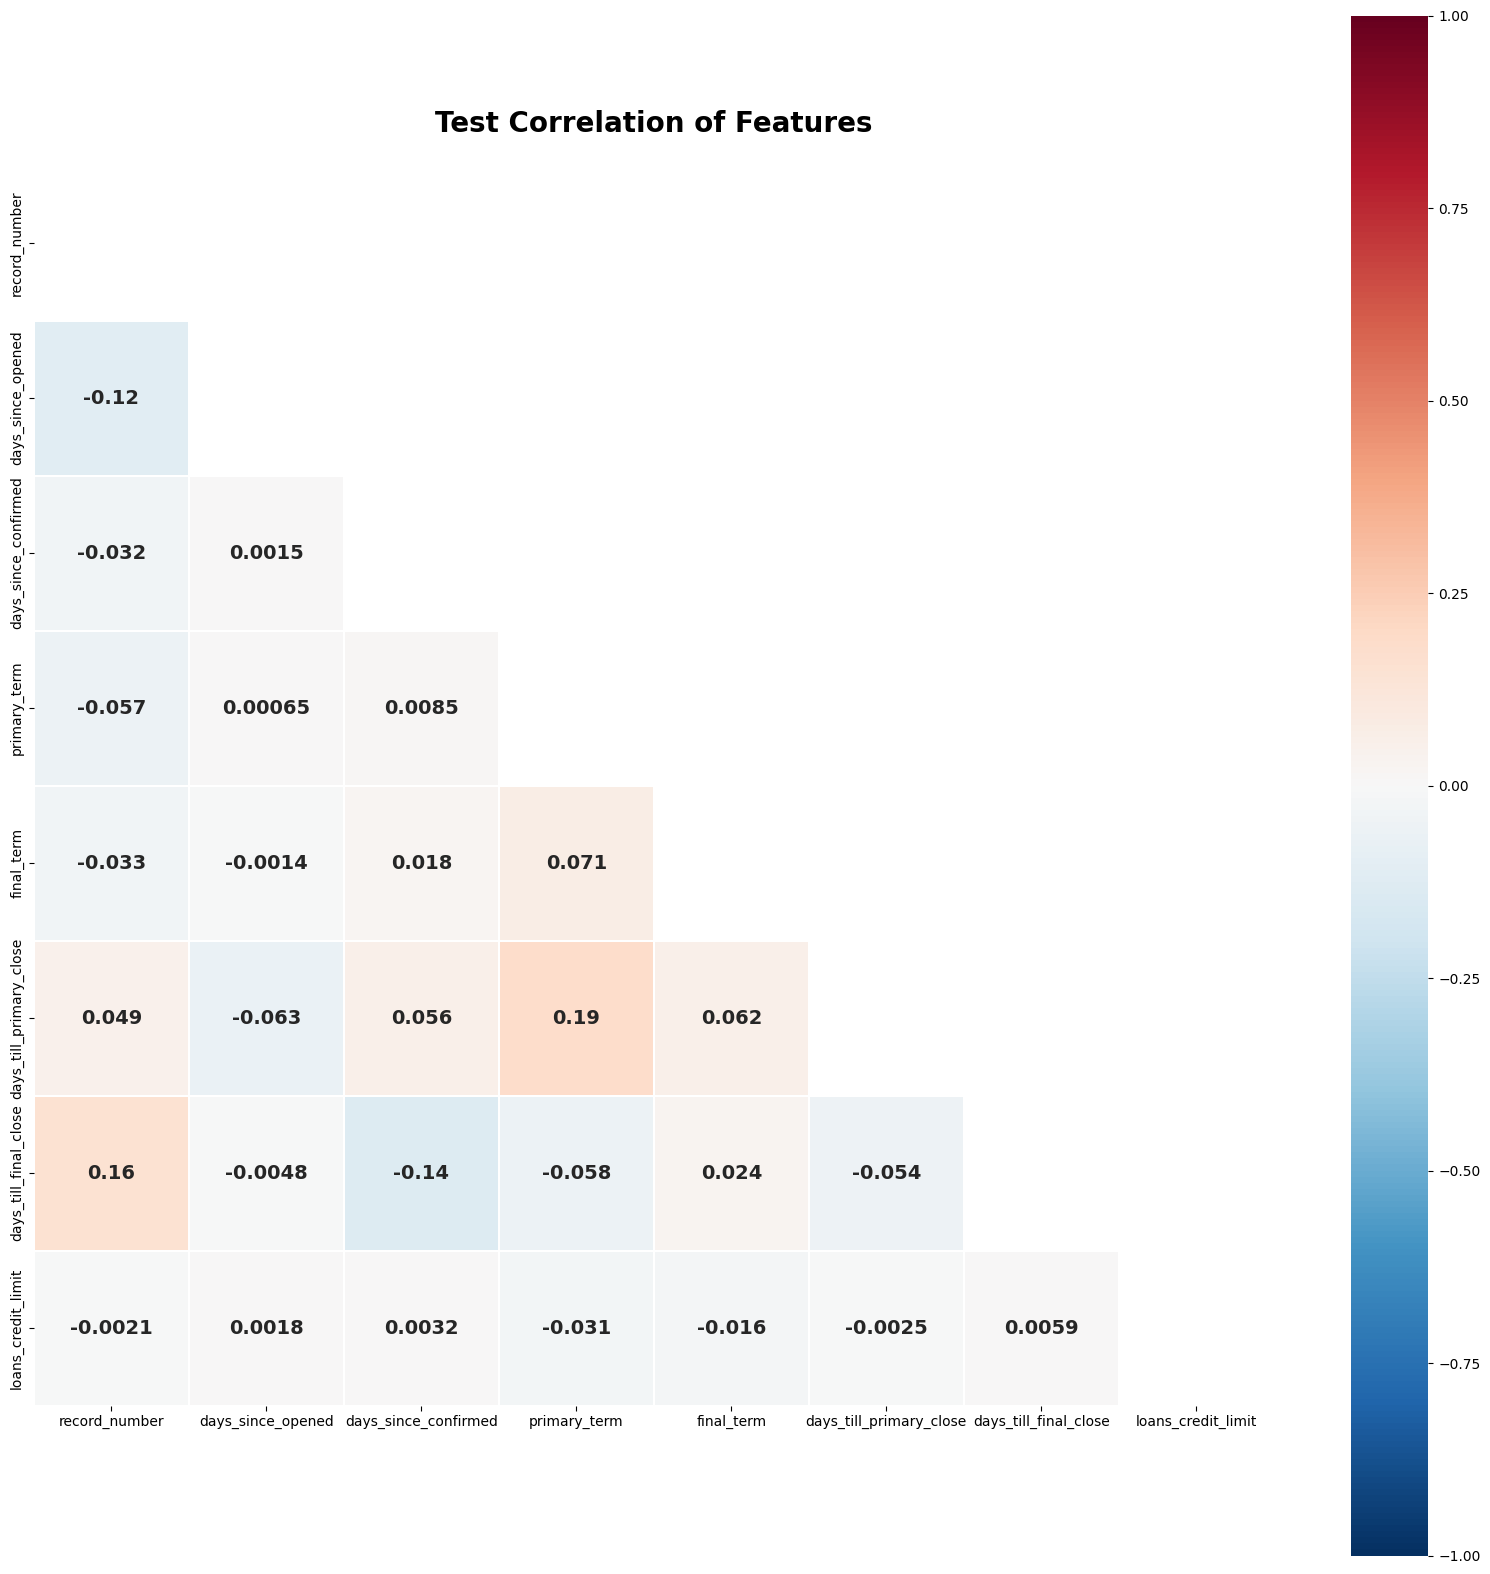

In [134]:
train_vis = num_ft_train[['record_number', 'days_since_opened', 'days_since_confirmed', 'primary_term', 'final_term','days_till_primary_close','days_till_final_close','loans_credit_limit']].copy()
test_vis = num_ft_test[['record_number', 'days_since_opened', 'days_since_confirmed', 'primary_term', 'final_term','days_till_primary_close','days_till_final_close','loans_credit_limit']].copy()


def plot_heatmap(df, title):
    # Create a mask for the diagonal elements
    mask = np.zeros_like(df.astype(float).corr())
    mask[np.triu_indices_from(mask)] = True

    # Set the colormap and figure size
    colormap = plt.cm.RdBu_r
    plt.figure(figsize=(20, 20))

    # Set the title and font properties
    plt.title(f'{title} Correlation of Features', fontweight='bold', y=1.02, size=20)

    # Plot the heatmap with the masked diagonal elements
    sns.heatmap(df.astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1.0, 
                square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 14, "weight": "bold"},
                mask=mask)

plot_heatmap(train_vis, title='Train')
plot_heatmap(test_vis, title='Test')

### Checking Class Imbalance

In [135]:
print(f"Class imbalance for primary_close_flag target in train set is {sum(y_1 == 1)/ len(train) * 100} percent.")
print(f"Class imbalance for final_close_flag target in train set is {sum(y_2 == 1)/ len(train) * 100} percent.")

Class imbalance for primary_close_flag target in train set is 12.827083675951545 percent.
Class imbalance for final_close_flag target in train set is 19.104542078335626 percent.


### For class imbalance, we can use Scale_pos_weight
* Scale_pos_weight controls the balance of positive and negative weights, it is useful for unbalanced classes.
* scale_pos_weight is available as a hyperparameter in catboost, xgboost and lightgbm.
* scale_pos_weight = sum(negative instances) / sum(positive instances)

### Data Preprocessing

In [30]:
#converting Categorical column into numerical columns
data=pd.concat((train,test)).reset_index(drop=True)

cat_cols=test.select_dtypes(include=['object','category'])

# for categorical features, doing simple numeric representation of feature by identifying distinct values.
for col in cat_cols:
    data[col],_ = data[col].factorize()
    
train=data[:len(train)]
test=data[len(train):]

### Model Building & Evaluation

### Making Predictions for  **primary_close_flag**

In [155]:
# Calculate the ratio of '0' values to '1' values in the target variable 'y_1'
no = sum(y_1 == 0)/sum(y_1 == 1)

# Define hyperparameters for the CatBoostClassifier
cat_params= {'n_estimators':5000,
             'objective': 'Logloss',
             'eval_metric':'AUC',
          'scale_pos_weight':no # Set the scale_pos_weight based on the ratio of '0' to '1' in the target variable 
            } 
# Initialize the CatBoostClassifier model with the defined hyperparameters
cat_model=CatBoostClassifier(**cat_params)

# Create a StratifiedKFold cross-validation object with 5 folds
kf=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

# Initialize arrays to store predictions, scores, and feature importance
oof_cat = np.zeros(train.shape[0])
target_column = np.zeros(train.shape[0])
cat_test_clf = []
cat_test_clf_new_feat=[]
train_scores =[]
val_scores =[]
out_of_fold = []

feature_names = list(train.columns)

# Initialize an array to store feature importance values
feature_importance_values = np.zeros(len(feature_names))

# Loop through the folds for cross-validation
for fold_idx, (train_index, test_index) in enumerate(kf.split(train, y_1)):
    
    # Split the data into training and validation sets
    X_train,X_test,y_train,y_test= train.loc[train_index,:] ,train.loc[test_index,:],y_1[train_index], y_1[test_index]
    
    # Fit the CatBoost model to the training data
    cat_model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=500,verbose=False)
    
    feature_importance_values += cat_model.feature_importances_ / 5
    
    # Set the number of estimators based on the best iteration
    cat_model.n_estimators = cat_model.best_iteration_
    
    # Generate predictions on the training and validation sets
    pred_1=cat_model.predict_proba(X_train)[:,1]
    pred_2=cat_model.predict_proba(X_test)[:,1]
    
    # Store predictions for out-of-fold analysis
    oof_cat[test_index] = pred_2
    target_column[test_index] = y_test
    
    # Generate predictions on the test data and store them
    cat_test_clf_new_feat.append(cat_model.predict_proba(test)[:,1])

    # Calculate ROC AUC scores for training and validation sets
    training_score=roc_auc_score(y_train,pred_1)
    val_score=roc_auc_score(y_test,pred_2)
    
    # Print fold information and scores
    print(f'fold no ----->{fold_idx+1}')
    print(f'training_roc_score-->>>{training_score}')
    print(f'val_roc_score-->>>{val_score}') 
    print('*******************************************')
    print('*******************************************')
    
    
    # Store the scores for each fold
    train_scores.append(training_score)
    val_scores.append(val_score)

# Calculate and print the mean ROC AUC scores for training and validation sets
print(f'train mean score  is ---->{np.mean(train_scores)}')
print(f'val mean score  is ---->{np.mean(val_scores)}')  

# Calculate the final test predictions by averaging predictions from all folds
cat_test_clf_predictions_new_feat = np.squeeze(np.mean(cat_test_clf_new_feat, axis=0))


fold no ----->1
training_roc_score-->>>0.9999988612610571
val_roc_score-->>>0.9999985295387741
*******************************************
*******************************************
fold no ----->2
training_roc_score-->>>0.9999988327883048
val_roc_score-->>>0.9999986408958625
*******************************************
*******************************************
fold no ----->3
training_roc_score-->>>0.9999981677376072
val_roc_score-->>>0.9999983442478809
*******************************************
*******************************************
fold no ----->4
training_roc_score-->>>0.9999985350823194
val_roc_score-->>>0.9999988068361797
*******************************************
*******************************************
fold no ----->5
training_roc_score-->>>0.9999984197105636
val_roc_score-->>>0.9999965217027202
*******************************************
*******************************************
train mean score  is ---->0.9999985633159705
val mean score  is ---->0.99999816864428

### Feature importance for primary_close_flag

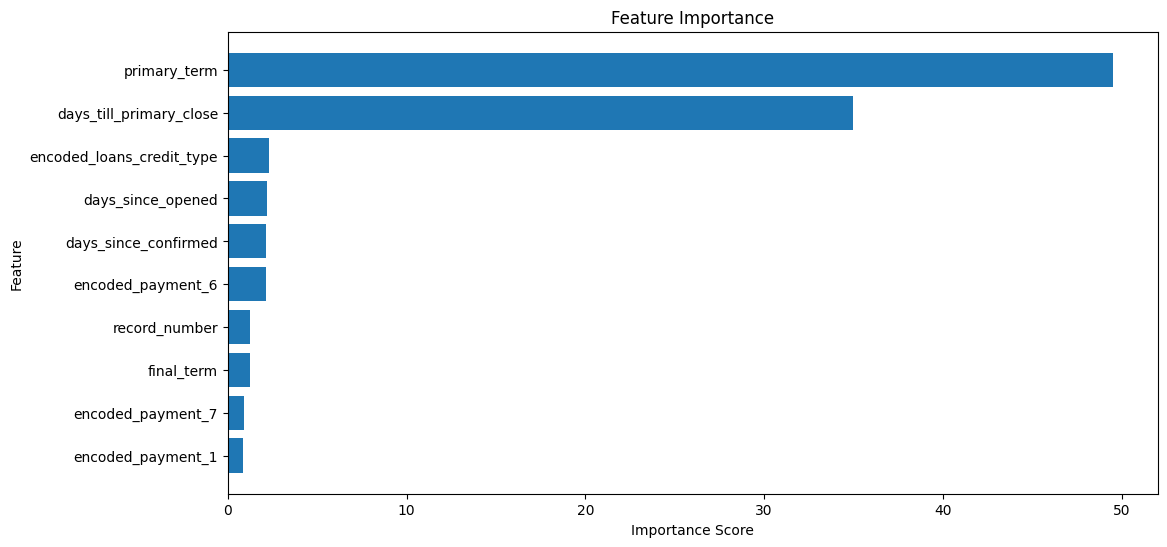

In [156]:
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance_values})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)[:10]

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important features at the top
plt.show()






### Making Predictions for **final_close_flag**

In [31]:
# Calculate the ratio of '0' values to '1' values in the target variable 'y_1'
no = sum(y_2 == 0)/sum(y_2 == 1)

# Define hyperparameters for the CatBoostClassifier
cat_params= {'n_estimators':5000,
             'objective': 'Logloss',
             'eval_metric':'AUC',
          'scale_pos_weight':no # Set the scale_pos_weight based on the ratio of '0' to '1' in the target variable 
            } 
# Initialize the CatBoostClassifier model with the defined hyperparameters
cat_model=CatBoostClassifier(**cat_params)

# Create a StratifiedKFold cross-validation object with 5 folds
kf=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

# Initialize arrays to store predictions, scores, and feature importance
oof_cat = np.zeros(train.shape[0])
target_column = np.zeros(train.shape[0])
cat_test_clf = []
cat_test_clf_new_feat=[]
train_scores =[]
val_scores =[]
out_of_fold = []

# Get the list of feature names
feature_names = list(train.columns)

# Loop through the folds for cross-validation
for fold_idx, (train_index, test_index) in enumerate(kf.split(train, y_2)):
    
    # Split the data into training and validation sets
    X_train,X_test,y_train,y_test= train.loc[train_index,:] ,train.loc[test_index,:],y_2[train_index], y_2[test_index]
    
    # Fit the CatBoost model to the training data
    cat_model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=500,verbose=False)
    
    # Set the number of estimators based on the best iteration
    cat_model.n_estimators = cat_model.best_iteration_
    
    # Generate predictions on the training and validation sets
    pred_1=cat_model.predict_proba(X_train)[:,1]
    pred_2=cat_model.predict_proba(X_test)[:,1]
    
    # Store predictions for out-of-fold analysis
    oof_cat[test_index] = pred_2
    target_column[test_index] = y_test
    
    # Generate predictions on the test data and store them
    cat_test_clf_new_feat.append(cat_model.predict_proba(test)[:,1])

    # Calculate ROC AUC scores for training and validation sets
    training_score=roc_auc_score(y_train,pred_1)
    val_score=roc_auc_score(y_test,pred_2)
    
    # Print fold information and scores
    print(f'fold no ----->{fold_idx+1}')
    print(f'training_roc_score-->>>{training_score}')
    print(f'val_roc_score-->>>{val_score}') 
    print('*******************************************')
    print('*******************************************')
    
    
    # Store the scores for each fold
    train_scores.append(training_score)
    val_scores.append(val_score)

# Calculate and print the mean ROC AUC scores for training and validation sets
print(f'train mean score  is ---->{np.mean(train_scores)}')
print(f'val mean score  is ---->{np.mean(val_scores)}')  

# Calculate the final test predictions by averaging predictions from all folds
cat_test_clf_predictions_new_feat_2 = np.squeeze(np.mean(cat_test_clf_new_feat, axis=0))


fold no ----->1
training_roc_score-->>>0.9999989482440985
val_roc_score-->>>0.9999980327901549
*******************************************
*******************************************
fold no ----->2
training_roc_score-->>>0.9999986267468598
val_roc_score-->>>0.9999939229673037
*******************************************
*******************************************
fold no ----->3
training_roc_score-->>>0.9999966908167983
val_roc_score-->>>1.0
*******************************************
*******************************************
fold no ----->4
training_roc_score-->>>0.9999976451795625
val_roc_score-->>>0.9999999998679193
*******************************************
*******************************************
fold no ----->5
training_roc_score-->>>0.9999975841161673
val_roc_score-->>>0.9999982509776917
*******************************************
*******************************************
train mean score  is ---->0.9999978990206972
val mean score  is ---->0.9999980413206139


### Feature importance for final_close_flag

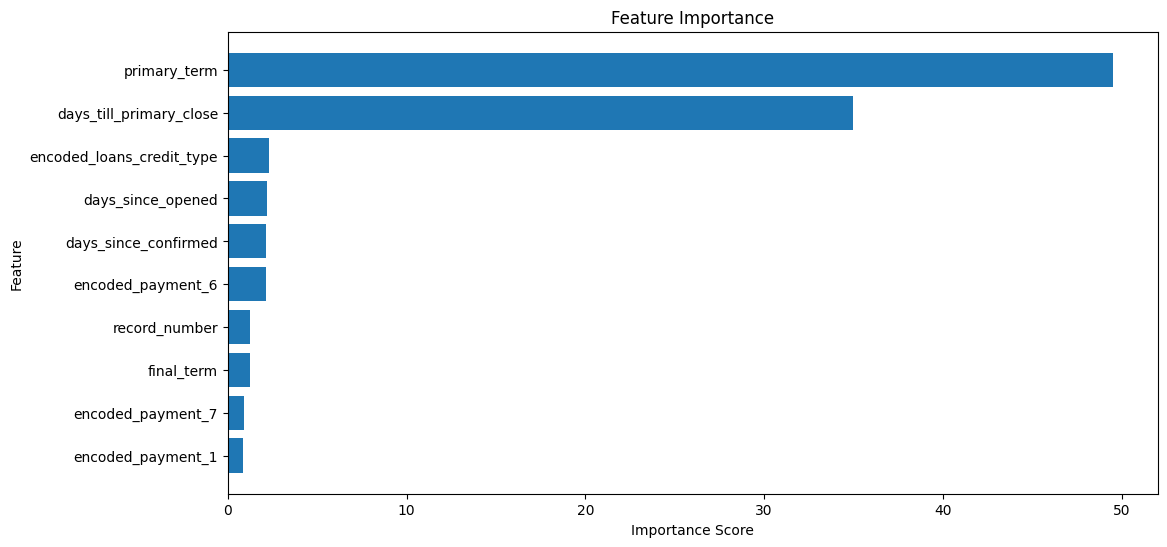

In [158]:
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance_values})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)[:10]

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important features at the top
plt.show()




In [ ]:
# Save the model
pickle.dump(logmodel, open('model.pkl', 'wb'))

### Combining both predictions

In [189]:
submission = pd.DataFrame({"primary_close_flag":cat_test_clf_predictions_new_feat,"final_close_flag":cat_test_clf_predictions_new_feat_2})

### Reducing Memmory of predictions

In [191]:
#Reducing memmory of predicitons
def reduce_memory_usage(df):
    start_memory = df.memory_usage().sum() / 1024**2  # in MB
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:  # Skip columns with 'object' dtype
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int8)
                else:
                    df[col] = df[col].astype(np.int8)
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float16)
                else:
                    df[col] = df[col].astype(np.float16)
    
    end_memory = df.memory_usage().sum() / 1024**2  # in MB
    print(f"Memory usage reduced from {start_memory:.2f} MB to {end_memory:.2f} MB")
    
    return df

# Optimize memory usage of the DataFrame
submission_file = reduce_memory_usage(submission)

# Save the optimized DataFrame
submission_file.to_csv('final_9.csv', index=False)

Memory usage reduced from 7.24 MB to 1.81 MB


### NOTE: AFTER THIS, TWO STEPS WERE TAKEN IN EXCEL:
* TRIMMING THE COLUMNS
* ROUNDING OF UPTO THREE DECIMALS 

### SAVING THE MODEL

In [3]:
data = pd.read_csv("data.csv")

y=data['final_close_flag']
data=data.drop(columns=['final_close_flag'],axis=1)

cols=['primary_term', 'encoded_payment_1', 'encoded_payment_7', 'final_term', 
                'record_number', 'encoded_payment_6', 
                'days_since_confirmed', 'days_since_opened',
                'days_till_primary_close']

data=data[['primary_term', 'encoded_payment_1', 'encoded_payment_7', 'final_term', 
                'record_number', 'encoded_payment_6', 
                'days_since_confirmed', 'days_since_opened',
                'days_till_primary_close']]

cat_cols=data.select_dtypes(include=['object','category'])

# for categorical features, doing simple numeric representation of feature by identifying distinct values.
for col in cat_cols:
    data[col],_ = data[col].factorize()

In [8]:
no = sum(y == 0)/sum(y == 1)

# Define hyperparameters for the CatBoostClassifier
cat_params= {'n_estimators':5000,
             'objective': 'Logloss',
             'eval_metric':'AUC',
          'scale_pos_weight':no # Set the scale_pos_weight based on the ratio of '0' to '1' in the target variable 
            }

cat_model_final = CatBoostClassifier(**cat_params)





cat_model_final.fit(data,y)

Learning rate set to 0.003027
0:	total: 151ms	remaining: 12m 33s
1:	total: 153ms	remaining: 6m 21s
2:	total: 155ms	remaining: 4m 17s
3:	total: 157ms	remaining: 3m 16s
4:	total: 159ms	remaining: 2m 38s
5:	total: 161ms	remaining: 2m 13s
6:	total: 163ms	remaining: 1m 56s
7:	total: 165ms	remaining: 1m 42s
8:	total: 167ms	remaining: 1m 32s
9:	total: 169ms	remaining: 1m 24s
10:	total: 171ms	remaining: 1m 17s
11:	total: 173ms	remaining: 1m 11s
12:	total: 175ms	remaining: 1m 6s
13:	total: 177ms	remaining: 1m 2s
14:	total: 179ms	remaining: 59.4s
15:	total: 181ms	remaining: 56.3s
16:	total: 183ms	remaining: 53.6s
17:	total: 185ms	remaining: 51.2s
18:	total: 187ms	remaining: 49.1s
19:	total: 191ms	remaining: 47.6s
20:	total: 193ms	remaining: 45.8s
21:	total: 195ms	remaining: 44.2s
22:	total: 197ms	remaining: 42.6s
23:	total: 199ms	remaining: 41.2s
24:	total: 201ms	remaining: 40s
25:	total: 203ms	remaining: 38.8s
26:	total: 205ms	remaining: 37.7s
27:	total: 207ms	remaining: 36.7s
28:	total: 209ms	

325:	total: 795ms	remaining: 11.4s
326:	total: 798ms	remaining: 11.4s
327:	total: 799ms	remaining: 11.4s
328:	total: 801ms	remaining: 11.4s
329:	total: 803ms	remaining: 11.4s
330:	total: 805ms	remaining: 11.4s
331:	total: 807ms	remaining: 11.3s
332:	total: 809ms	remaining: 11.3s
333:	total: 810ms	remaining: 11.3s
334:	total: 812ms	remaining: 11.3s
335:	total: 814ms	remaining: 11.3s
336:	total: 816ms	remaining: 11.3s
337:	total: 818ms	remaining: 11.3s
338:	total: 820ms	remaining: 11.3s
339:	total: 822ms	remaining: 11.3s
340:	total: 824ms	remaining: 11.3s
341:	total: 826ms	remaining: 11.2s
342:	total: 827ms	remaining: 11.2s
343:	total: 829ms	remaining: 11.2s
344:	total: 831ms	remaining: 11.2s
345:	total: 833ms	remaining: 11.2s
346:	total: 835ms	remaining: 11.2s
347:	total: 837ms	remaining: 11.2s
348:	total: 839ms	remaining: 11.2s
349:	total: 841ms	remaining: 11.2s
350:	total: 843ms	remaining: 11.2s
351:	total: 845ms	remaining: 11.2s
352:	total: 847ms	remaining: 11.1s
353:	total: 848ms	re

631:	total: 1.38s	remaining: 9.51s
632:	total: 1.38s	remaining: 9.51s
633:	total: 1.38s	remaining: 9.5s
634:	total: 1.38s	remaining: 9.5s
635:	total: 1.38s	remaining: 9.49s
636:	total: 1.39s	remaining: 9.49s
637:	total: 1.39s	remaining: 9.48s
638:	total: 1.39s	remaining: 9.48s
639:	total: 1.39s	remaining: 9.47s
640:	total: 1.39s	remaining: 9.47s
641:	total: 1.39s	remaining: 9.46s
642:	total: 1.4s	remaining: 9.46s
643:	total: 1.4s	remaining: 9.45s
644:	total: 1.4s	remaining: 9.45s
645:	total: 1.4s	remaining: 9.44s
646:	total: 1.4s	remaining: 9.44s
647:	total: 1.41s	remaining: 9.44s
648:	total: 1.41s	remaining: 9.43s
649:	total: 1.41s	remaining: 9.43s
650:	total: 1.41s	remaining: 9.42s
651:	total: 1.41s	remaining: 9.42s
652:	total: 1.41s	remaining: 9.42s
653:	total: 1.42s	remaining: 9.41s
654:	total: 1.42s	remaining: 9.41s
655:	total: 1.42s	remaining: 9.4s
656:	total: 1.42s	remaining: 9.4s
657:	total: 1.42s	remaining: 9.4s
658:	total: 1.43s	remaining: 9.39s
659:	total: 1.43s	remaining: 9

951:	total: 1.98s	remaining: 8.42s
952:	total: 1.98s	remaining: 8.42s
953:	total: 1.98s	remaining: 8.41s
954:	total: 1.99s	remaining: 8.41s
955:	total: 1.99s	remaining: 8.41s
956:	total: 1.99s	remaining: 8.41s
957:	total: 1.99s	remaining: 8.4s
958:	total: 1.99s	remaining: 8.4s
959:	total: 2s	remaining: 8.4s
960:	total: 2s	remaining: 8.39s
961:	total: 2s	remaining: 8.39s
962:	total: 2s	remaining: 8.39s
963:	total: 2s	remaining: 8.38s
964:	total: 2s	remaining: 8.38s
965:	total: 2.01s	remaining: 8.38s
966:	total: 2.01s	remaining: 8.37s
967:	total: 2.01s	remaining: 8.37s
968:	total: 2.01s	remaining: 8.37s
969:	total: 2.01s	remaining: 8.37s
970:	total: 2.02s	remaining: 8.37s
971:	total: 2.02s	remaining: 8.36s
972:	total: 2.02s	remaining: 8.36s
973:	total: 2.02s	remaining: 8.36s
974:	total: 2.02s	remaining: 8.35s
975:	total: 2.02s	remaining: 8.35s
976:	total: 2.03s	remaining: 8.35s
977:	total: 2.03s	remaining: 8.35s
978:	total: 2.03s	remaining: 8.34s
979:	total: 2.03s	remaining: 8.34s
980:	t

1259:	total: 2.57s	remaining: 7.63s
1260:	total: 2.57s	remaining: 7.62s
1261:	total: 2.57s	remaining: 7.62s
1262:	total: 2.58s	remaining: 7.62s
1263:	total: 2.58s	remaining: 7.62s
1264:	total: 2.58s	remaining: 7.62s
1265:	total: 2.58s	remaining: 7.61s
1266:	total: 2.58s	remaining: 7.61s
1267:	total: 2.58s	remaining: 7.61s
1268:	total: 2.58s	remaining: 7.6s
1269:	total: 2.59s	remaining: 7.6s
1270:	total: 2.59s	remaining: 7.6s
1271:	total: 2.59s	remaining: 7.59s
1272:	total: 2.59s	remaining: 7.59s
1273:	total: 2.6s	remaining: 7.59s
1274:	total: 2.6s	remaining: 7.59s
1275:	total: 2.6s	remaining: 7.58s
1276:	total: 2.6s	remaining: 7.58s
1277:	total: 2.6s	remaining: 7.58s
1278:	total: 2.6s	remaining: 7.58s
1279:	total: 2.61s	remaining: 7.58s
1280:	total: 2.61s	remaining: 7.57s
1281:	total: 2.61s	remaining: 7.57s
1282:	total: 2.61s	remaining: 7.57s
1283:	total: 2.61s	remaining: 7.56s
1284:	total: 2.61s	remaining: 7.56s
1285:	total: 2.62s	remaining: 7.55s
1286:	total: 2.62s	remaining: 7.55s
1

1568:	total: 3.17s	remaining: 6.92s
1569:	total: 3.17s	remaining: 6.92s
1570:	total: 3.17s	remaining: 6.92s
1571:	total: 3.17s	remaining: 6.92s
1572:	total: 3.17s	remaining: 6.92s
1573:	total: 3.18s	remaining: 6.92s
1574:	total: 3.18s	remaining: 6.91s
1575:	total: 3.18s	remaining: 6.91s
1576:	total: 3.18s	remaining: 6.91s
1577:	total: 3.19s	remaining: 6.91s
1578:	total: 3.19s	remaining: 6.91s
1579:	total: 3.19s	remaining: 6.9s
1580:	total: 3.19s	remaining: 6.9s
1581:	total: 3.19s	remaining: 6.9s
1582:	total: 3.19s	remaining: 6.9s
1583:	total: 3.2s	remaining: 6.89s
1584:	total: 3.2s	remaining: 6.89s
1585:	total: 3.2s	remaining: 6.89s
1586:	total: 3.2s	remaining: 6.89s
1587:	total: 3.2s	remaining: 6.88s
1588:	total: 3.21s	remaining: 6.88s
1589:	total: 3.21s	remaining: 6.88s
1590:	total: 3.21s	remaining: 6.88s
1591:	total: 3.21s	remaining: 6.88s
1592:	total: 3.21s	remaining: 6.87s
1593:	total: 3.21s	remaining: 6.87s
1594:	total: 3.22s	remaining: 6.87s
1595:	total: 3.22s	remaining: 6.87s
1

1875:	total: 3.75s	remaining: 6.25s
1876:	total: 3.75s	remaining: 6.25s
1877:	total: 3.76s	remaining: 6.25s
1878:	total: 3.76s	remaining: 6.24s
1879:	total: 3.76s	remaining: 6.24s
1880:	total: 3.76s	remaining: 6.24s
1881:	total: 3.76s	remaining: 6.24s
1882:	total: 3.77s	remaining: 6.23s
1883:	total: 3.77s	remaining: 6.23s
1884:	total: 3.77s	remaining: 6.23s
1885:	total: 3.77s	remaining: 6.22s
1886:	total: 3.77s	remaining: 6.22s
1887:	total: 3.77s	remaining: 6.22s
1888:	total: 3.77s	remaining: 6.22s
1889:	total: 3.78s	remaining: 6.21s
1890:	total: 3.78s	remaining: 6.21s
1891:	total: 3.78s	remaining: 6.21s
1892:	total: 3.78s	remaining: 6.21s
1893:	total: 3.78s	remaining: 6.21s
1894:	total: 3.79s	remaining: 6.21s
1895:	total: 3.79s	remaining: 6.2s
1896:	total: 3.79s	remaining: 6.2s
1897:	total: 3.79s	remaining: 6.2s
1898:	total: 3.79s	remaining: 6.2s
1899:	total: 3.8s	remaining: 6.19s
1900:	total: 3.8s	remaining: 6.19s
1901:	total: 3.8s	remaining: 6.19s
1902:	total: 3.8s	remaining: 6.18s


2195:	total: 4.34s	remaining: 5.54s
2196:	total: 4.34s	remaining: 5.54s
2197:	total: 4.34s	remaining: 5.53s
2198:	total: 4.34s	remaining: 5.53s
2199:	total: 4.34s	remaining: 5.53s
2200:	total: 4.35s	remaining: 5.53s
2201:	total: 4.35s	remaining: 5.53s
2202:	total: 4.35s	remaining: 5.52s
2203:	total: 4.35s	remaining: 5.52s
2204:	total: 4.35s	remaining: 5.52s
2205:	total: 4.36s	remaining: 5.52s
2206:	total: 4.36s	remaining: 5.51s
2207:	total: 4.36s	remaining: 5.51s
2208:	total: 4.36s	remaining: 5.51s
2209:	total: 4.36s	remaining: 5.51s
2210:	total: 4.36s	remaining: 5.5s
2211:	total: 4.37s	remaining: 5.5s
2212:	total: 4.37s	remaining: 5.5s
2213:	total: 4.37s	remaining: 5.5s
2214:	total: 4.37s	remaining: 5.5s
2215:	total: 4.37s	remaining: 5.49s
2216:	total: 4.38s	remaining: 5.49s
2217:	total: 4.38s	remaining: 5.49s
2218:	total: 4.38s	remaining: 5.49s
2219:	total: 4.38s	remaining: 5.49s
2220:	total: 4.38s	remaining: 5.48s
2221:	total: 4.38s	remaining: 5.48s
2222:	total: 4.39s	remaining: 5.4

2500:	total: 4.9s	remaining: 4.9s
2501:	total: 4.9s	remaining: 4.89s
2502:	total: 4.9s	remaining: 4.89s
2503:	total: 4.91s	remaining: 4.89s
2504:	total: 4.91s	remaining: 4.89s
2505:	total: 4.91s	remaining: 4.89s
2506:	total: 4.91s	remaining: 4.88s
2507:	total: 4.91s	remaining: 4.88s
2508:	total: 4.92s	remaining: 4.88s
2509:	total: 4.92s	remaining: 4.88s
2510:	total: 4.92s	remaining: 4.87s
2511:	total: 4.92s	remaining: 4.87s
2512:	total: 4.92s	remaining: 4.87s
2513:	total: 4.92s	remaining: 4.87s
2514:	total: 4.92s	remaining: 4.87s
2515:	total: 4.93s	remaining: 4.86s
2516:	total: 4.93s	remaining: 4.86s
2517:	total: 4.93s	remaining: 4.86s
2518:	total: 4.93s	remaining: 4.86s
2519:	total: 4.93s	remaining: 4.86s
2520:	total: 4.94s	remaining: 4.85s
2521:	total: 4.94s	remaining: 4.85s
2522:	total: 4.94s	remaining: 4.85s
2523:	total: 4.94s	remaining: 4.85s
2524:	total: 4.94s	remaining: 4.85s
2525:	total: 4.95s	remaining: 4.84s
2526:	total: 4.95s	remaining: 4.84s
2527:	total: 4.95s	remaining: 4.

2809:	total: 5.49s	remaining: 4.28s
2810:	total: 5.49s	remaining: 4.28s
2811:	total: 5.49s	remaining: 4.27s
2812:	total: 5.49s	remaining: 4.27s
2813:	total: 5.5s	remaining: 4.27s
2814:	total: 5.5s	remaining: 4.27s
2815:	total: 5.5s	remaining: 4.26s
2816:	total: 5.5s	remaining: 4.26s
2817:	total: 5.5s	remaining: 4.26s
2818:	total: 5.5s	remaining: 4.26s
2819:	total: 5.5s	remaining: 4.26s
2820:	total: 5.51s	remaining: 4.25s
2821:	total: 5.51s	remaining: 4.25s
2822:	total: 5.51s	remaining: 4.25s
2823:	total: 5.51s	remaining: 4.25s
2824:	total: 5.51s	remaining: 4.25s
2825:	total: 5.52s	remaining: 4.24s
2826:	total: 5.52s	remaining: 4.24s
2827:	total: 5.52s	remaining: 4.24s
2828:	total: 5.52s	remaining: 4.24s
2829:	total: 5.52s	remaining: 4.24s
2830:	total: 5.53s	remaining: 4.23s
2831:	total: 5.53s	remaining: 4.23s
2832:	total: 5.53s	remaining: 4.23s
2833:	total: 5.53s	remaining: 4.23s
2834:	total: 5.53s	remaining: 4.22s
2835:	total: 5.54s	remaining: 4.22s
2836:	total: 5.54s	remaining: 4.22s

3116:	total: 6.07s	remaining: 3.67s
3117:	total: 6.07s	remaining: 3.66s
3118:	total: 6.07s	remaining: 3.66s
3119:	total: 6.07s	remaining: 3.66s
3120:	total: 6.08s	remaining: 3.66s
3121:	total: 6.08s	remaining: 3.66s
3122:	total: 6.08s	remaining: 3.65s
3123:	total: 6.08s	remaining: 3.65s
3124:	total: 6.08s	remaining: 3.65s
3125:	total: 6.08s	remaining: 3.65s
3126:	total: 6.09s	remaining: 3.65s
3127:	total: 6.09s	remaining: 3.64s
3128:	total: 6.09s	remaining: 3.64s
3129:	total: 6.09s	remaining: 3.64s
3130:	total: 6.09s	remaining: 3.64s
3131:	total: 6.1s	remaining: 3.64s
3132:	total: 6.1s	remaining: 3.63s
3133:	total: 6.1s	remaining: 3.63s
3134:	total: 6.1s	remaining: 3.63s
3135:	total: 6.1s	remaining: 3.63s
3136:	total: 6.11s	remaining: 3.63s
3137:	total: 6.11s	remaining: 3.62s
3138:	total: 6.11s	remaining: 3.62s
3139:	total: 6.11s	remaining: 3.62s
3140:	total: 6.11s	remaining: 3.62s
3141:	total: 6.12s	remaining: 3.62s
3142:	total: 6.12s	remaining: 3.62s
3143:	total: 6.12s	remaining: 3.6

3432:	total: 6.67s	remaining: 3.04s
3433:	total: 6.67s	remaining: 3.04s
3434:	total: 6.67s	remaining: 3.04s
3435:	total: 6.68s	remaining: 3.04s
3436:	total: 6.68s	remaining: 3.04s
3437:	total: 6.68s	remaining: 3.04s
3438:	total: 6.68s	remaining: 3.03s
3439:	total: 6.68s	remaining: 3.03s
3440:	total: 6.69s	remaining: 3.03s
3441:	total: 6.69s	remaining: 3.03s
3442:	total: 6.69s	remaining: 3.02s
3443:	total: 6.69s	remaining: 3.02s
3444:	total: 6.69s	remaining: 3.02s
3445:	total: 6.7s	remaining: 3.02s
3446:	total: 6.7s	remaining: 3.02s
3447:	total: 6.7s	remaining: 3.02s
3448:	total: 6.7s	remaining: 3.01s
3449:	total: 6.7s	remaining: 3.01s
3450:	total: 6.71s	remaining: 3.01s
3451:	total: 6.71s	remaining: 3.01s
3452:	total: 6.71s	remaining: 3.01s
3453:	total: 6.71s	remaining: 3s
3454:	total: 6.71s	remaining: 3s
3455:	total: 6.71s	remaining: 3s
3456:	total: 6.72s	remaining: 3s
3457:	total: 6.72s	remaining: 3s
3458:	total: 6.72s	remaining: 2.99s
3459:	total: 6.72s	remaining: 2.99s
3460:	total:

3745:	total: 7.27s	remaining: 2.43s
3746:	total: 7.27s	remaining: 2.43s
3747:	total: 7.27s	remaining: 2.43s
3748:	total: 7.27s	remaining: 2.43s
3749:	total: 7.28s	remaining: 2.42s
3750:	total: 7.28s	remaining: 2.42s
3751:	total: 7.28s	remaining: 2.42s
3752:	total: 7.28s	remaining: 2.42s
3753:	total: 7.28s	remaining: 2.42s
3754:	total: 7.29s	remaining: 2.42s
3755:	total: 7.29s	remaining: 2.41s
3756:	total: 7.29s	remaining: 2.41s
3757:	total: 7.29s	remaining: 2.41s
3758:	total: 7.29s	remaining: 2.41s
3759:	total: 7.29s	remaining: 2.4s
3760:	total: 7.3s	remaining: 2.4s
3761:	total: 7.3s	remaining: 2.4s
3762:	total: 7.3s	remaining: 2.4s
3763:	total: 7.3s	remaining: 2.4s
3764:	total: 7.3s	remaining: 2.4s
3765:	total: 7.31s	remaining: 2.39s
3766:	total: 7.31s	remaining: 2.39s
3767:	total: 7.31s	remaining: 2.39s
3768:	total: 7.31s	remaining: 2.39s
3769:	total: 7.31s	remaining: 2.39s
3770:	total: 7.32s	remaining: 2.38s
3771:	total: 7.32s	remaining: 2.38s
3772:	total: 7.32s	remaining: 2.38s
377

4059:	total: 7.87s	remaining: 1.82s
4060:	total: 7.87s	remaining: 1.82s
4061:	total: 7.87s	remaining: 1.82s
4062:	total: 7.87s	remaining: 1.81s
4063:	total: 7.88s	remaining: 1.81s
4064:	total: 7.88s	remaining: 1.81s
4065:	total: 7.88s	remaining: 1.81s
4066:	total: 7.88s	remaining: 1.81s
4067:	total: 7.88s	remaining: 1.8s
4068:	total: 7.88s	remaining: 1.8s
4069:	total: 7.89s	remaining: 1.8s
4070:	total: 7.89s	remaining: 1.8s
4071:	total: 7.89s	remaining: 1.8s
4072:	total: 7.89s	remaining: 1.8s
4073:	total: 7.89s	remaining: 1.79s
4074:	total: 7.89s	remaining: 1.79s
4075:	total: 7.9s	remaining: 1.79s
4076:	total: 7.9s	remaining: 1.79s
4077:	total: 7.9s	remaining: 1.79s
4078:	total: 7.9s	remaining: 1.78s
4079:	total: 7.91s	remaining: 1.78s
4080:	total: 7.91s	remaining: 1.78s
4081:	total: 7.91s	remaining: 1.78s
4082:	total: 7.91s	remaining: 1.78s
4083:	total: 7.91s	remaining: 1.77s
4084:	total: 7.91s	remaining: 1.77s
4085:	total: 7.92s	remaining: 1.77s
4086:	total: 7.92s	remaining: 1.77s
40

4367:	total: 8.46s	remaining: 1.22s
4368:	total: 8.46s	remaining: 1.22s
4369:	total: 8.46s	remaining: 1.22s
4370:	total: 8.46s	remaining: 1.22s
4371:	total: 8.46s	remaining: 1.22s
4372:	total: 8.47s	remaining: 1.21s
4373:	total: 8.47s	remaining: 1.21s
4374:	total: 8.47s	remaining: 1.21s
4375:	total: 8.47s	remaining: 1.21s
4376:	total: 8.47s	remaining: 1.21s
4377:	total: 8.47s	remaining: 1.2s
4378:	total: 8.48s	remaining: 1.2s
4379:	total: 8.48s	remaining: 1.2s
4380:	total: 8.48s	remaining: 1.2s
4381:	total: 8.48s	remaining: 1.2s
4382:	total: 8.48s	remaining: 1.19s
4383:	total: 8.49s	remaining: 1.19s
4384:	total: 8.49s	remaining: 1.19s
4385:	total: 8.49s	remaining: 1.19s
4386:	total: 8.49s	remaining: 1.19s
4387:	total: 8.49s	remaining: 1.18s
4388:	total: 8.5s	remaining: 1.18s
4389:	total: 8.5s	remaining: 1.18s
4390:	total: 8.5s	remaining: 1.18s
4391:	total: 8.5s	remaining: 1.18s
4392:	total: 8.5s	remaining: 1.17s
4393:	total: 8.51s	remaining: 1.17s
4394:	total: 8.51s	remaining: 1.17s
43

4671:	total: 9.04s	remaining: 635ms
4672:	total: 9.04s	remaining: 633ms
4673:	total: 9.04s	remaining: 631ms
4674:	total: 9.04s	remaining: 629ms
4675:	total: 9.04s	remaining: 627ms
4676:	total: 9.05s	remaining: 625ms
4677:	total: 9.05s	remaining: 623ms
4678:	total: 9.05s	remaining: 621ms
4679:	total: 9.05s	remaining: 619ms
4680:	total: 9.05s	remaining: 617ms
4681:	total: 9.06s	remaining: 615ms
4682:	total: 9.06s	remaining: 613ms
4683:	total: 9.06s	remaining: 611ms
4684:	total: 9.06s	remaining: 609ms
4685:	total: 9.06s	remaining: 607ms
4686:	total: 9.06s	remaining: 605ms
4687:	total: 9.07s	remaining: 603ms
4688:	total: 9.07s	remaining: 602ms
4689:	total: 9.07s	remaining: 600ms
4690:	total: 9.07s	remaining: 598ms
4691:	total: 9.07s	remaining: 596ms
4692:	total: 9.08s	remaining: 594ms
4693:	total: 9.08s	remaining: 592ms
4694:	total: 9.08s	remaining: 590ms
4695:	total: 9.08s	remaining: 588ms
4696:	total: 9.08s	remaining: 586ms
4697:	total: 9.09s	remaining: 584ms
4698:	total: 9.09s	remaining

4978:	total: 9.62s	remaining: 40.6ms
4979:	total: 9.62s	remaining: 38.6ms
4980:	total: 9.62s	remaining: 36.7ms
4981:	total: 9.63s	remaining: 34.8ms
4982:	total: 9.63s	remaining: 32.8ms
4983:	total: 9.63s	remaining: 30.9ms
4984:	total: 9.63s	remaining: 29ms
4985:	total: 9.63s	remaining: 27ms
4986:	total: 9.63s	remaining: 25.1ms
4987:	total: 9.64s	remaining: 23.2ms
4988:	total: 9.64s	remaining: 21.3ms
4989:	total: 9.64s	remaining: 19.3ms
4990:	total: 9.64s	remaining: 17.4ms
4991:	total: 9.64s	remaining: 15.5ms
4992:	total: 9.65s	remaining: 13.5ms
4993:	total: 9.65s	remaining: 11.6ms
4994:	total: 9.65s	remaining: 9.66ms
4995:	total: 9.65s	remaining: 7.73ms
4996:	total: 9.65s	remaining: 5.79ms
4997:	total: 9.65s	remaining: 3.86ms
4998:	total: 9.66s	remaining: 1.93ms
4999:	total: 9.66s	remaining: 0us


In [12]:
# Save the model
pkl.dump(cat_model_final, open('model.pkl', 'wb'))